In [57]:
#Imports all needed packages 
from pathlib import Path
from datatree import DataTree
import dask
import xarray as xr
import pandas as pd
import valenspy as vp
import numpy as nps
from pathlib import Path
import geopandas as gpd
import rioxarray 
from valenspy.cf_checks import is_cf_compliant, cf_status

# Evaluation of the ALARO-0 Model for Water Cycle Analysis in Belgium

## Introduction

This notebook evaluates the performance of the ALARO-0 model in simulating the water cycle over Belgium. The ALARO-0 model is part of the ALADIN consortium and is developed for convection-permitting resolutions. The evaluation includes a comprehensive analysis of various water cycle components such as precipitation, evaporation, and runoff.

The study uses model outputs from the ALARO-0 model, observational data from the Royal Meteorological Institute of Belgium (RMI), and ERA5 reanalysis data. The evaluation involves spatial and temporal analyses, statistical evaluations, and identifying and analyzing extreme events.

### Data Description
- **Model Data**: ALARO-0 model outputs from three institutes (KULeuven, RMIB-UGent, and UCL) (1980-2010)
- **Observational Data**: Gridded observations from RMI (1954-2021)
- **Reanalysis Data**: ERA5 reanalysis data

### Study Area
- **Region**: Belgium

### Author

**Karian Bruyndonckx**

### Supervisors
- **Kobe Vandelanotte**
- **Bert Van Schaeybroeck**
- **Nicolas Ghilain**

## Structure of the Notebook
1. Data Import and Preparation
2. Spatial Analysis
3. Water Budget Components
4. Statistical Evaluation
5. Temporal Analysis

## 1. Data Import and Preparation

In this section, the data will be imported and preprocessed from the various sources. The data includes ERA5 reanalysis data, ALARO model data from the different institutes, and E-OBS data. The preprocessing steps involve cleaning the data and converting to a common format.

### 1.1 ERA5 (Land) Data
ERA5 land data import and preprocessing by removing the 'time_bnds' variable and converting the data to CF conventions:

In [58]:
import xarray as xr
from pathlib import Path

# Function to preprocess files and remove 'time_bnds' for ERA5 land
def preprocess(ds):
    return ds.drop_vars('time_bnds', errors='ignore')

# Load ERA 5 land data with preprocessing to drop 'time_bnds'
era5_land_files = list(Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5-land/belgium/daily").rglob("*.nc"))
era5_land_ds = xr.open_mfdataset(era5_land_files, chunks="auto", preprocess=preprocess)

# Load ERA 5 data with preprocessing to drop 'time_bnds'
era5_files = list(Path("/mnt/HDS_BREGILABEPOC/BREGILABEPOC/bertvs/era5/belgium/daily").rglob("*.nc"))
era5_ds = xr.open_mfdataset(era5_files, chunks="auto", preprocess=preprocess)

In [5]:
# Display ERA5 data 
era5_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 49312, longitude: 41, latitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 394kB 1950-01-01T11:00:00 ... 2021-12-31...
  * longitude  (longitude) float32 164B 2.0 2.125 2.25 2.375 ... 6.75 6.875 7.0
  * latitude   (latitude) float32 100B 52.0 51.88 51.75 ... 49.25 49.12 49.0
Data variables:
    blh        (time, latitude, longitude) float64 404MB dask.array<chunksize=(4019, 25, 41), meta=np.ndarray>
    fg10       (time, latitude, longitude) float64 404MB dask.array<chunksize=(4019, 25, 41), meta=np.ndarray>
    msl        (time, latitude, longitude) float64 404MB dask.array<chunksize=(4020, 25, 41), meta=np.ndarray>
    tcc        (time, latitude, longitude) float64 404MB dask.array<chunksize=(4019, 25, 41), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float64 404MB dask.array<chunksize=(366, 25, 41), meta=np.ndarray>
    tp         (time, latitude, longitude) float64 404MB dask.array<chunksize=(366, 25, 41), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 202MB dask.array<chunksize=(366, 25, 41), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 202MB dask.array<chunksize=(366, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Sep 22 07:17:24 2022: cdo -z zip daymin /mnt/HDS_BREGIL...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [59]:
# Check if ERA5_land data is ValEnsPy CF compliant
from valenspy.cf_checks import cf_status
cf_status(era5_land_ds)

The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
Unknown to ValEnsPy: ['d2m', 'e', 'pev', 'ro', 'sde', 'sf', 'skt', 'slhf', 'sp', 'sro', 'sshf', 'ssr', 'ssrd', 'swvl1', 't2m', 'tp', 'u10', 'v10']


In [60]:
# Use the input convertor to make variables ValEnsPy CF compliant
from valenspy.inputconverter_functions import EOBS_to_CF, ERA5_to_CF, ERA5Land_to_CF
ic = vp.InputConverter(ERA5Land_to_CF)
era5_land_ds=ic.convert_input(era5_land_ds)

The file is NOT ValEnsPy CF compliant.
66.67% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['evspsbl', 'evspsblpot', 'mrro', 'prsn', 'ts', 'hfls', 'ps', 'mrros', 'hfss', 'rsds', 'tas', 'pr']
Unknown to ValEnsPy: ['d2m', 'sde', 'ssr', 'swvl1', 'u10', 'v10']


In [11]:
#Display ERA5 land data 
era5_land_ds

<xarray.Dataset> Size: 7GB
Dimensions:     (time: 52596, lon: 41, lat: 25)
Coordinates:
  * time        (time) datetime64[ns] 421kB 1950-01-01T11:00:00 ... 2021-12-3...
  * lon         (lon) float32 164B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat         (lat) float32 100B 52.0 51.88 51.75 51.62 ... 49.25 49.12 49.0
Data variables: (12/18)
    d2m         (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    evspsbl     (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    evspsblpot  (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    mrro        (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    sde         (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    prsn        (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    ...          ...
    rsds        (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    swvl1       (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    tas         (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    pr          (time, lat, lon) float64 431MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
    u10         (time, lat, lon) float32 216MB dask.array<chunksize=(731, 25, 41), meta=np.ndarray>
    v10         (time, lat, lon) float32 216MB dask.array<chunksize=(730, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Sep 05 05:06:06 2022: cdo -z zip daymin /mnt/HDS_BREGIL...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
    dataset:      ERA5-Land
    freq:         hourly

### 1.2 ALERO Data from the Three Institutes: KUL, RMIB, UCL.

##### 1.2.1 ALARO Data from KULeuven
The ALARO data from KULeuven will be imported and preprocessed. This involves removing specific files that cause errors during merging and are not needed for this evaluation:

In [61]:
import xarray as xr
from pathlib import Path

# Define the path to the KULeuven model data
kul_path = Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/KULeuven")

# Get a list of all NetCDF files in the directory and subdirectories
kul_model_files = list(kul_path.rglob("*.nc"))

# Initialize lists to store files with common dimensions and filtered out files
filtered_files = []
filtered_out_files = []

# Loop through each file and load its dataset to check dimensions and coordinates
for file in kul_model_files:
    ds = xr.open_dataset(file)
    # Extract dimensions (excluding coordinates)
    dimensions = set(ds.sizes.keys())
    # Check if the dimensions match the common dimensions (bnds, lat, lon, time, level)
    common_dims = {'bnds', 'lat', 'lon', 'time'}
    if dimensions.issuperset(common_dims):
        filtered_files.append(file)
    else:
        filtered_out_files.append(file)
    ds.close()  # Close the dataset to release resources

# Uncomment the following lines of code in case more information about the ignored files is needed

# print(f"Number of filtered NetCDF files: {len(filtered_files)}")
# print(f"Number of filtered out NetCDF files: {len(filtered_out_files)}")

# Print the list of filtered out files
# print("Filtered out files:")
# for file in filtered_out_files:
#    print(file)

# Opening the dataset with mfdataset using the filtered files
kul_ds = xr.open_mfdataset(filtered_files, combine='by_coords', chunks='auto')

# Print dimensions and coordinates of the combined dataset
# print("Combined dataset dimensions:", kul_ds.dims)
# print("Combined dataset coordinates:", kul_ds.coords)

In [9]:
# Display the KULeuven dataset 
kul_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 39447, lon: 41, lat: 25, bnds: 2, lev: 1, level: 1)
Coordinates:
  * time       (time) datetime64[ns] 316kB 1979-01-01T09:00:00 ... 2014-12-31...
  * lon        (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat        (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
  * lev        (lev) float64 8B 39.0
Dimensions without coordinates: bnds, level
Data variables: (12/20)
    time_bnds  (time, bnds) datetime64[ns] 631kB dask.array<chunksize=(1095, 2), meta=np.ndarray>
    cape       (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    clt        (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    huss       (time, lat, lon) float32 162MB dask.array<chunksize=(1096, 25, 41), meta=np.ndarray>
    pr         (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    prsn       (time, lat, lon) float32 162MB dask.array<chunksize=(1097, 25, 41), meta=np.ndarray>
    ...         ...
    tasmin     (time, lat, lon) float32 162MB dask.array<chunksize=(1096, 25, 41), meta=np.ndarray>
    ts         (time, lat, lon) float32 162MB dask.array<chunksize=(1096, 25, 41), meta=np.ndarray>
    uas        (time, lev, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
    vas        (time, lev, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
    zhd        (time, level, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
    zwd        (time, level, lat, lon) float32 162MB dask.array<chunksize=(1096, 1, 25, 41), meta=np.ndarray>
Attributes: (12/14)
    CDI:             Climate Data Interface version 1.9.9 (https://mpimet.mpg...
    Conventions:     CF-1.4
    title:           CORDEX.BE-0025
    project_id:      CORDEX.BE-0025
    experiment_id:   CORDEX.BE-URB2000
    realization:     1
    ...              ...
    references:      http://ees.kuleuven.be/geography/rcs/
    creation_date:   2015-10-03 03:15:50
    history:         Tue May 28 21:41:42 2024: cdo -z zip remap,/home/bertvs/...
    NCO:             "4.5.4"
    frequency:       day
    CDO:             Climate Data Operators version 1.9.9 (https://mpimet.mpg...

##### 1.2.2 ALERO Data from RMIB

In [62]:
import xarray as xr
from pathlib import Path

# Define the path to the RMIB-UGent model data
rmib_path = Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/RMIB-UGent")

# Get a list of all NetCDF files in the directory and subdirectories
rmib_model_files = list(rmib_path.rglob("*.nc"))

# Initialize lists to store relevant and irrelevant files
relevant_files = []
irrelevant_files = []

# Loop through each file and load its dataset to check dimensions and coordinates
for file in rmib_model_files:
    try:
        ds = xr.open_dataset(file)
        # Extract dimensions (excluding coordinates)
        dimensions = set(ds.sizes.keys())
        # Check if the dimensions match the common dimensions (bnds, lat, lon, time)
        irrelevant_dims = {'dst_grid_rank', 'dst_grid_size', 'num_links', 'num_wgts', 'src_grid_rank', 'src_grid_size'}
        if dimensions.isdisjoint(irrelevant_dims):
            relevant_files.append(file)
        else:
            irrelevant_files.append(file)
        ds.close()  # Close the dataset to release resources
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        irrelevant_files.append(file)

# Uncomment the following lines of code in case you want more information about the ignored files

# Print the number of relevant files
# print(f"Number of relevant NetCDF files: {len(relevant_files)}")
# print(f"Number of irrelevant NetCDF files: {len(irrelevant_files)}")

# Print the list of irrelevant files
# print("Irrelevant files:")
# for file in irrelevant_files:
#     print(file)

# Opening the dataset with mfdataset using the relevant files, filtering out 'height', 'plev', and 'plev_bnds'
rmib_ds = xr.open_mfdataset(relevant_files, combine='by_coords', chunks='auto', drop_variables=['height', 'plev', 'plev_bnds'])

# Print dimensions and coordinates of the combined dataset
# print("Combined dataset dimensions:", rmib_ds.dims)
# print("Combined dataset coordinates:", rmib_ds.coords)



In [7]:
# Display the RMIB dataset 
rmib_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 11688, bnds: 2, lat: 25, lon: 41)
Coordinates:
  * time        (time) datetime64[ns] 94kB 1979-01-01T12:00:00 ... 2010-12-31...
  * lon         (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat         (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Dimensions without coordinates: bnds
Data variables: (12/47)
    time_bnds   (time, bnds) datetime64[ns] 187kB dask.array<chunksize=(365, 2), meta=np.ndarray>
    clh         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    clivi       (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    cll         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    clm         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    clt         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    ...          ...
    tauv        (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    ts          (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    uas         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    vas         (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    wsgsmax     (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
    zmla        (time, lat, lon) float32 48MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes: (12/26)
    CDI:                            Climate Data Interface version 1.9.9 (htt...
    institution:                    Royal Meteorological Institute of Belgium...
    Conventions:                    CF-1.6
    institute_id:                   RMIB-UGent
    model_id:                       RMIB-UGent-ALARO-0
    experiment_id:                  evaluation
    ...                             ...
    creation_date:                  2017-01-05T15:00:14Z
    tracking_id:                    32498d3e-4587-4282-92a5-7253bf41af11
    driving_experiment:             ECMWF-ERAINT, ERAINT, r1i1p1
    CORDEX_domain:                  be-04
    history:                        Tue May 28 21:58:19 2024: cdo -z zip rema...
    CDO:                            Climate Data Operators version 1.9.9 (htt...

##### 1.2.3 ALERO Data from UCL

In [63]:
import xarray as xr
from pathlib import Path

# Define the path to the UCL model data
ucl_path = Path("/mnt/HDS_CORDEXBE_HUB/CORDEXBE_HUB/CORDEX/CORDEX_belgium_day_eval_karian_latlon/be-04/UCL")

# Get a list of all NetCDF files in the directory and subdirectories
ucl_model_files = list(ucl_path.rglob("*.nc"))

# Initialize lists to store files with common dimensions and filtered out files
filtered_files = []
filtered_out_files = []

# Loop through each file and load its dataset to check dimensions and coordinates
for file in ucl_model_files:
    try:
        ds = xr.open_dataset(file)
        # Extract dimensions (excluding coordinates)
        dimensions = set(ds.sizes.keys())
        # Check if the dimensions match the common dimensions (bnds, lat, lon, time)
        common_dims = {'bnds', 'lat', 'lon', 'time'}
        if dimensions.issuperset(common_dims):
            filtered_files.append(file)
        else:
            filtered_out_files.append(file)
        ds.close()  # Close the dataset to release resources
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        filtered_out_files.append(file)

# Uncomment the following lines of code in case you want more information about the ignored files

# Print the number of filtered files
# print(f"Number of filtered NetCDF files: {len(filtered_files)}")
# print(f"Number of filtered out NetCDF files: {len(filtered_out_files)}")

# Print the list of filtered out files
# print("Filtered out files:")
# for file in filtered_out_files:
#     print(file)

# Opening the dataset with mfdataset using the filtered files, filtering out 'time_bnds'
ucl_ds = xr.open_mfdataset(filtered_files, combine='by_coords', chunks='auto', drop_variables=['time_bnds'])

# Print dimensions and coordinates of the combined dataset
# print("Combined dataset dimensions:", ucl_ds.dims)
# print("Combined dataset coordinates:", ucl_ds.coords)


In [9]:
# Display the UCL data 
ucl_ds

<xarray.Dataset> Size: 9GB
Dimensions:     (time: 56584, lon: 41, lat: 25, soil1: 10, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 453kB 1980-01-01 ... 2010-12-31T11:30:00
  * lon         (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat         (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
    height_2m   float32 4B 2.0
  * soil1       (soil1) float32 40B 0.005 0.025 0.07 0.16 ... 2.86 5.74 11.5
    height_10m  float32 4B 10.0
Dimensions without coordinates: bnds
Data variables: (12/32)
    RAIN_GSP    (time, lat, lon) float32 232MB dask.array<chunksize=(3659, 25, 41), meta=np.ndarray>
    cape        (time, lat, lon) float32 232MB dask.array<chunksize=(1834, 25, 41), meta=np.ndarray>
    clt         (time, lat, lon) float32 232MB dask.array<chunksize=(1834, 25, 41), meta=np.ndarray>
    dewT        (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    evspsbl     (time, lat, lon) float32 232MB dask.array<chunksize=(1831, 25, 41), meta=np.ndarray>
    hffs        (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    ...          ...
    tasmin      (time, lat, lon) float32 232MB dask.array<chunksize=(1830, 25, 41), meta=np.ndarray>
    ts          (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    uas         (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    vas         (time, lat, lon) float32 232MB dask.array<chunksize=(1833, 25, 41), meta=np.ndarray>
    wsgsmax     (time, lat, lon) float32 232MB dask.array<chunksize=(1830, 25, 41), meta=np.ndarray>
    zmla        (time, lat, lon) float32 232MB dask.array<chunksize=(1832, 25, 41), meta=np.ndarray>
Attributes: (12/15)
    CDI:             Climate Data Interface version 1.9.9 (https://mpimet.mpg...
    source:          cosmo_131108_5.00_clm1, int2lm_131101_2.00_clm1
    institution:     Université Catholique de Louvain
    Conventions:     CF-1.4
    title:           EUROCORDEX-011
    project_id:      CORDEX.BE-0025
    ...              ...
    contact:         Cecille Villanueva (cecille.villanueva@uclouvain.be)
    references:      http://www.clm-community.eu/
    creation_date:   2016-09-14 07:26:44
    history:         Tue May 28 22:16:03 2024: cdo -z zip remap,/home/bertvs/...
    frequency:       day
    CDO:             Climate Data Operators version 1.9.9 (https://mpimet.mpg...

### 1.3 E_OBS Data 

The pathways to the E-OBS data are currently incorrect. Once the correct pathways are there, this data can be used for evaluation. Note that from this model the precipitation is the only relevant variable for the water balance analysis.

In [9]:
# Load EOBS model data
model_files = list(Path("/mnt/HDS_URCLIM/URCLIM/obs/gridded/domain/belgium/pr/eobs/v29.0e_0.1deg_ens_mean/day/per_yr").rglob("*.nc"))
eobs_pr_ds = xr.open_mfdataset(model_files, chunks="auto")

# Load EOBS model data
model_files = list(Path("/mnt/HDS_URCLIM/URCLIM/obs/gridded/domain/belgium/tas/eobs/v29.0e_0.1deg_ens_mean/day/per_yr").rglob("*.nc"))
eobs_tas_ds = xr.open_mfdataset(model_files, chunks="auto")

In [11]:
# Display the E-OBS data 
eobs_tas_ds

<xarray.Dataset> Size: 111MB
Dimensions:  (time: 27028, lat: 25, lon: 41)
Coordinates:
  * time     (time) datetime64[ns] 216kB 1950-01-01 1950-01-02 ... 2023-12-31
  * lon      (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat      (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Data variables:
    tg       (time, lat, lon) float32 111MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.9 (https://mpimet.mpg....
    Conventions:    CF-1.4
    history:        Tue Jun 11 11:42:02 2024: cdo remap,/mnt/netapp/home/bert...
    E-OBS_version:  29.0e
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....
    CDO:            Climate Data Operators version 1.9.9 (https://mpimet.mpg....

In [12]:
# Display the E-OBS data
eobs_pr_ds

<xarray.Dataset> Size: 111MB
Dimensions:  (time: 27028, lat: 25, lon: 41)
Coordinates:
  * time     (time) datetime64[ns] 216kB 1950-01-01 1950-01-02 ... 2023-12-31
  * lon      (lon) float64 328B 2.0 2.125 2.25 2.375 ... 6.625 6.75 6.875 7.0
  * lat      (lat) float64 200B 49.0 49.12 49.25 49.38 ... 51.75 51.88 52.0
Data variables:
    pp       (time, lat, lon) float32 111MB dask.array<chunksize=(365, 25, 41), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jun 11 11:52:02 2024: cdo remap,/mnt/netapp/home/bertvs...
    NCO:          netCDF Operators version 5.1.4 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

## 1.4 Data format check 

The following section checks the format of the data for precipitation as an example parameter. This check can also be performed for the other variables. 

##### 1.4.1 Shape check

In [9]:
import xarray as xr
import matplotlib.pyplot as plt

# Select January 1980 for each dataset
era5_pr = era5_land_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
kul_pr = kul_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
rmib_pr = rmib_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
ucl_pr = ucl_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
# eobs_pr = (eobs_tas_ds['pr'] + 273.15).sel(time=slice('1980-01-01', '1980-01-31'))  # Convert Celsius to Kelvin

# Check the data 
print(f'ERA5 pr shape: {era5_pr.shape}') # time, latitude, longitude
print(f'KUL pr shape: {kul_pr.shape}')
print(f'RMIB pr shape: {rmib_pr.shape}')
print(f'UCL pr shape: {ucl_pr.shape}')
# print(f'EOBS pr shape: {eobs_pr.shape}')

ERA5 pr shape: (62, 25, 41)
KUL pr shape: (93, 25, 41)
RMIB pr shape: (31, 25, 41)
UCL pr shape: (155, 25, 41)


##### 1.4.2 Time interval and frequency check


Time Intervals and Frequencies for ERA5:
Interval: 0.5 hours, Count: 31
Interval: 23.5 hours, Count: 30

Actual time values for ERA5:
['1980-01-01T11:00:00.000000000' '1980-01-01T11:30:00.000000000'
 '1980-01-02T11:00:00.000000000' '1980-01-02T11:30:00.000000000'
 '1980-01-03T11:00:00.000000000' '1980-01-03T11:30:00.000000000'
 '1980-01-04T11:00:00.000000000' '1980-01-04T11:30:00.000000000'
 '1980-01-05T11:00:00.000000000' '1980-01-05T11:30:00.000000000'
 '1980-01-06T11:00:00.000000000' '1980-01-06T11:30:00.000000000'
 '1980-01-07T11:00:00.000000000' '1980-01-07T11:30:00.000000000'
 '1980-01-08T11:00:00.000000000' '1980-01-08T11:30:00.000000000'
 '1980-01-09T11:00:00.000000000' '1980-01-09T11:30:00.000000000'
 '1980-01-10T11:00:00.000000000' '1980-01-10T11:30:00.000000000'
 '1980-01-11T11:00:00.000000000' '1980-01-11T11:30:00.000000000'
 '1980-01-12T11:00:00.000000000' '1980-01-12T11:30:00.000000000'
 '1980-01-13T11:00:00.000000000' '1980-01-13T11:30:00.000000000'
 '1980-01-14T11:00:0

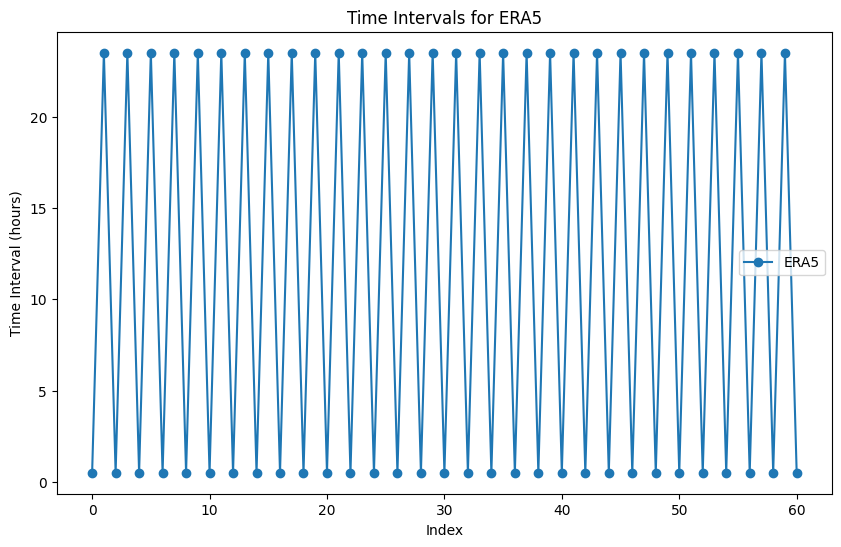

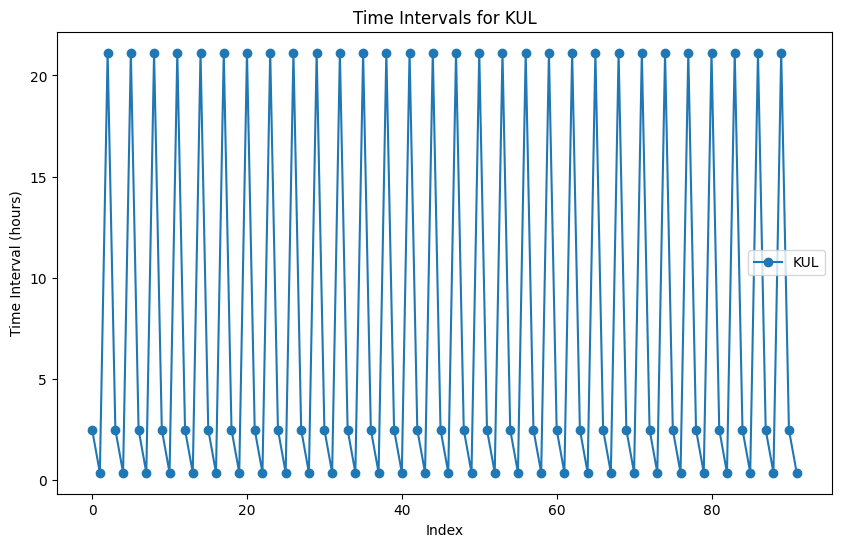

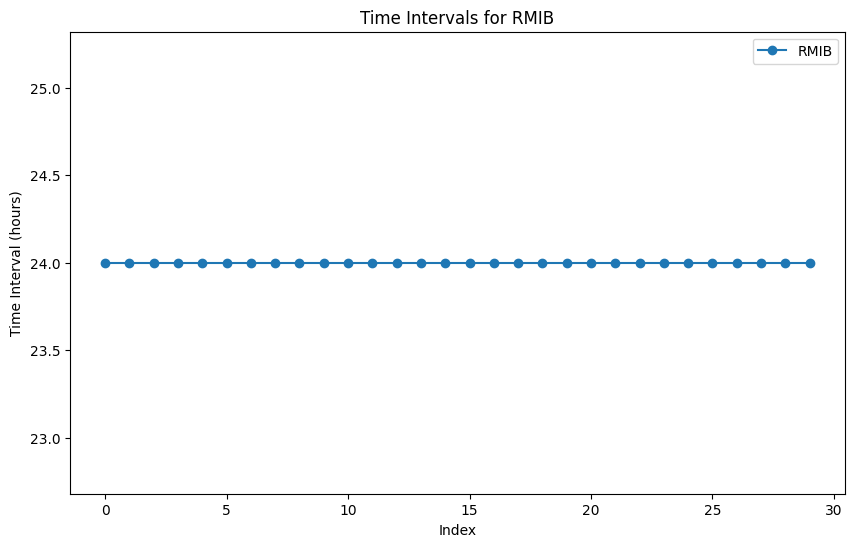

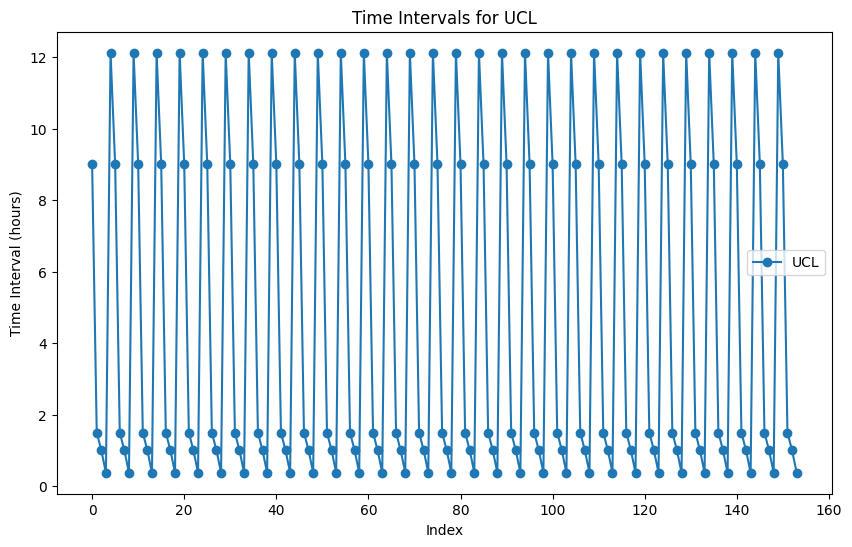

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Select January 1980 for each dataset
era5_tp = era5_land_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
kul_pr = kul_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
rmib_pr = rmib_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
ucl_pr = ucl_ds['pr'].sel(time=slice('1980-01-01', '1980-01-31'))
#eobs_pr = (eobs_tas_ds['pr'] + 273.15).sel(time=slice('1980-01-01', '1980-01-31'))  # Convert Celsius to Kelvin

# Function to check time intervals
def check_time_intervals(temp_data, name):
    time_diff = temp_data['time'].diff('time')
    time_diff_hours = time_diff.dt.total_seconds() / 3600  # Convert to hours

    print(f"\nTime Intervals and Frequencies for {name}:")
    unique_intervals, counts = np.unique(time_diff_hours, return_counts=True)
    for interval, count in zip(unique_intervals, counts):
        print(f"Interval: {interval} hours, Count: {count}")
    
    # Print actual time values for further inspection
    print(f"\nActual time values for {name}:")
    print(temp_data['time'].values)

# Check time intervals for each dataset
check_time_intervals(era5_pr, "ERA5")
check_time_intervals(kul_pr, "KUL")
check_time_intervals(rmib_pr, "RMIB")
check_time_intervals(ucl_pr, "UCL")
 # check_time_intervals(eobs_pr, "EOBS")

# Function to plot time intervals
def plot_time_intervals(temp_data, name):
    time_diff = temp_data['time'].diff('time').dt.total_seconds() / 3600  # Convert to hours

    plt.figure(figsize=(10, 6))
    plt.plot(time_diff, marker='o', linestyle='-', label=name)
    plt.xlabel('Index')
    plt.ylabel('Time Interval (hours)')
    plt.title(f'Time Intervals for {name}')
    plt.legend()
    plt.show()

# Plot time intervals for each dataset
plot_time_intervals(era5_pr, "ERA5")
plot_time_intervals(kul_pr, "KUL")
plot_time_intervals(rmib_pr, "RMIB")
plot_time_intervals(ucl_pr, "UCL")
# plot_time_intervals(eobs_pr, "EOBS")

##### 1.4.3 Time interval sequence check

In [11]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to check and print time interval sequence
def check_time_interval_sequence(temp_data, name):
    time_diff = temp_data['time'].diff('time')
    time_diff_hours = time_diff.dt.total_seconds() / 3600  # Convert to hours

    print(f"\nTime Interval Sequence for {name}:")
    for interval in time_diff_hours.values:
        print(interval, end=' ')
    print()

# Check time interval sequence for each dataset
check_time_interval_sequence(era5_pr, "ERA5")
check_time_interval_sequence(kul_pr, "KUL")
check_time_interval_sequence(rmib_pr, "RMIB")
check_time_interval_sequence(ucl_pr, "UCL")


Time Interval Sequence for ERA5:
0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 23.5 0.5 

Time Interval Sequence for KUL:
2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 21.125 2.5 0.375 

Time Interval Sequence for RMIB:
24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.0 24.

## 2. Spatial Analysis

### 2.1 Spatial plots 

No data to plot for ERA5-Land pr (2000-2011)
No data to plot for ERA5-Land evspsbl (2000-2011)


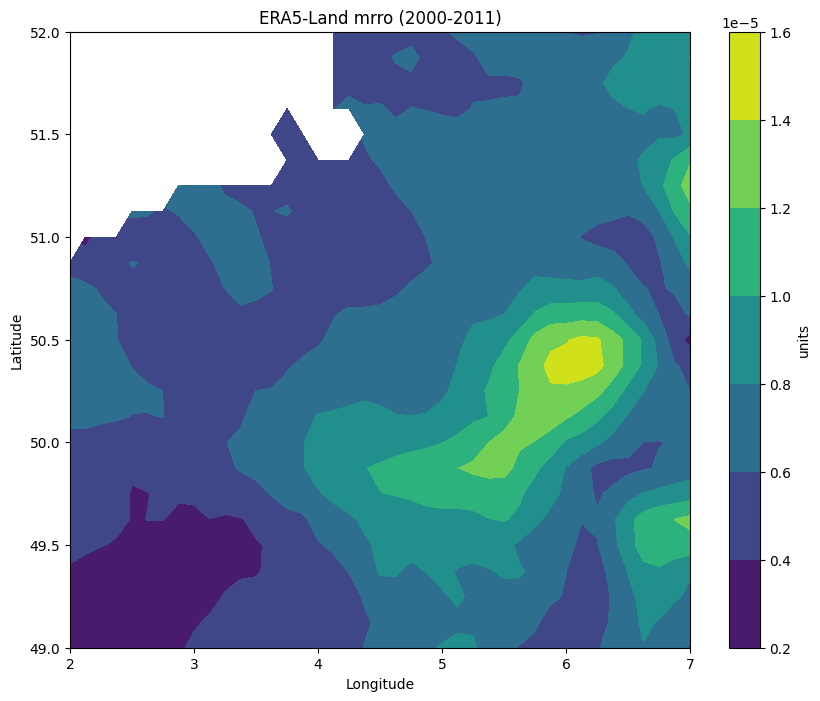

No data to plot for ERA5-Land mrso (2000-2011)
No data to plot for ERA5-Land delta_soil_moisture (2000-2011)


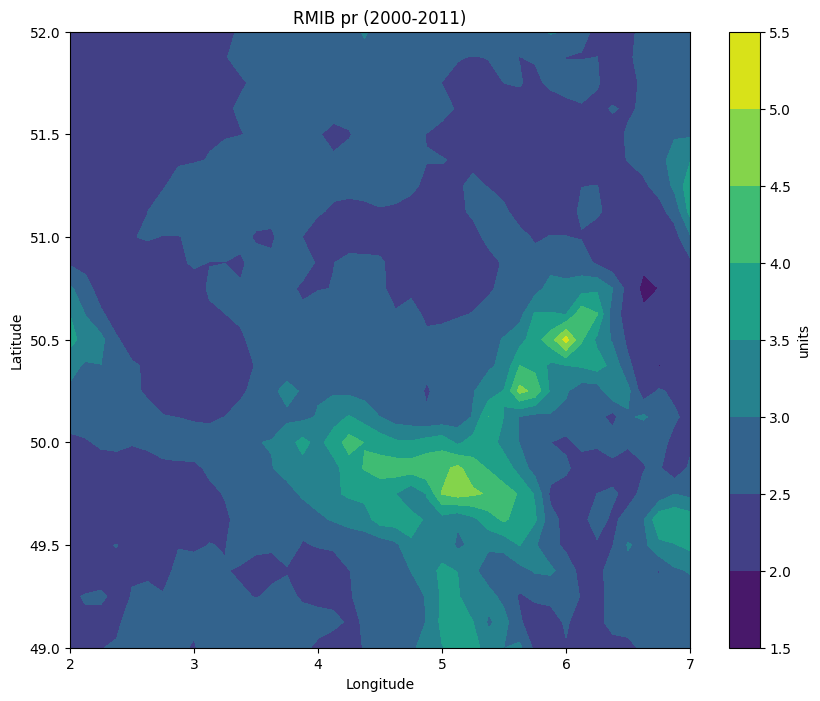

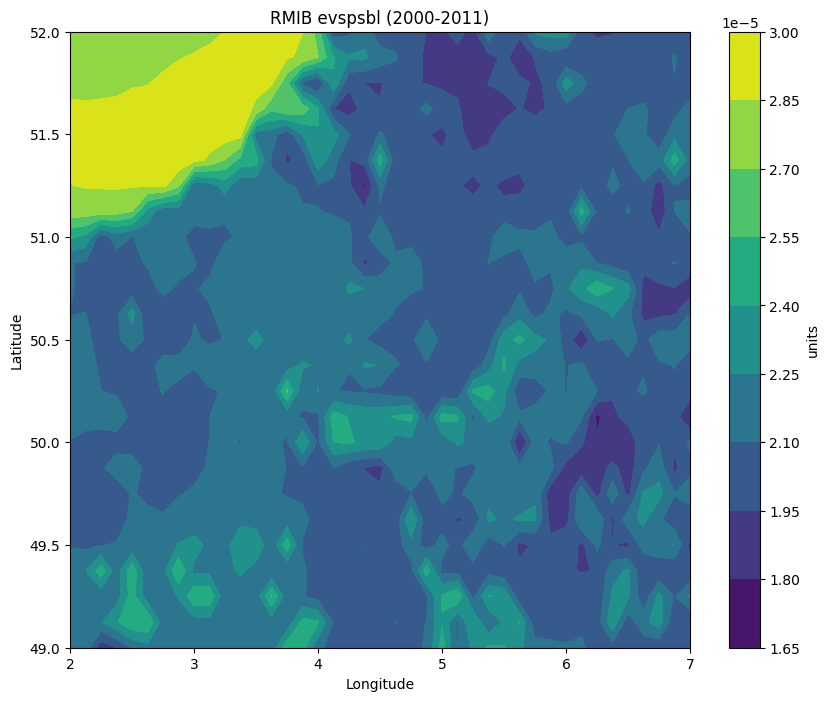

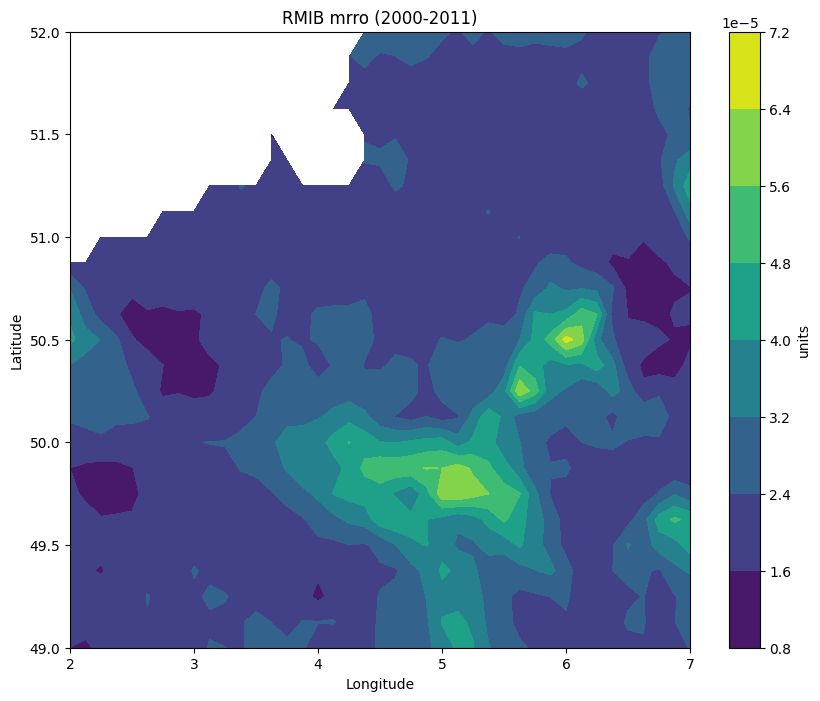

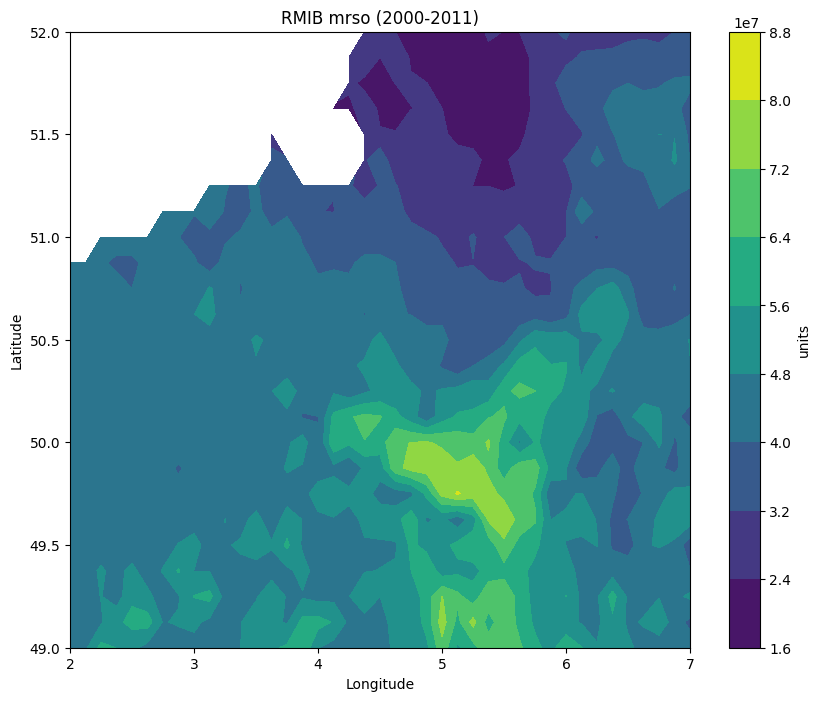

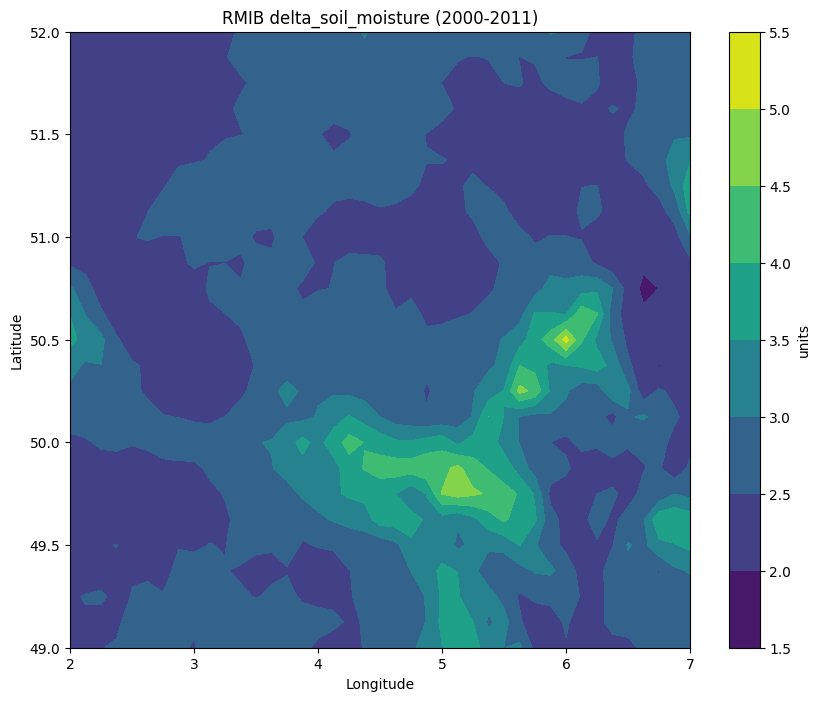

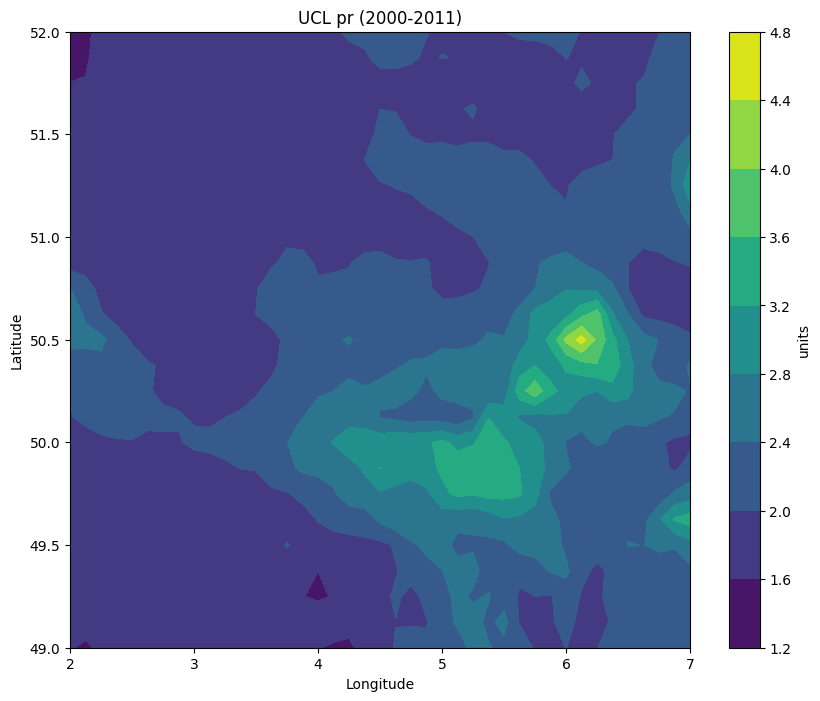

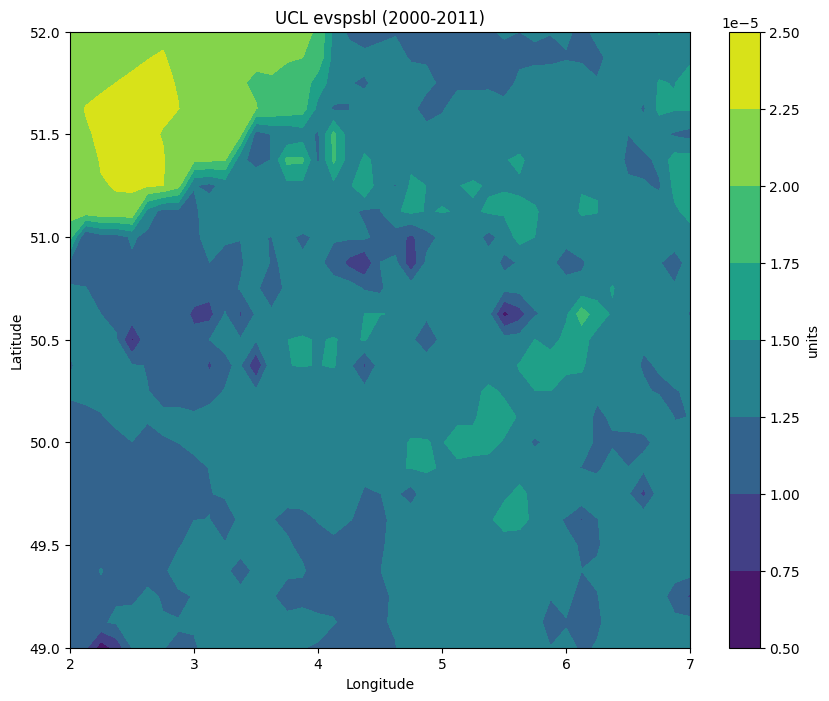

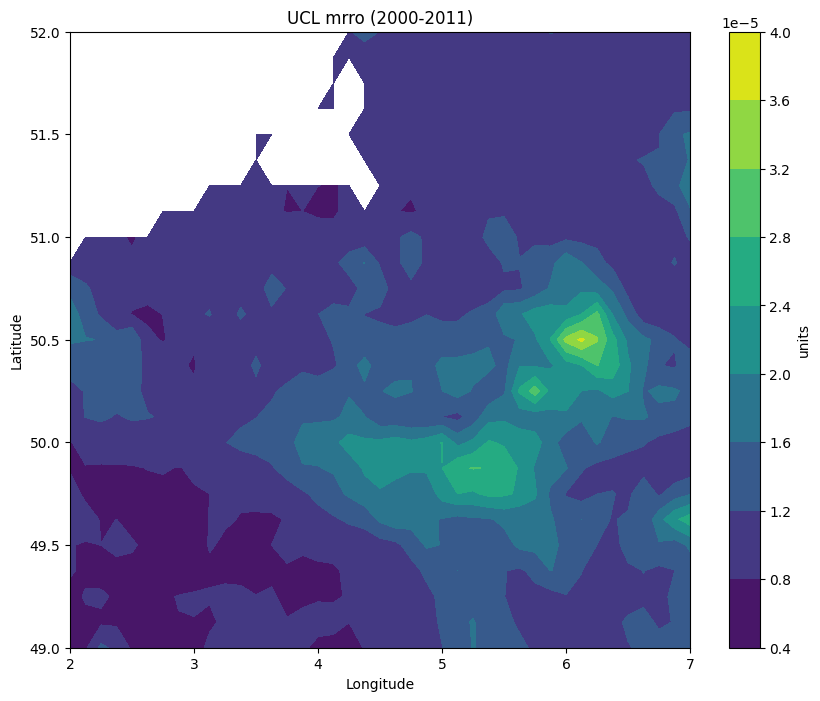

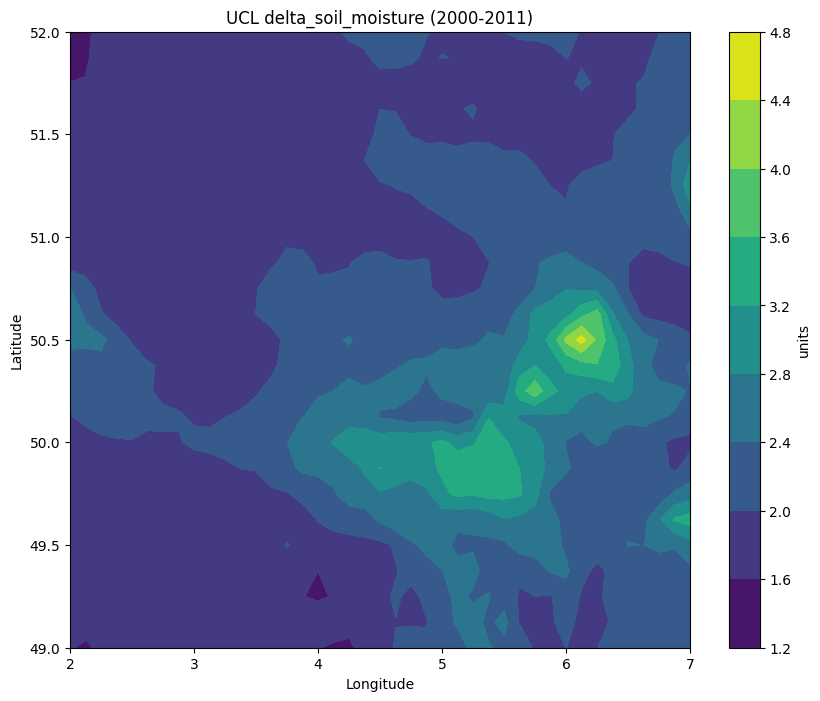

In [89]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def plot_spatial_data(ds, variable, title):
    """
    Plot spatial data for a specific variable.

    Parameters:
        ds (xarray.DataSet): The dataset containing spatial data.
        variable (str): The variable to plot.
        title (str): The title of the plot.
    """
    if ds is None or len(ds.variables) == 0 or variable not in ds.variables:
        print(f"No data to plot for {title}")
        return
    
    data = ds[variable]
    
    # Check if the data has spatial dimensions
    if 'lat' in data.dims and 'lon' in data.dims:
        if 'time' in data.dims and len(data.dims) > 2:  # If there are more than 2 dimensions, we need to reduce to 2D
            # Select a specific time index (e.g., the middle time index)
            time_index = len(data['time']) // 2
            data = data.isel(time=time_index)
        
        # Ensure data is 2D for contourf
        if len(data.dims) == 2:
            plt.figure(figsize=(10, 8))
            plt.contourf(data['lon'], data['lat'], data.values, cmap='viridis')
            plt.colorbar(label=data.attrs.get('units', 'units'))
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(title)
            plt.show()



def plot_mean_per_pixel(datasets, variables):
    """
    Plot the mean per pixel for specified variables across multiple datasets.

    Parameters:
        datasets (list of tuples): List of datasets and their labels.
        variables (list of str): List of variables to plot.
    """
    for ds, label in datasets:
        for variable in variables:
            plot_spatial_data(ds, variable, f'{label} {variable} (2000-2011)')

# Define datasets and their labels
datasets = [
    (era5_land_vars, 'ERA5-Land'),
    (rmib_vars, 'RMIB'),
    (ucl_vars, 'UCL')
]

# Define variables to plot including precipitation, evaporation, and runoff
variables_to_plot = [
    'pr',            # Precipitation
    'evspsbl',       # Evapotranspiration
    'mrro',          # Runoff
    'mrso',          # Soil Moisture
    'delta_soil_moisture'  # Soil Moisture Change
]

# Plot mean per pixel for all specified variables
plot_mean_per_pixel(datasets, variables_to_plot)


### 2.2 Spatial Differences

Variable 'pr' not found in both datasets.
Variable 'evspsbl' not found in both datasets.


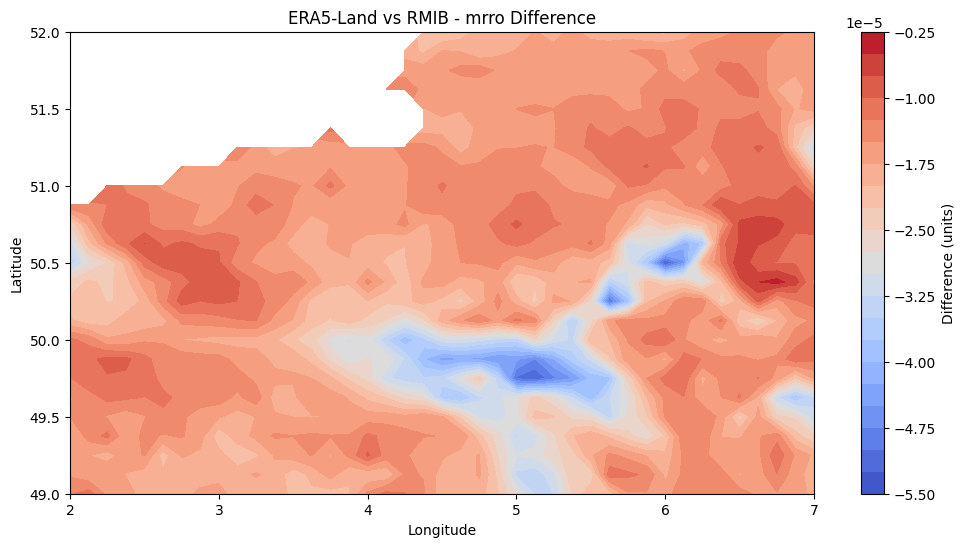

Variable 'mrso' not found in both datasets.
Variable 'delta_soil_moisture' not found in both datasets.
Variable 'pr' not found in both datasets.
Variable 'evspsbl' not found in both datasets.


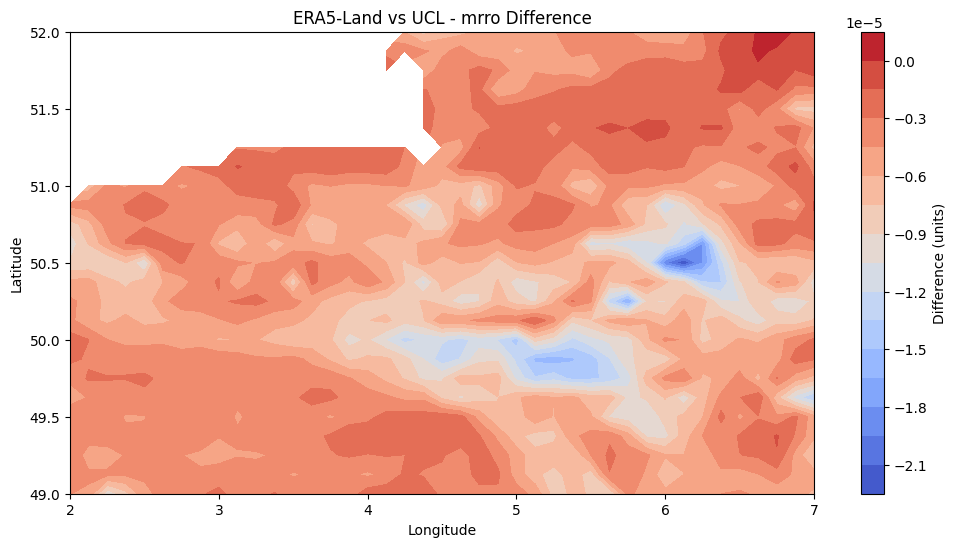

Variable 'mrso' not found in both datasets.
Variable 'delta_soil_moisture' not found in both datasets.


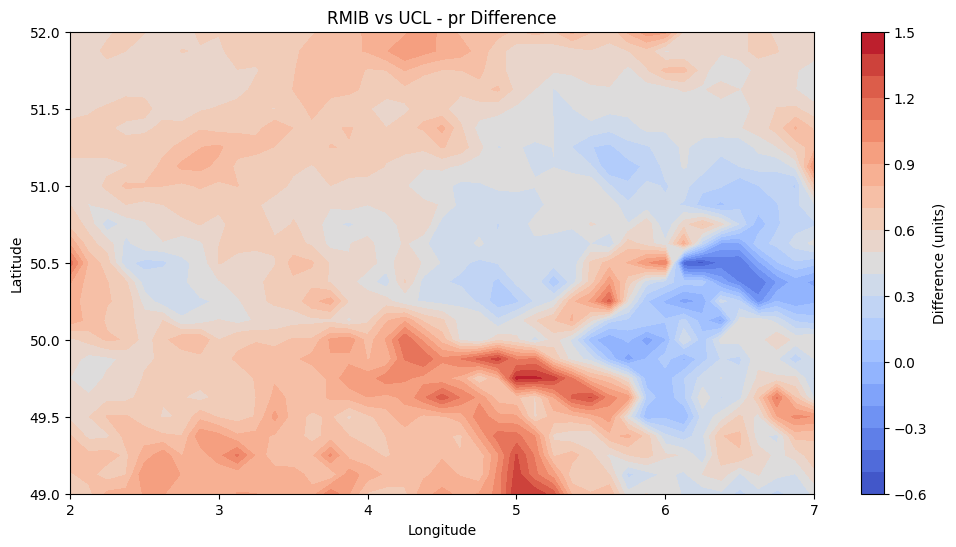

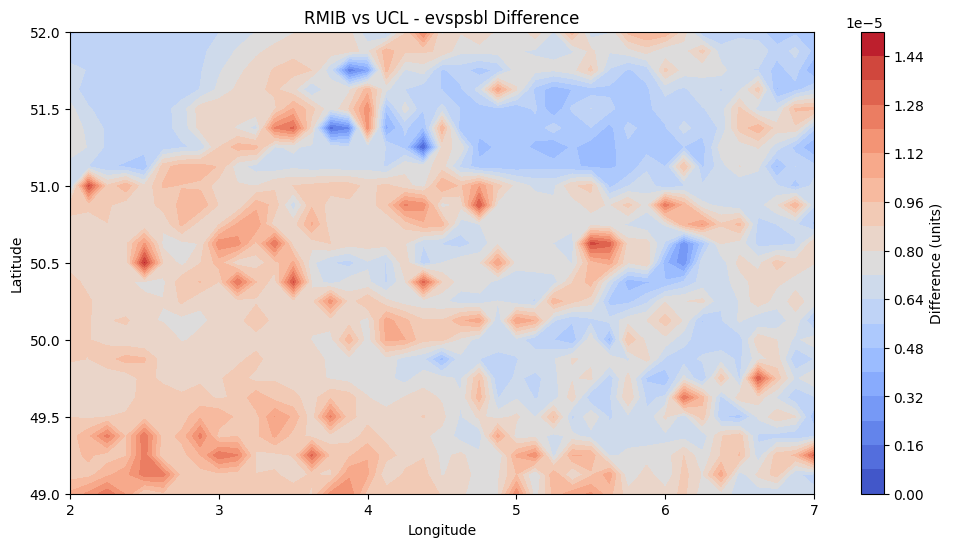

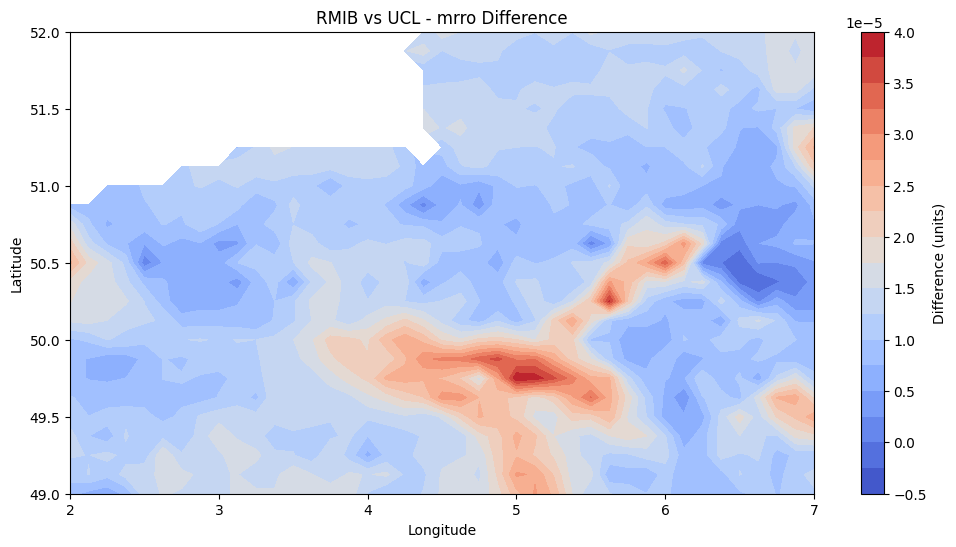

Data for RMIB vs UCL - mrso Difference is not 2D after reducing dimensions. Skipping plot.


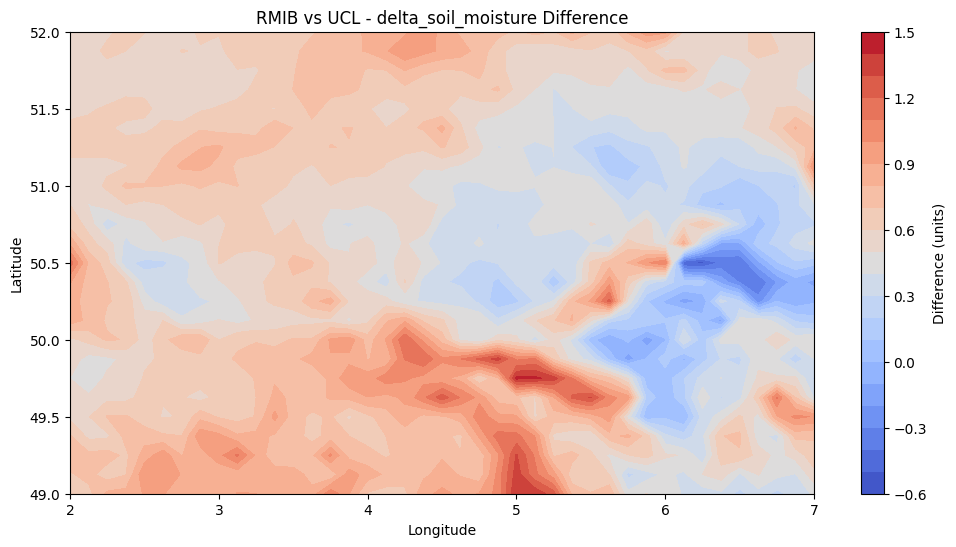

In [85]:
import xarray as xr
import matplotlib.pyplot as plt

def compute_and_plot_differences(ds1, ds2, variable, title):
    """
    Compute the spatial difference between two datasets for a specific variable and plot it.
    
    Parameters:
        ds1, ds2 (xarray.DataSet): The datasets containing spatial data.
        variable (str): The variable to compare.
        title (str): The title of the plot.
    """
    if variable not in ds1.variables or variable not in ds2.variables:
        print(f"Variable '{variable}' not found in both datasets.")
        return
    
    data1 = ds1[variable]
    data2 = ds2[variable]
    
    # Ensure both datasets have spatial dimensions
    if 'lat' in data1.dims and 'lon' in data1.dims:
        # Compute difference
        difference = data1 - data2
        
        # Handle extra dimensions (e.g., time)
        if len(difference.dims) > 2:
            # Choose a specific time index or reduce dimensions
            if 'time' in difference.dims:
                time_index = len(difference['time']) // 2  # Choose middle time index
                difference = difference.isel(time=time_index)
        
        # Check if the resulting data is 2D
        if len(difference.dims) == 2:
            # Plot difference
            plt.figure(figsize=(12, 6))
            plt.contourf(difference['lon'], difference['lat'], difference.values, cmap='coolwarm', levels=20)
            plt.colorbar(label='Difference (units)')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(title)
            plt.show()
        else:
            print(f"Data for {title} is not 2D after reducing dimensions. Skipping plot.")
    else:
        print(f"Data for {title} does not have spatial dimensions. Cannot plot differences.")

def compare_models(datasets, variables):
    """
    Compare model predictions and plot differences for specified variables.
    
    Parameters:
        datasets (list of tuples): List of datasets and their labels.
        variables (list of str): List of variables to compare.
    """
    for i in range(len(datasets)):
        for j in range(i + 1, len(datasets)):
            ds1, label1 = datasets[i]
            ds2, label2 = datasets[j]
            
            for variable in variables:
                title = f'{label1} vs {label2} - {variable} Difference'
                try:
                    compute_and_plot_differences(ds1, ds2, variable, title)
                except Exception as e:
                    print(f"Error while plotting {title}: {e}")

# Define datasets and their labels
datasets = [
    (era5_land_vars, 'ERA5-Land'),
    (rmib_vars, 'RMIB'),
    (ucl_vars, 'UCL')
]

# Define variables to compare
variables_to_compare = [
    'pr',            # Precipitation
    'evspsbl',       # Evapotranspiration
    'mrro',          # Runoff
    'mrso',          # Soil Moisture
    'delta_soil_moisture'  # Soil Moisture Change
]

# Compare models and plot differences
compare_models(datasets, variables_to_compare)


## 3. Water Budget Analysis 

### 3.1 Time series of water budget components and cumulative soil moisture over time

This code is adaptable for the other models.

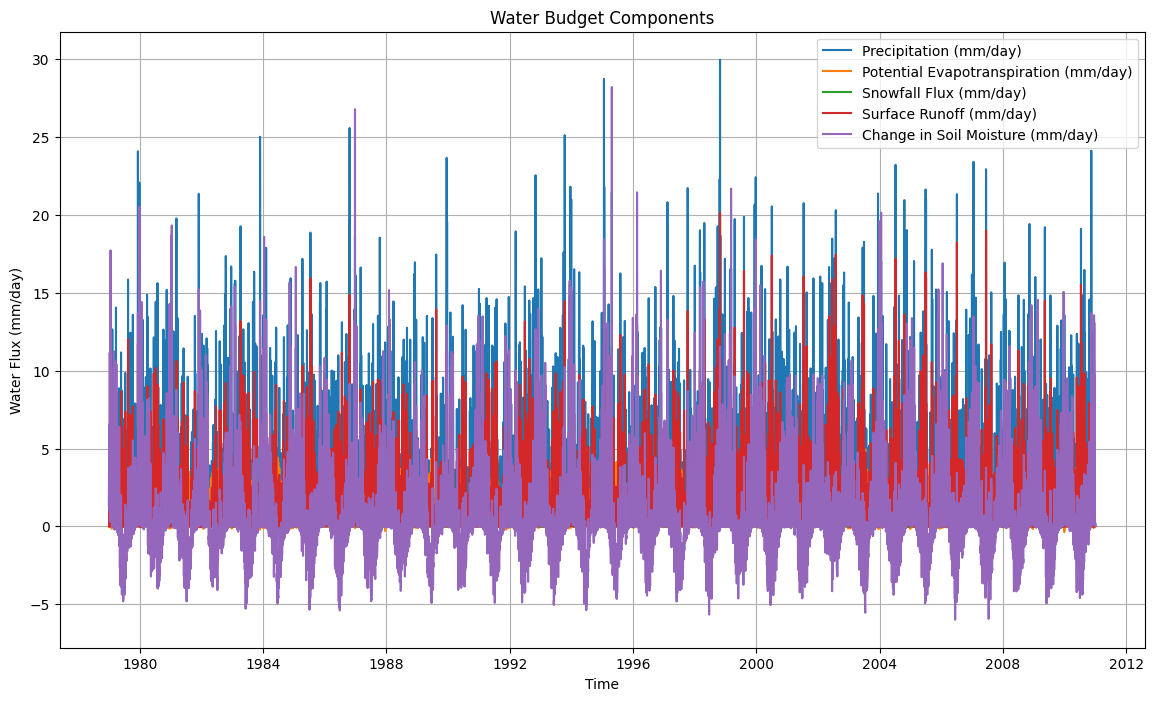

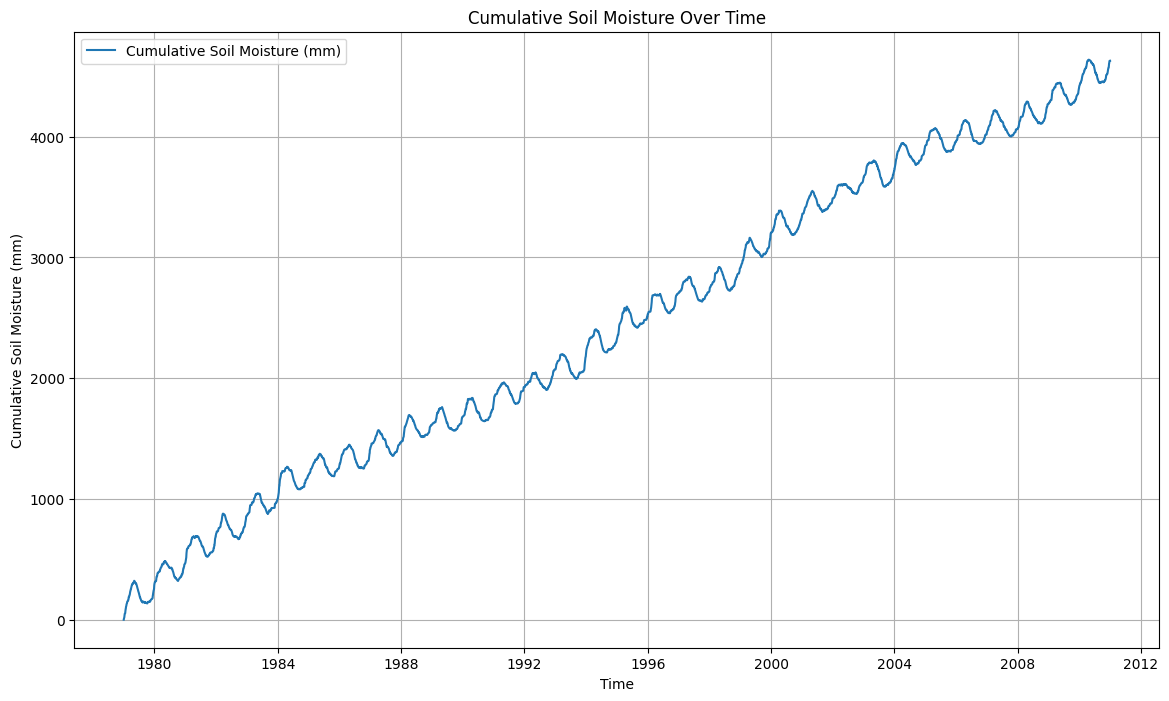

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def convert_units(pr, evspsblpot, prsn, mrros):
    # Conversion factor from kg m-2 s-1 to mm/day
    conversion_factor = 86400  # (1 kg m-2 s-1) * (86400 s/day) * (1 mm/kg m^2)
    
    pr_mm_day = pr * conversion_factor
    evspsblpot_mm_day = evspsblpot * conversion_factor
    prsn_mm_day = prsn * conversion_factor
    mrros_mm_day = mrros * conversion_factor
    
    return pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day

def compute_water_budget(pr, evspsblpot, prsn, mrros, mrso):
    # Calculate change in soil moisture
    delta_soil_moisture = pr + prsn - evspsblpot - mrros
    
    # Calculate cumulative soil moisture change
    cumulative_soil_moisture = delta_soil_moisture.cumsum(dim='time')
    
    return delta_soil_moisture, cumulative_soil_moisture

def plot_water_budget(time, pr, evspsblpot, prsn, mrros, delta_soil_moisture, cumulative_soil_moisture):
    # Plot the components
    plt.figure(figsize=(14, 8))
    plt.plot(time, pr.mean(dim=['lat', 'lon']), label='Precipitation (mm/day)')
    plt.plot(time, evspsblpot.mean(dim=['lat', 'lon']), label='Potential Evapotranspiration (mm/day)')
    plt.plot(time, prsn.mean(dim=['lat', 'lon']), label='Snowfall Flux (mm/day)')
    plt.plot(time, mrros.mean(dim=['lat', 'lon']), label='Surface Runoff (mm/day)')
    plt.plot(time, delta_soil_moisture.mean(dim=['lat', 'lon']), label='Change in Soil Moisture (mm/day)')
    plt.xlabel('Time')
    plt.ylabel('Water Flux (mm/day)')
    plt.legend()
    plt.title('Water Budget Components')
    plt.grid(True)
    plt.show()

    # Plot cumulative soil moisture
    plt.figure(figsize=(14, 8))
    plt.plot(time, cumulative_soil_moisture.mean(dim=['lat', 'lon']), label='Cumulative Soil Moisture (mm)')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Soil Moisture (mm)')
    plt.legend()
    plt.title('Cumulative Soil Moisture Over Time')
    plt.grid(True)
    plt.show()

def main(dataset):
    # Extract variables
    pr = dataset['pr']  # Precipitation flux
    evspsblpot = dataset['evspsblpot']  # Potential Evapotranspiration
    prsn = dataset['prsn']  # Snowfall Flux
    mrros = dataset['mrros']  # Total Runoff
    mrso = dataset['mrso']  # Total Soil Moisture Content
    
    # Convert units to mm/day
    pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day = convert_units(pr, evspsblpot, prsn, mrros)
    
    # Compute water budget
    delta_soil_moisture, cumulative_soil_moisture = compute_water_budget(pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day, mrso)
    
    # Plot the results
    plot_water_budget(pr.time, pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day, delta_soil_moisture, cumulative_soil_moisture)

# Run the main function with the loaded dataset
main(rmib_ds)

### 3.2 Water surplus and deficit over time 

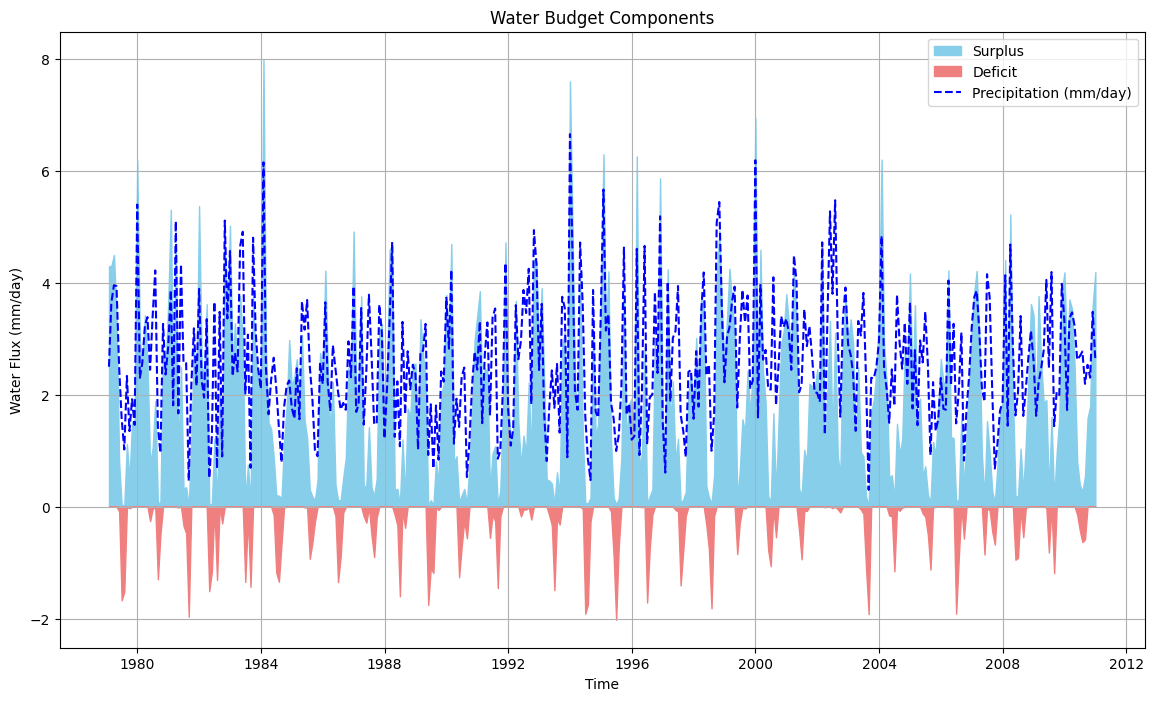

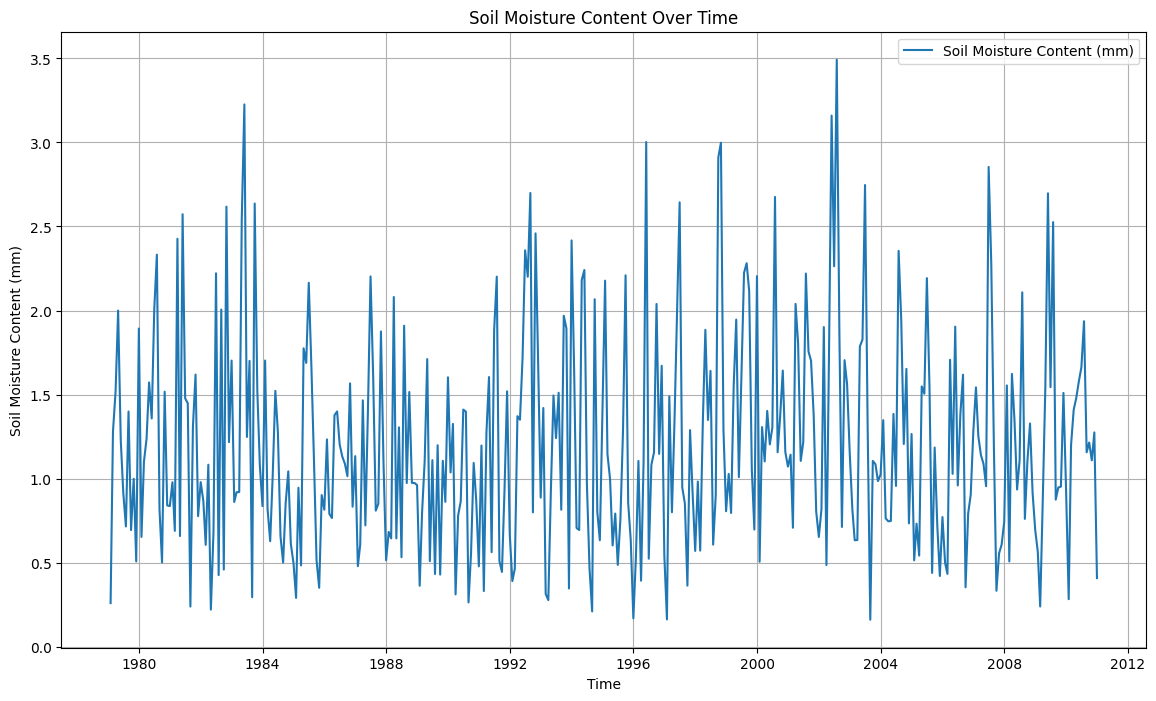

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

def convert_units(pr, evspsblpot, prsn, mrros):
    conversion_factor = 86400  # (1 kg m-2 s-1) * (86400 s/day) * (1 mm/kg m^2)
    
    pr_mm_day = pr * conversion_factor
    evspsblpot_mm_day = evspsblpot * conversion_factor
    prsn_mm_day = prsn * conversion_factor
    mrros_mm_day = mrros * conversion_factor
    
    return pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day

def compute_monthly_means(pr, evspsblpot, prsn, mrros, mrso):
    pr_monthly = pr.resample(time='ME').mean(dim='time')
    evspsblpot_monthly = evspsblpot.resample(time='ME').mean(dim='time')
    prsn_monthly = prsn.resample(time='ME').mean(dim='time')
    mrros_monthly = mrros.resample(time='ME').mean(dim='time')
    mrso_monthly = mrso.resample(time='ME').mean(dim='time')
    
    return pr_monthly, evspsblpot_monthly, prsn_monthly, mrros_monthly, mrso_monthly

def plot_water_budget(time, pr, evspsblpot, prsn, mrros, mrso):
    surplus = (pr + prsn) - evspsblpot
    deficit = evspsblpot - (pr + prsn)
    
    surplus = surplus.where(surplus > 0, 0)
    deficit = deficit.where(deficit > 0, 0)
    
    plt.figure(figsize=(14, 8))
    plt.fill_between(time, 0, surplus.mean(dim=['lat', 'lon']), color='skyblue', label='Surplus')
    plt.fill_between(time, 0, -deficit.mean(dim=['lat', 'lon']), color='lightcoral', label='Deficit')
    plt.plot(time, pr.mean(dim=['lat', 'lon']), color='blue', label='Precipitation (mm/day)', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('Water Flux (mm/day)')
    plt.legend()
    plt.title('Water Budget Components')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(14, 8))
    plt.plot(time, mrros.mean(dim=['lat', 'lon']), label='Soil Moisture Content (mm)')
    plt.xlabel('Time')
    plt.ylabel('Soil Moisture Content (mm)')
    plt.legend()
    plt.title('Soil Moisture Content Over Time')
    plt.grid(True)
    plt.show()

def main(dataset):
    pr = dataset['pr']
    evspsblpot = dataset['evspsblpot']
    prsn = dataset['prsn']
    mrros = dataset['mrros']
    mrso = dataset['mrso']
    
    pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day = convert_units(pr, evspsblpot, prsn, mrros)
    
    pr_monthly, evspsblpot_monthly, prsn_monthly, mrros_monthly, mrso_monthly = compute_monthly_means(pr_mm_day, evspsblpot_mm_day, prsn_mm_day, mrros_mm_day, mrso)
    
    plot_water_budget(pr_monthly.time, pr_monthly, evspsblpot_monthly, prsn_monthly, mrros_monthly, mrso_monthly)

main(rmib_ds)

### 3.3 Water budget components and calculated net change per year 

It would be recommended to plot swvl1 and mrso next to the net change to see how well it is predicted.

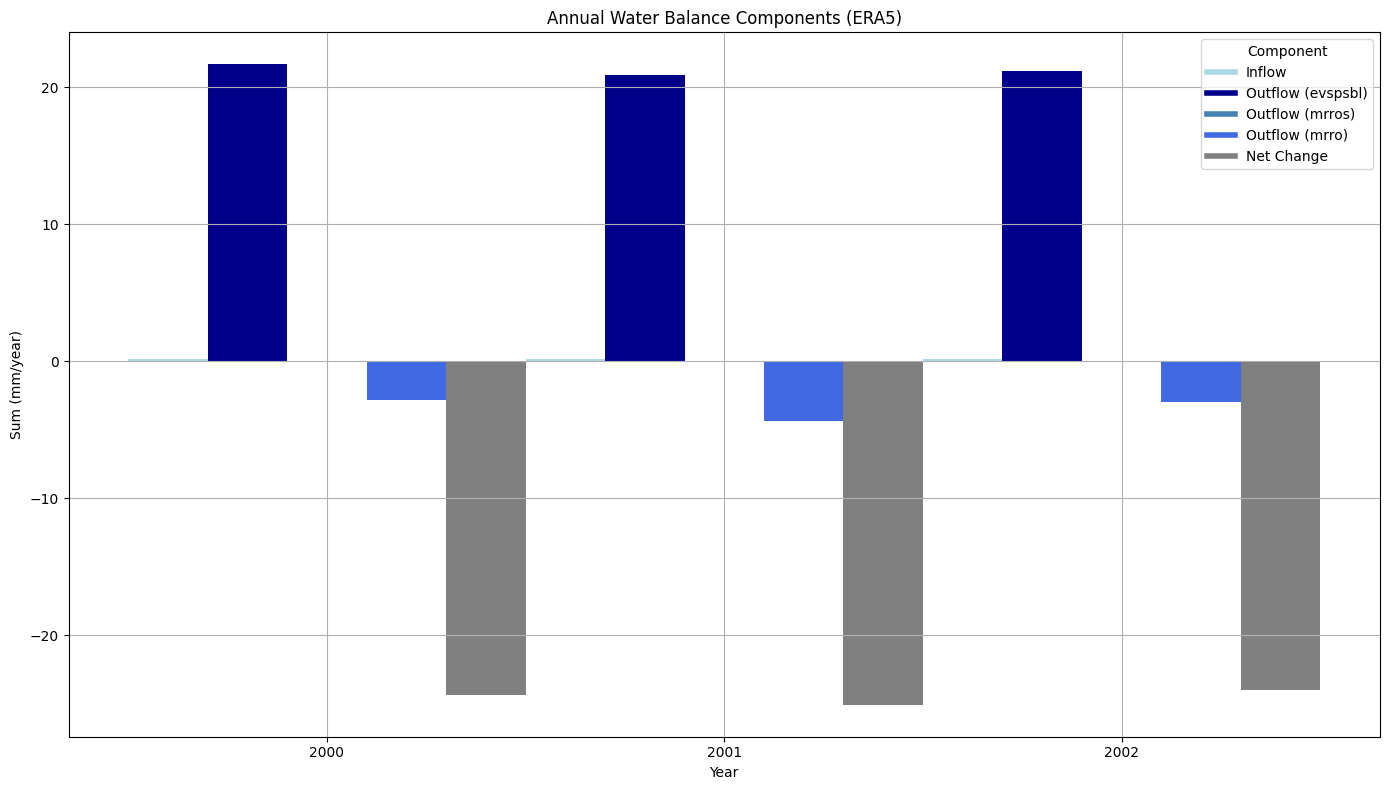

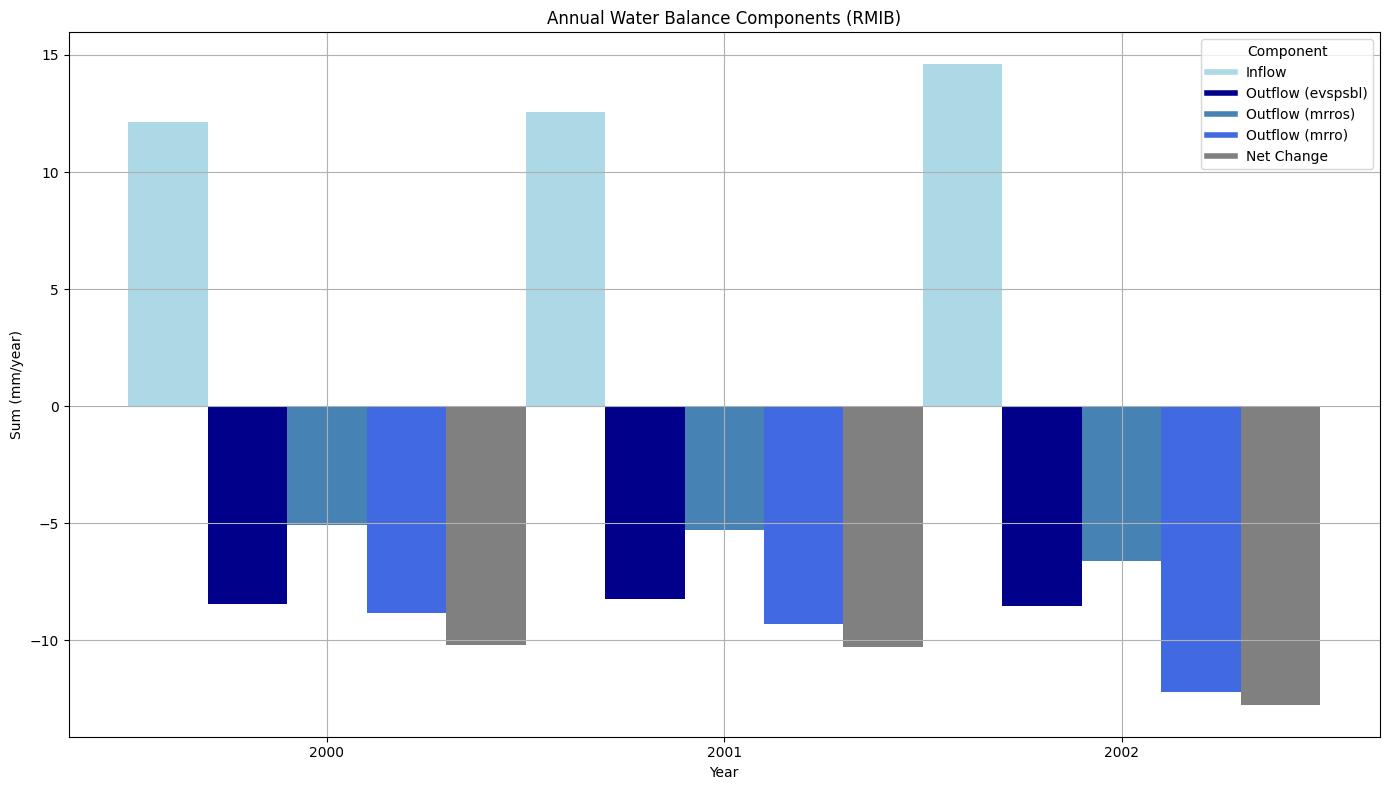

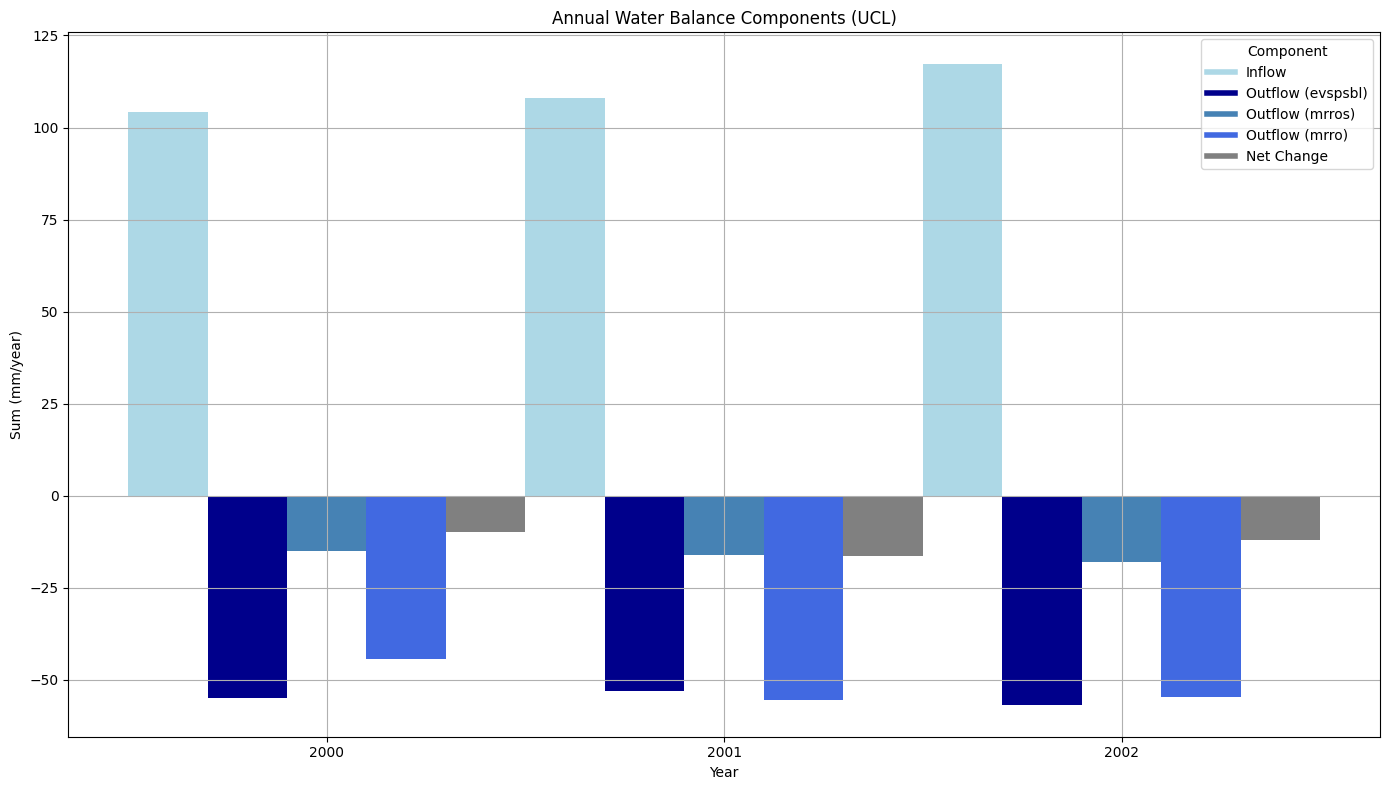

In [99]:
# Note that the snow component is not included in the inflow

import pandas as pd
import matplotlib.pyplot as plt

# Define colors
colors_in = {
    'pr': 'lightblue'
}
colors_out = {
    'evspsbl': 'darkblue',
    'mrros': 'steelblue',
    'mrro': 'royalblue'
}
colors_net = 'grey'

# Function to plot for each dataset
def plot_water_balance(annual_data, dataset_name, years_to_plot):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    components_in = ['pr']
    components_out = ['evspsbl', 'mrros', 'mrro']
    
    bar_width = 0.2
    spacing = 0  # No spacing between bars
    positions = list(range(len(years_to_plot)))  # X positions for each year

    for idx, year in enumerate(years_to_plot):
        # Extract inflows and outflows for the year
        inflows = annual_data.loc[f'{year}-12-31', components_in].dropna()
        outflows = -annual_data.loc[f'{year}-12-31', components_out].dropna()
        
        # Calculate starting position for this year
        current_position = positions[idx]
        
        # Plot inflows
        for i, (component, value) in enumerate(inflows.items()):
            bar_pos = current_position + i * (bar_width + spacing)
            ax.bar(bar_pos, value, width=bar_width, color=colors_in.get(component, 'blue'))
        
        # Plot outflows
        for i, (component, value) in enumerate(outflows.items()):
            bar_pos = current_position + (len(components_in) + i) * (bar_width + spacing)
            ax.bar(bar_pos, value, width=bar_width, color=colors_out.get(component, 'blue'))
        
        # Calculate and plot net change
        net_change = inflows.sum() - outflows.abs().sum()
        bar_pos = current_position + (len(components_in) + len(components_out)) * (bar_width + spacing)
        ax.bar(bar_pos, net_change, width=bar_width, color=colors_net)
    
    # Set x-ticks and labels
    xticks_positions = [pos + (len(components_in) + len(components_out)) * (bar_width + spacing) / 2 for pos in positions]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(years_to_plot)
    
    # Set y-axis labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Sum (mm/year)')
    ax.set_title(f'Annual Water Balance Components ({dataset_name})')
    
    # Create a simplified legend
    inflow_legend = [plt.Line2D([0], [0], color=colors_in.get('pr', 'blue'), lw=4)]
    outflow_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors_out.values()]
    net_legend = [plt.Line2D([0], [0], color=colors_net, lw=4)]
    ax.legend(inflow_legend + outflow_legend + net_legend, ['Inflow', 'Outflow (evspsbl)', 'Outflow (mrros)', 'Outflow (mrro)', 'Net Change'], title='Component')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define the years you want to plot
years_to_plot = [2000, 2001, 2002]

# Plot for ERA5
plot_water_balance(era5_land_annual, 'ERA5', years_to_plot)

# Plot for RMIB
plot_water_balance(rmib_annual, 'RMIB', years_to_plot)

# Plot for UCL
plot_water_balance(ucl_annual, 'UCL', years_to_plot)


## 4. Statistical Analysis 

### 4.1 Standard statistics and visualizations with bar charts and boxplots.

Variable pr not found in ERA5-Land
Variable evspsbl not found in ERA5-Land
ERA5-Land mrro Statistics:
  Mean: 0.00
  Median: 0.00
  Standard Deviation: 0.00
  Min: 0.00
  Max: 0.00


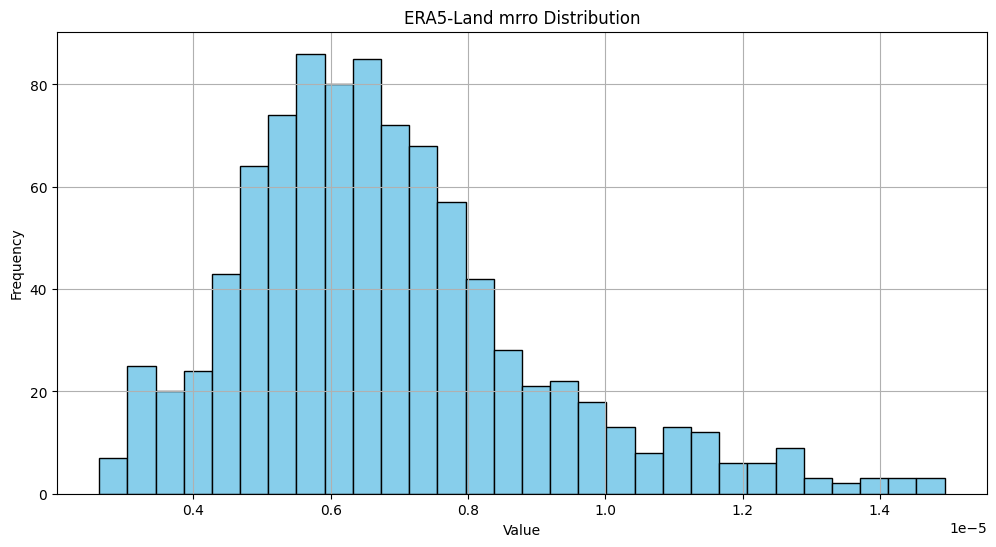

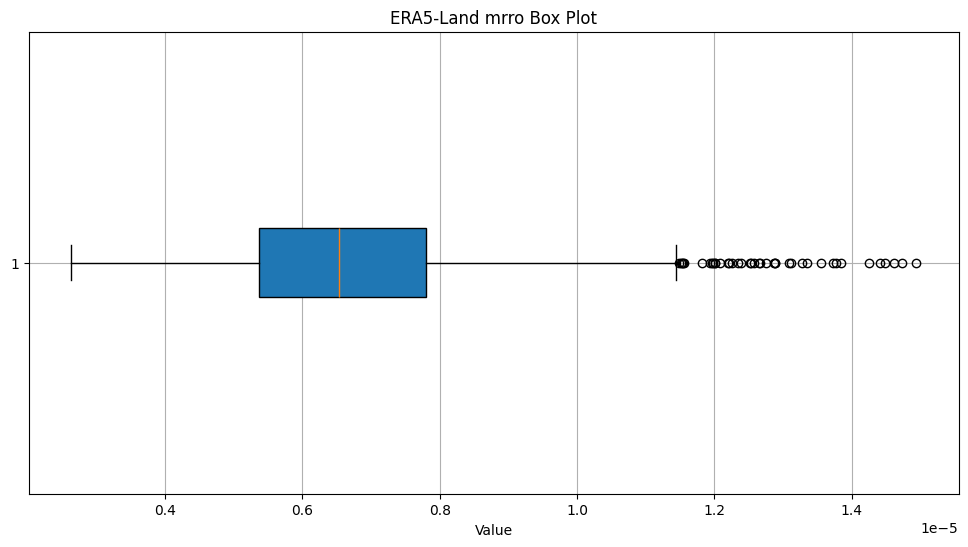

Variable mrso not found in ERA5-Land
Variable delta_soil_moisture not found in ERA5-Land
RMIB pr Statistics:
  Mean: 2.68
  Median: 2.56
  Standard Deviation: 0.44
  Min: 1.88
  Max: 5.20


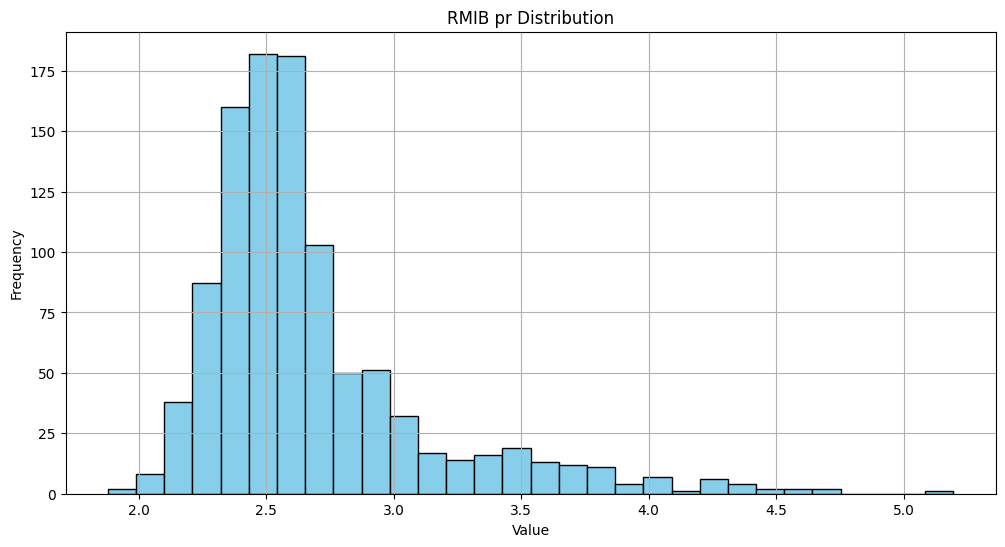

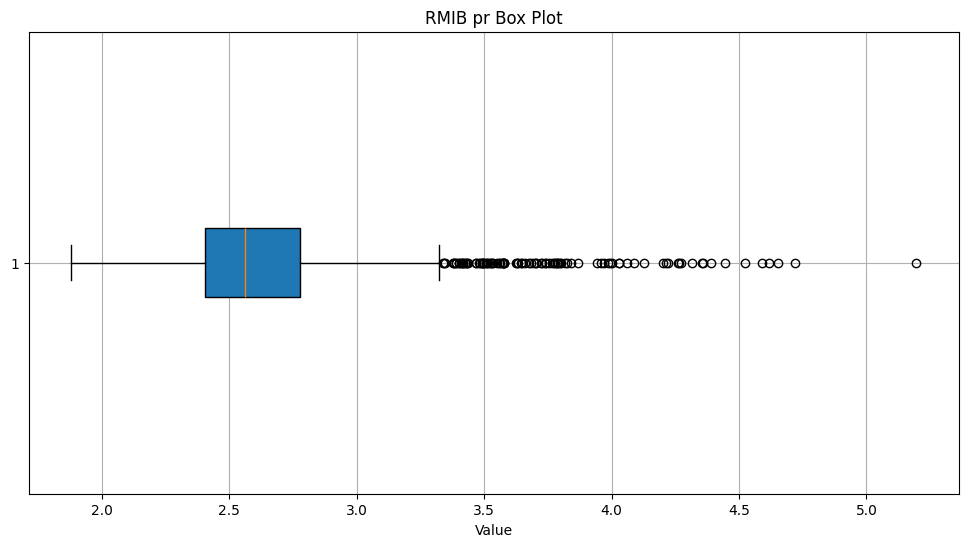

RMIB evspsbl Statistics:
  Mean: 0.00
  Median: 0.00
  Standard Deviation: 0.00
  Min: 0.00
  Max: 0.00


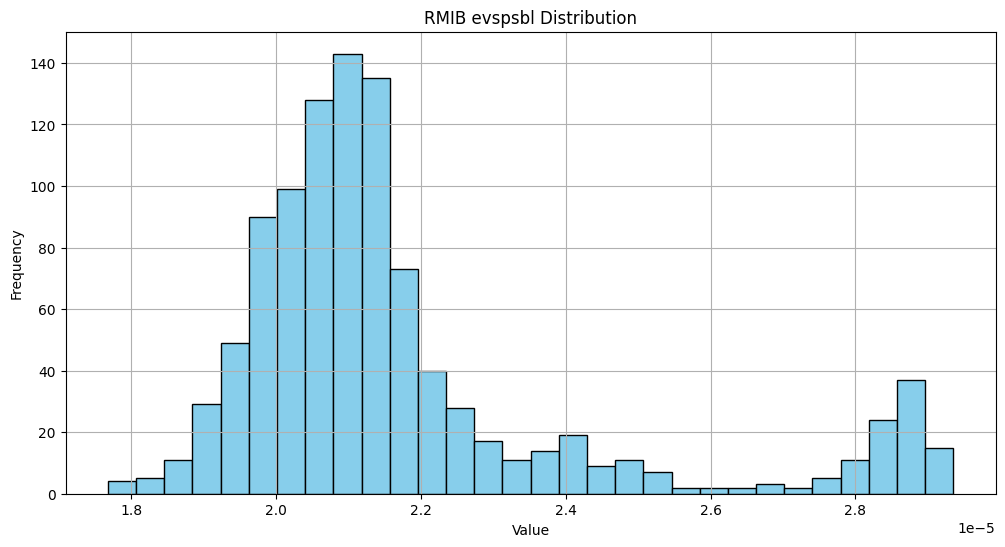

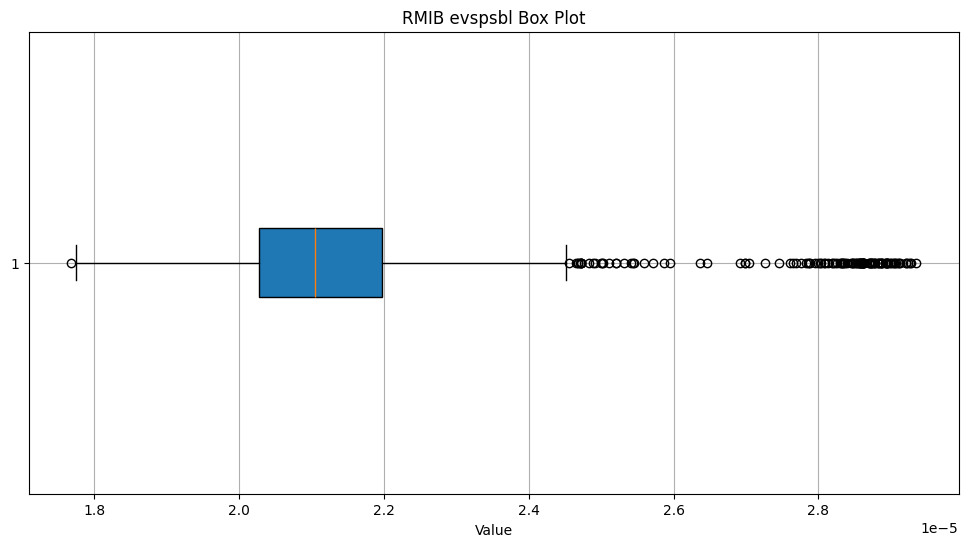

RMIB mrro Statistics:
  Mean: 0.00
  Median: 0.00
  Standard Deviation: 0.00
  Min: 0.00
  Max: 0.00


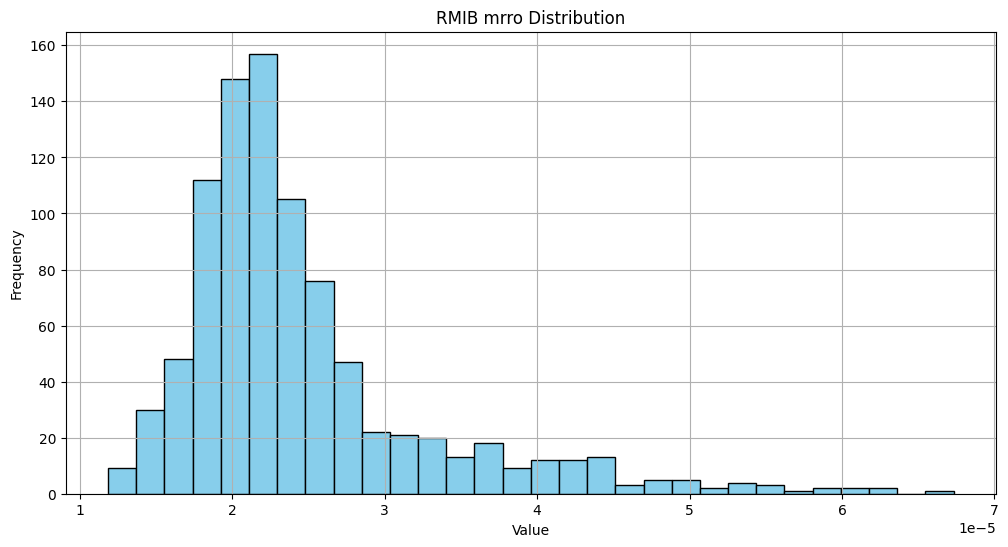

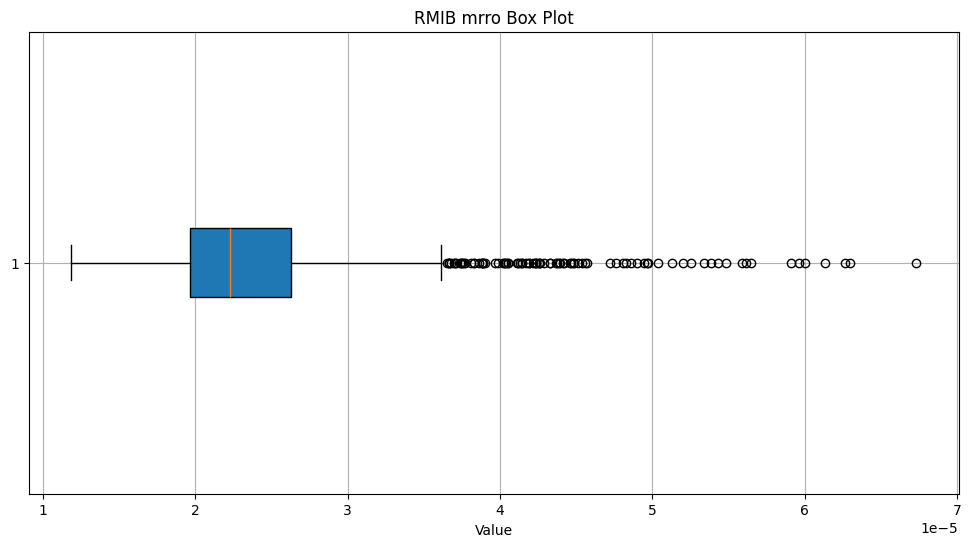

RMIB mrso Statistics:
  Mean: 43227817.31
  Median: 43289714.36
  Standard Deviation: 11048149.95
  Min: 19353135.94
  Max: 80845799.41


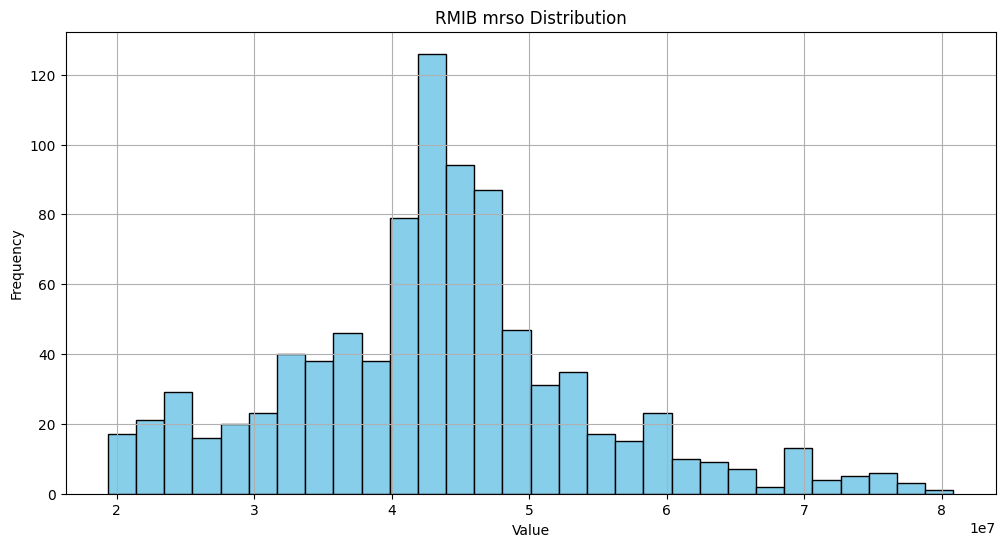

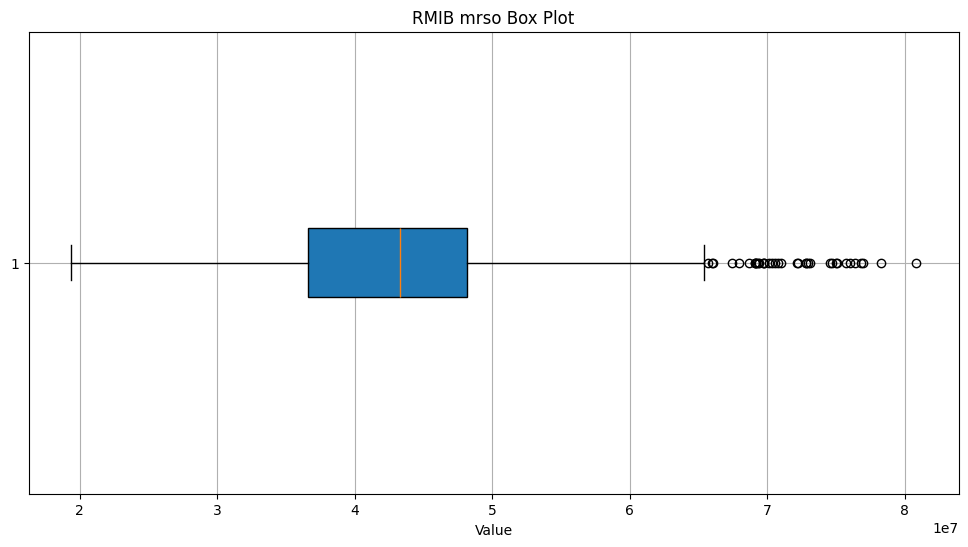

RMIB delta_soil_moisture Statistics:
  Mean: 2.68
  Median: 2.56
  Standard Deviation: 0.44
  Min: 1.88
  Max: 5.20


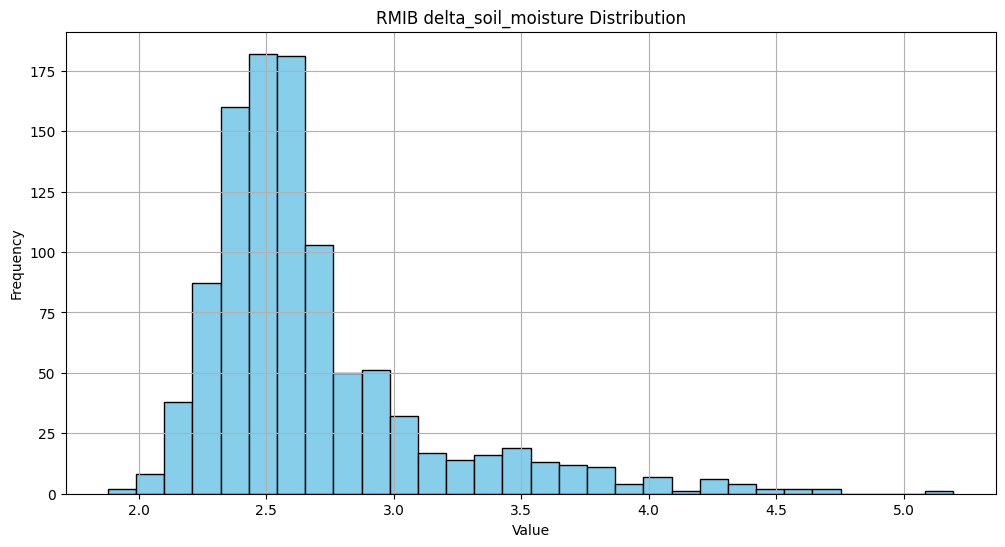

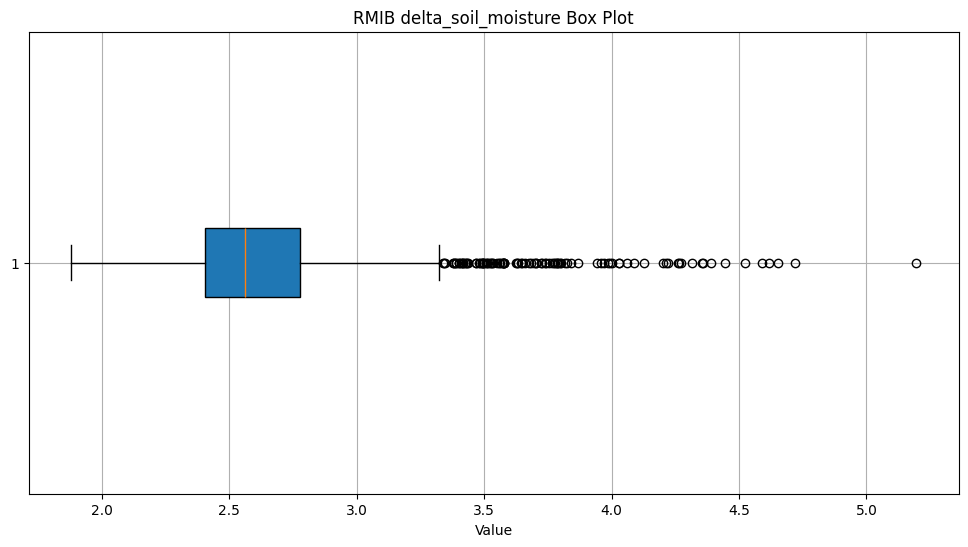

UCL pr Statistics:
  Mean: 2.11
  Median: 1.99
  Standard Deviation: 0.40
  Min: 1.51
  Max: 4.57


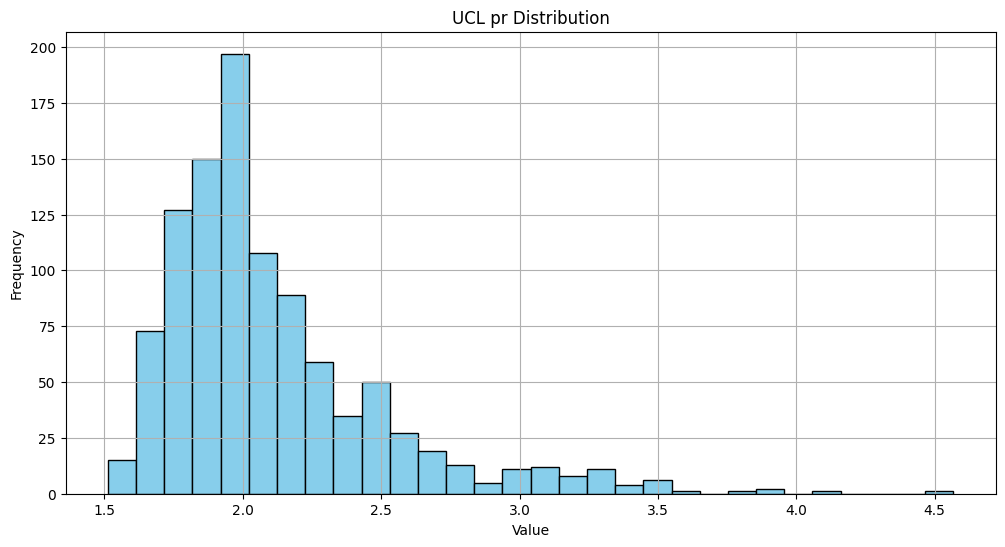

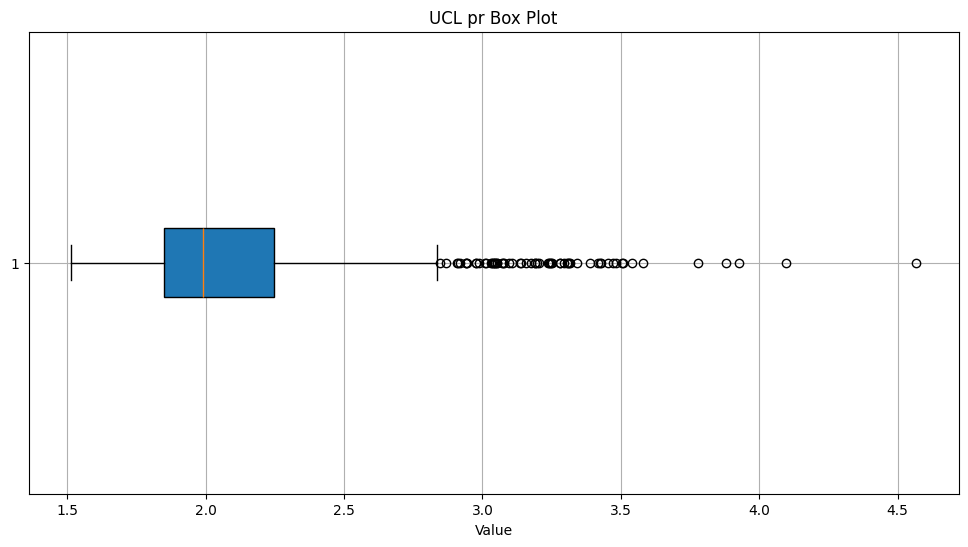

UCL evspsbl Statistics:
  Mean: 0.00
  Median: 0.00
  Standard Deviation: 0.00
  Min: 0.00
  Max: 0.00


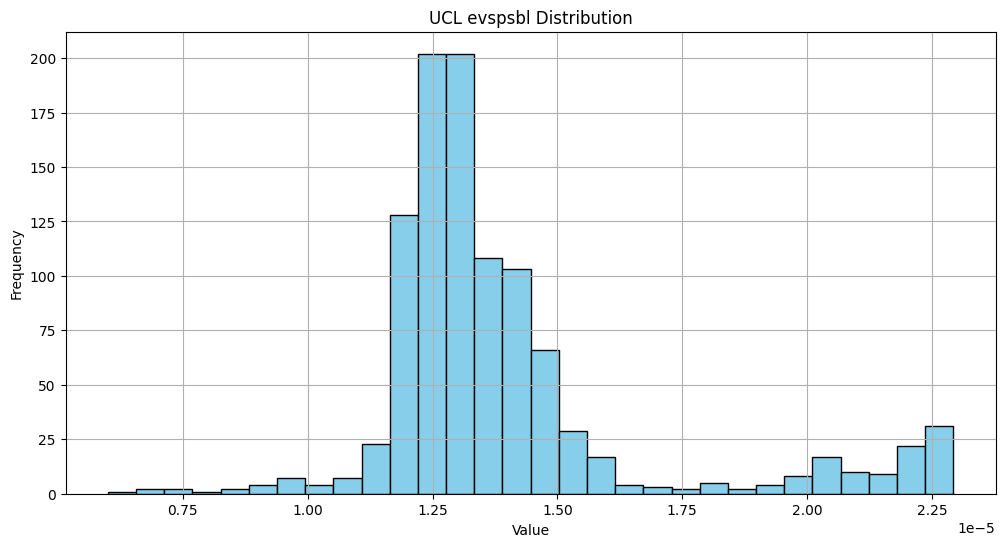

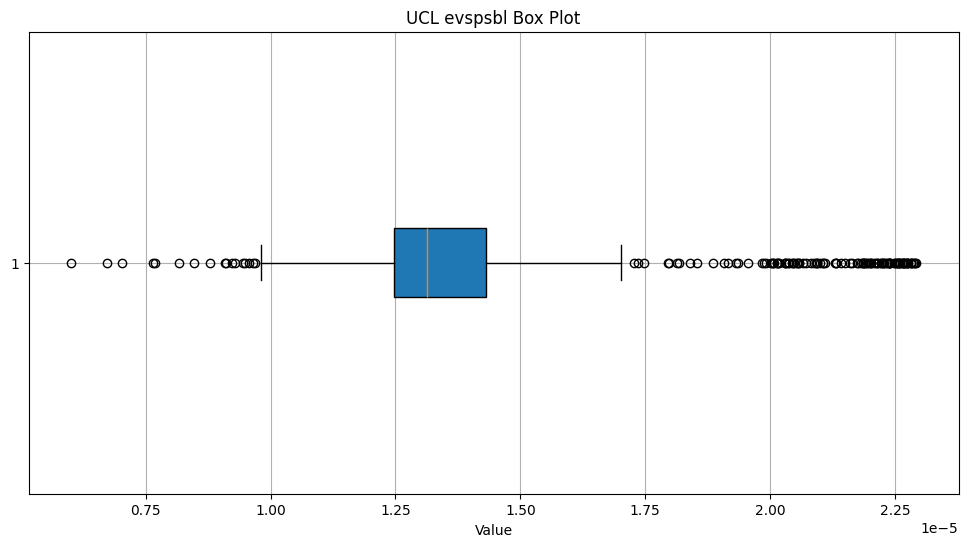

UCL mrro Statistics:
  Mean: 0.00
  Median: 0.00
  Standard Deviation: 0.00
  Min: 0.00
  Max: 0.00


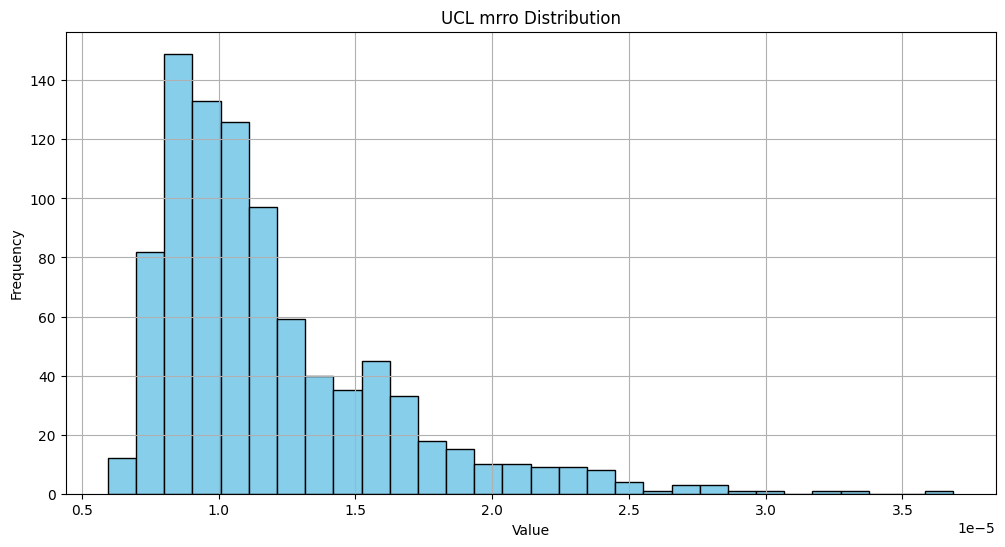

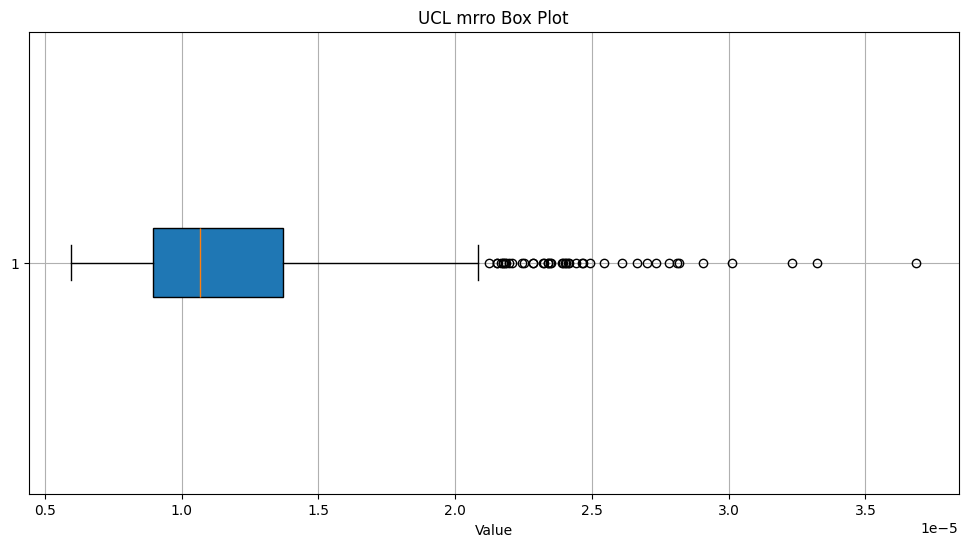

UCL mrso Statistics:
  Mean: 36536729.29
  Median: 6610237.76
  Standard Deviation: 57394612.72
  Min: 141814.36
  Max: 408522107.81


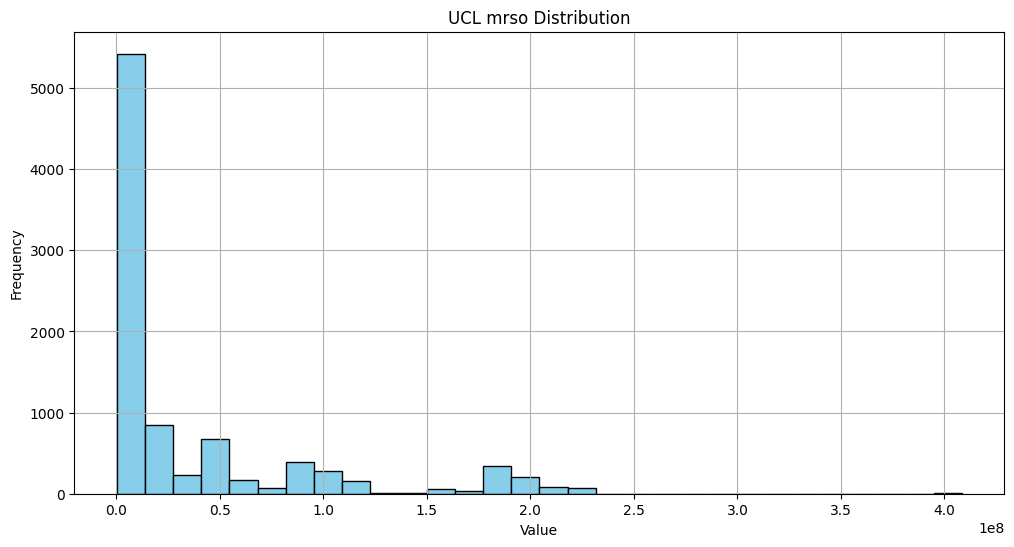

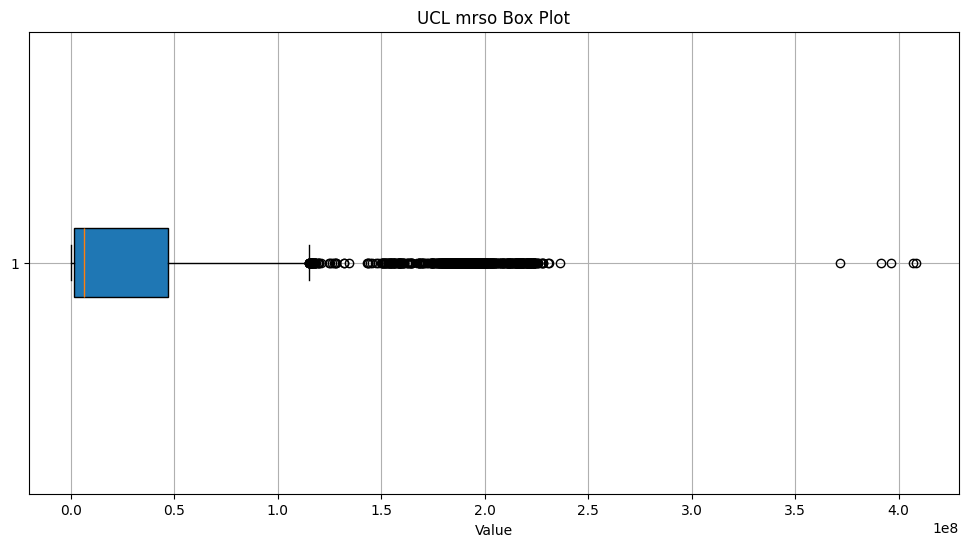

UCL delta_soil_moisture Statistics:
  Mean: 2.11
  Median: 1.99
  Standard Deviation: 0.40
  Min: 1.51
  Max: 4.57


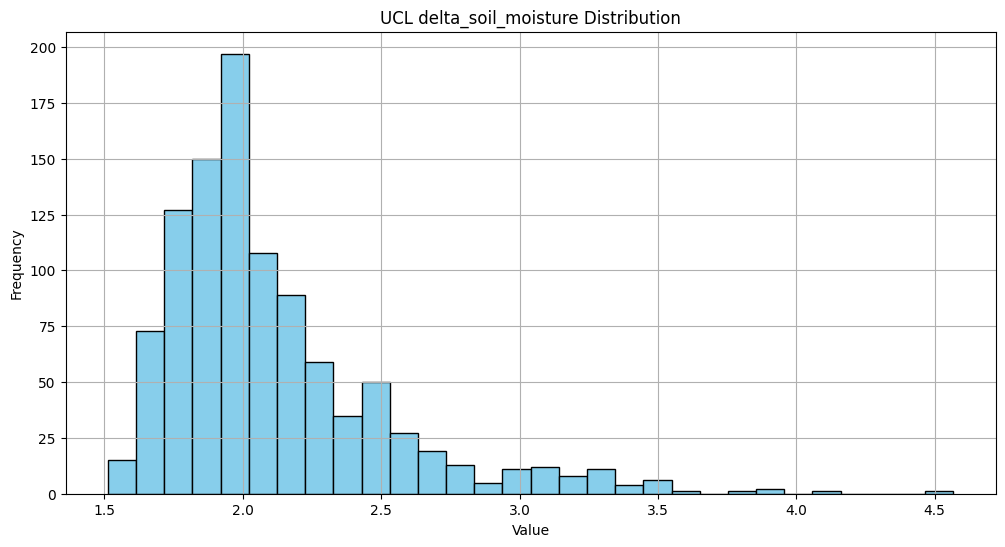

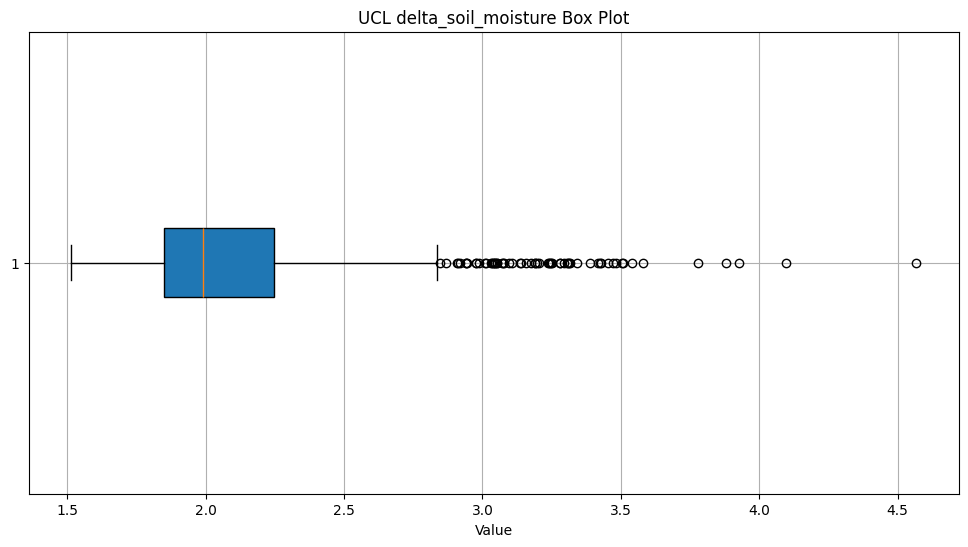

In [91]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def compute_and_plot_statistics(datasets, variables):
    """
    Compute and plot summary statistics for each variable in the datasets.

    Parameters:
        datasets (list of tuples): List of datasets and their labels.
        variables (list of str): List of variables to analyze.
    """
    for ds, label in datasets:
        for variable in variables:
            if variable not in ds.variables:
                print(f"Variable {variable} not found in {label}")
                continue
            
            data = ds[variable].values
            if data.ndim > 2:
                # Flatten the data if more than 2D (e.g., time dimension present)
                data = data.reshape(-1, data.shape[-2], data.shape[-1])
                data = data.flatten()
            
            # Remove NaNs for statistical calculations
            data = data[~np.isnan(data)]
            
            if len(data) == 0:
                print(f"No valid data for {label} {variable}")
                continue
            
            # Compute statistics
            mean = np.mean(data)
            median = np.median(data)
            std_dev = np.std(data)
            min_val = np.min(data)
            max_val = np.max(data)
            
            print(f"{label} {variable} Statistics:")
            print(f"  Mean: {mean:.2f}")
            print(f"  Median: {median:.2f}")
            print(f"  Standard Deviation: {std_dev:.2f}")
            print(f"  Min: {min_val:.2f}")
            print(f"  Max: {max_val:.2f}")
            
            # Plot histogram
            plt.figure(figsize=(12, 6))
            plt.hist(data, bins=30, color='skyblue', edgecolor='black')
            plt.title(f'{label} {variable} Distribution')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
            
            # Plot box plot
            plt.figure(figsize=(12, 6))
            plt.boxplot(data, vert=False, patch_artist=True)
            plt.title(f'{label} {variable} Box Plot')
            plt.xlabel('Value')
            plt.grid(True)
            plt.show()

# Define datasets and their labels
datasets = [
    (era5_land_vars, 'ERA5-Land'),
    (rmib_vars, 'RMIB'),
    (ucl_vars, 'UCL')
]

# Define variables to analyze including precipitation, evaporation, runoff, soil moisture, and soil moisture change
variables_to_plot = [
    'pr',            # Precipitation
    'evspsbl',       # Evapotranspiration
    'mrro',          # Runoff
    'mrso',          # Soil Moisture
    'delta_soil_moisture'  # Soil Moisture Change
]

# Compute and plot statistics for each variable in the datasets
compute_and_plot_statistics(datasets, variables_to_plot)



### 4.2 Statistical comparison between model predictions

       Model          mean        median       std_dev           min  \
0       RMIB  2.678160e+00  2.562603e+00  4.432015e-01  1.878689e+00   
1        UCL  2.105571e+00  1.991132e+00  3.981983e-01  1.512832e+00   
0       RMIB  2.176943e-05  2.104510e-05  2.536417e-06  1.767445e-05   
1        UCL  1.396260e-05  1.312933e-05  2.829427e-06  6.000378e-06   
0  ERA5-Land  6.822366e-06  6.525365e-06  2.183669e-06  2.625813e-06   
1       RMIB  2.462207e-05  2.229763e-05  8.325907e-06  1.184860e-05   
2        UCL  1.193622e-05  1.067966e-05  4.305100e-06  5.949826e-06   
0       RMIB  4.322782e+07  4.328971e+07  1.104815e+07  1.935314e+07   
1        UCL  3.653673e+07  6.610238e+06  5.739461e+07  1.418144e+05   
0       RMIB  2.678160e+00  2.562603e+00  4.432015e-01  1.878689e+00   
1        UCL  2.105571e+00  1.991132e+00  3.981983e-01  1.512832e+00   

            max             Variable  
0  5.195657e+00                   pr  
1  4.567374e+00                   pr  
0  2.935376e-05   

<Figure size 1200x600 with 0 Axes>

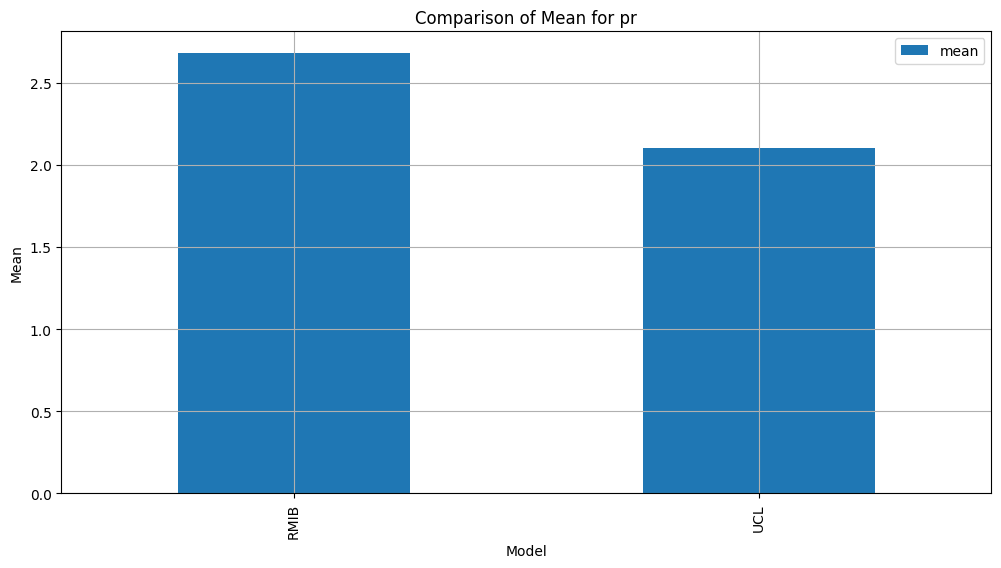

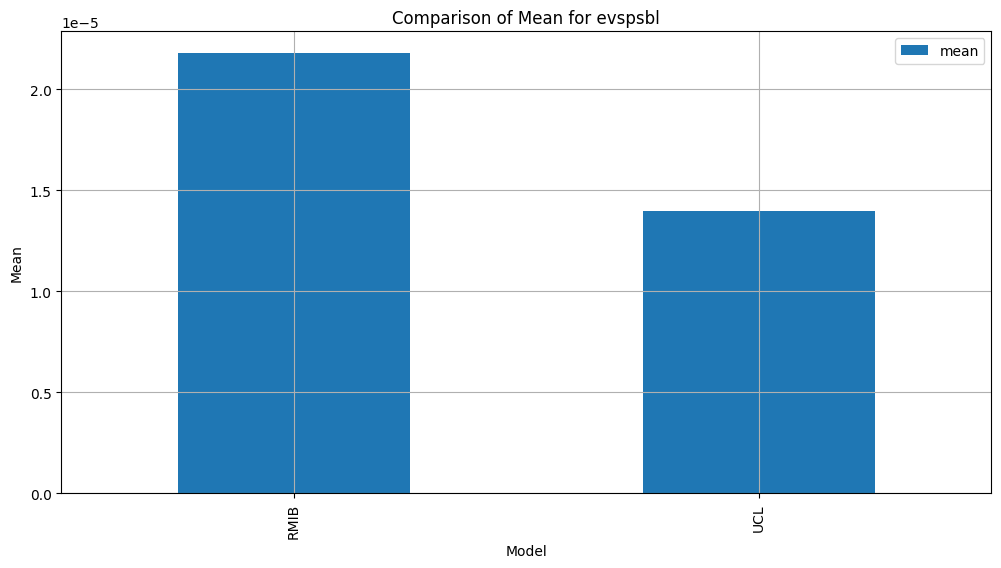

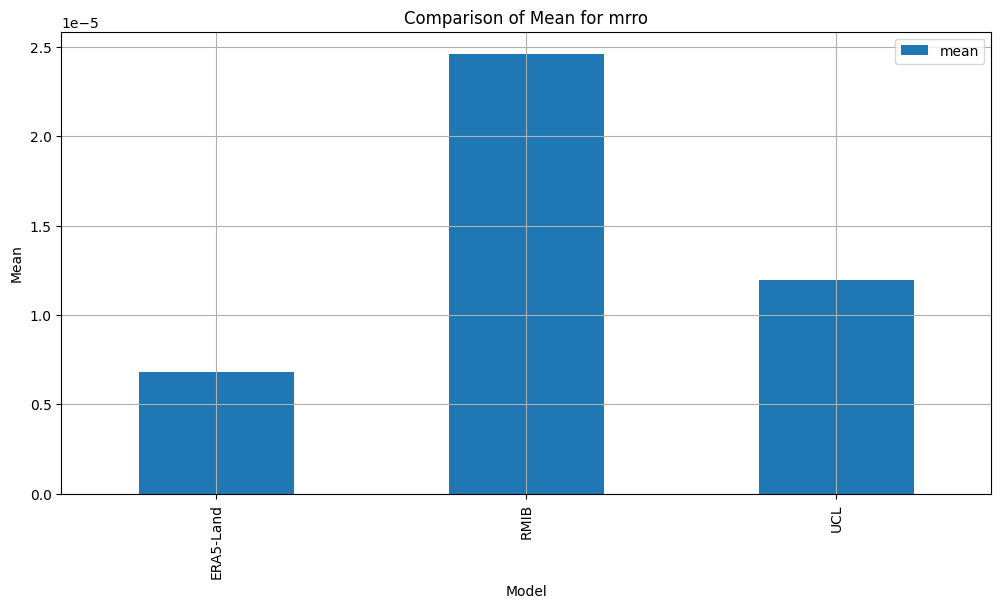

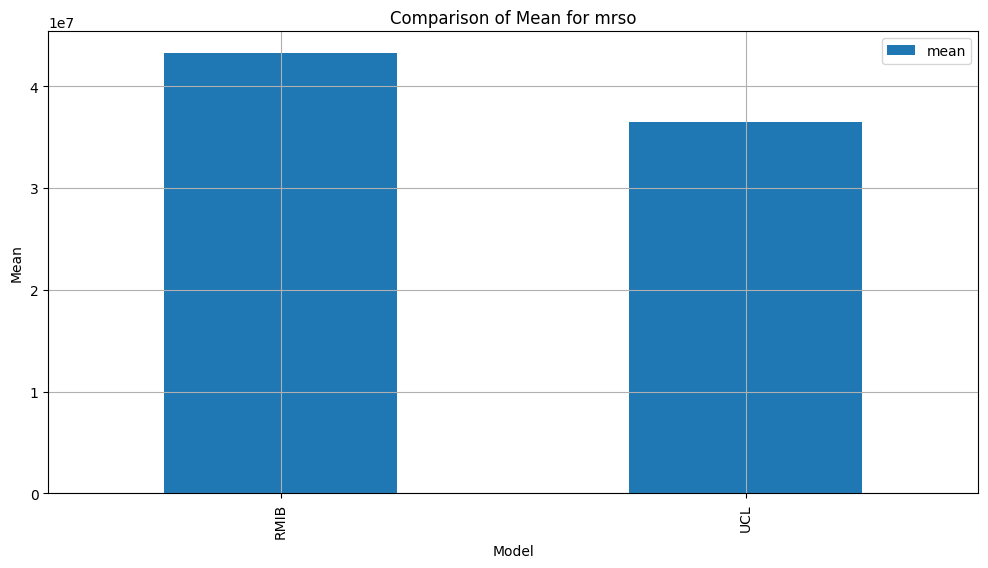

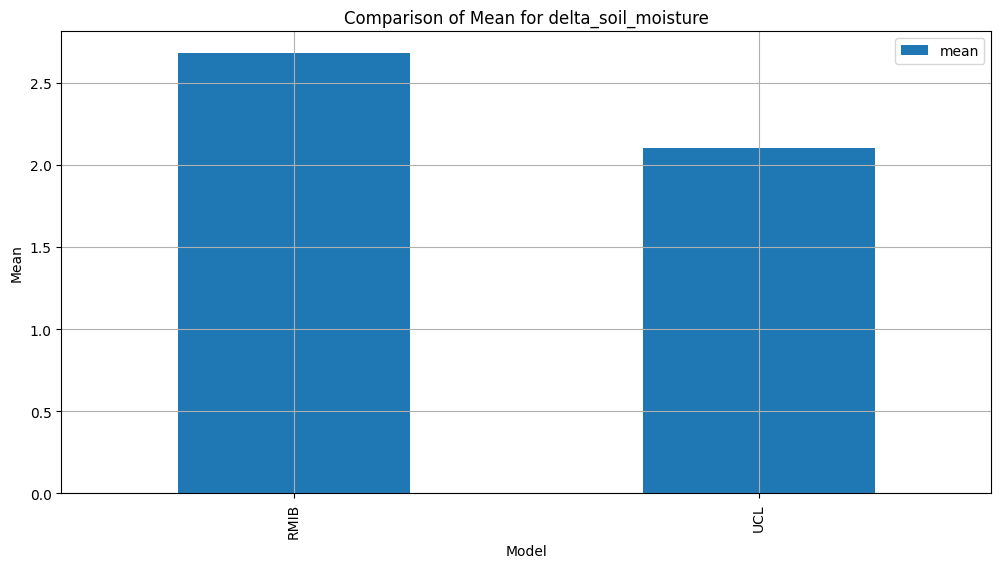

<Figure size 1200x600 with 0 Axes>

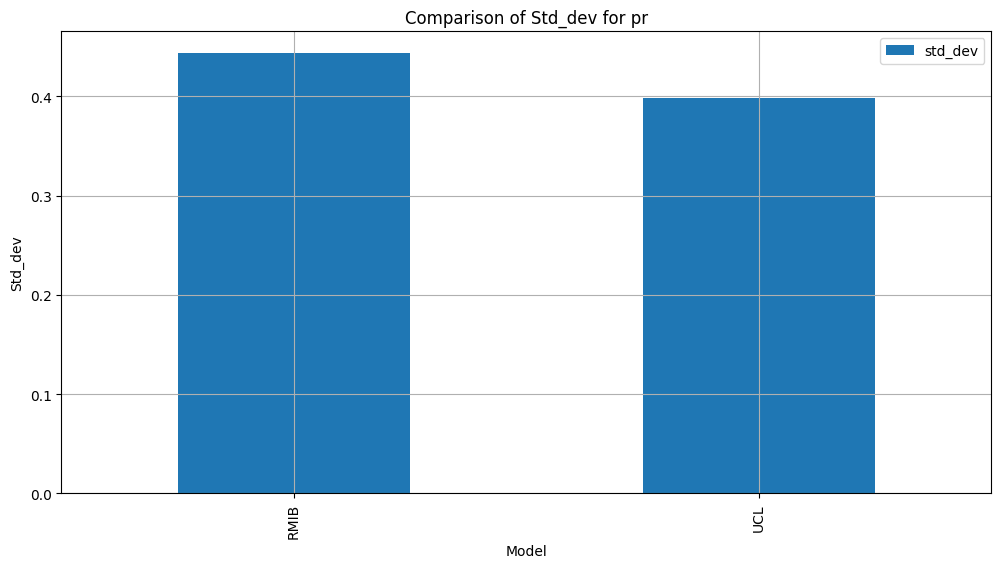

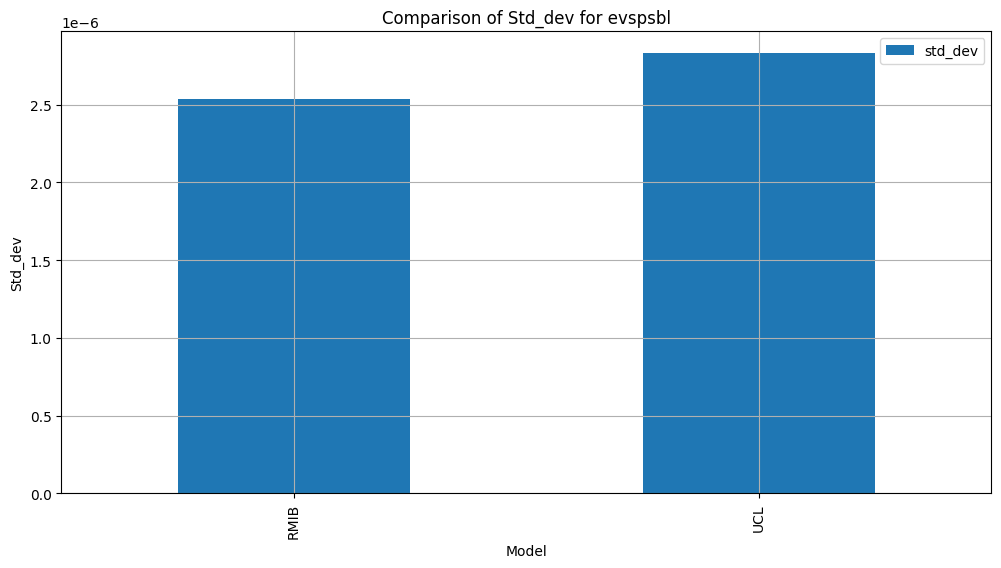

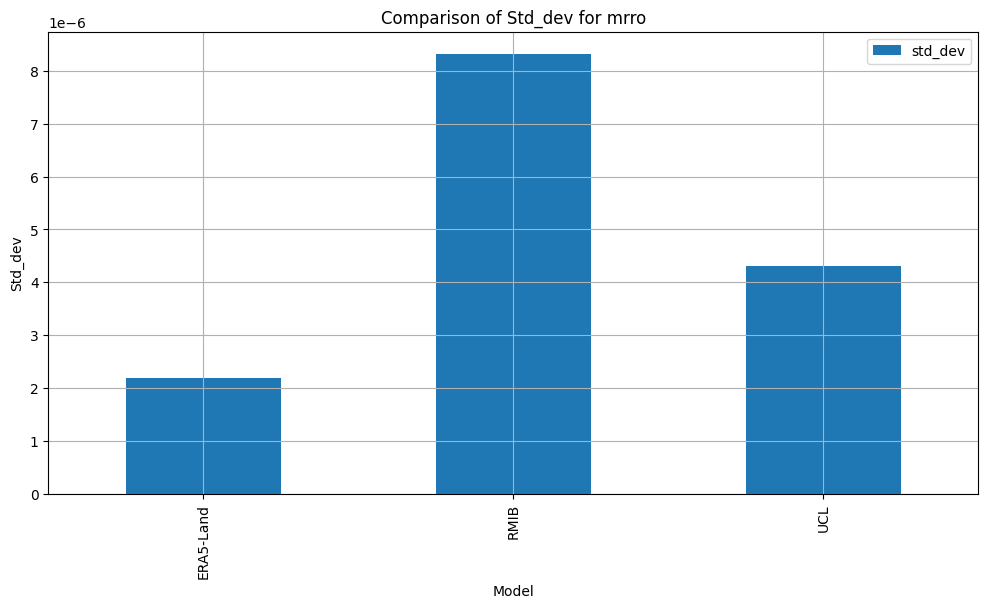

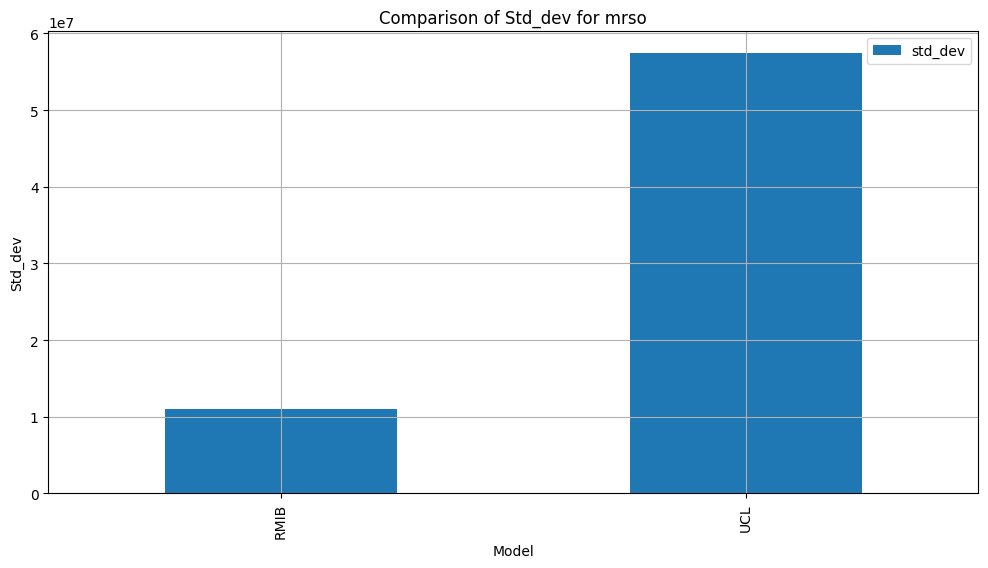

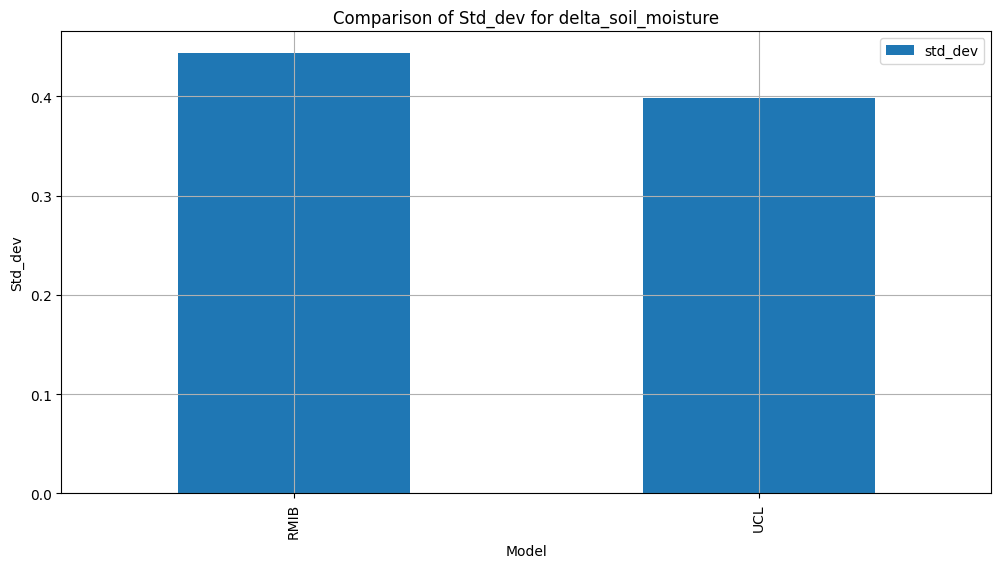

<Figure size 1200x600 with 0 Axes>

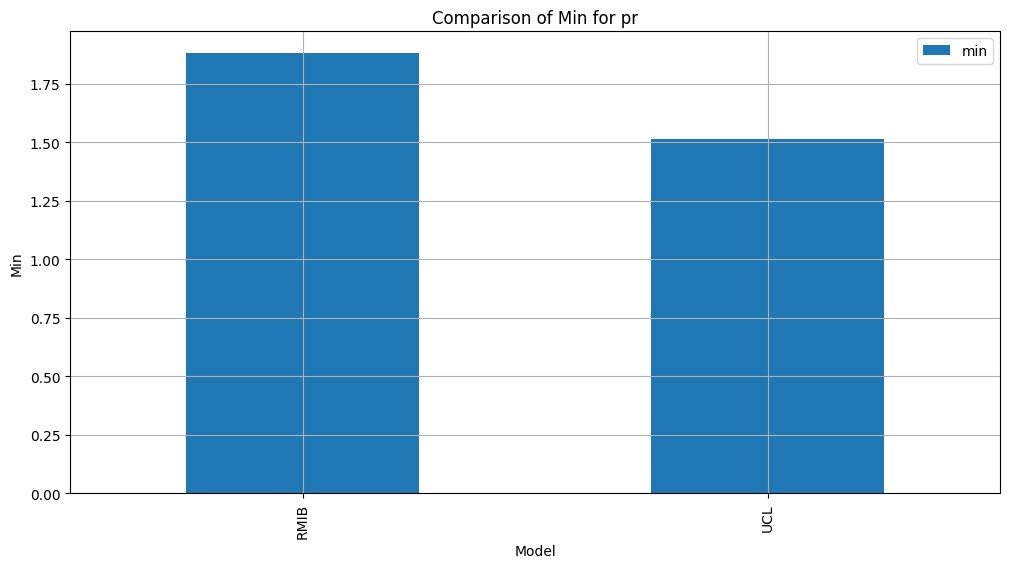

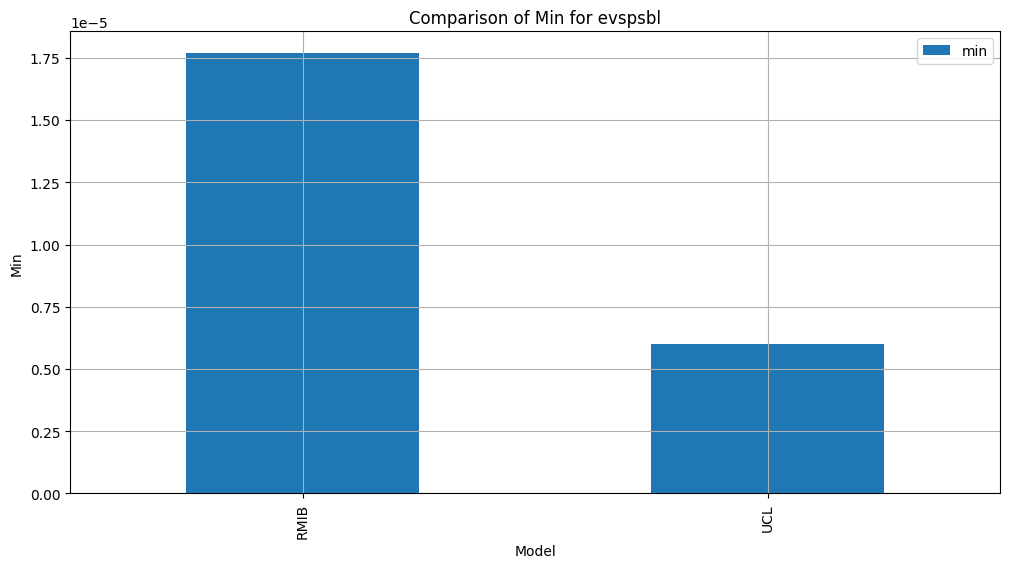

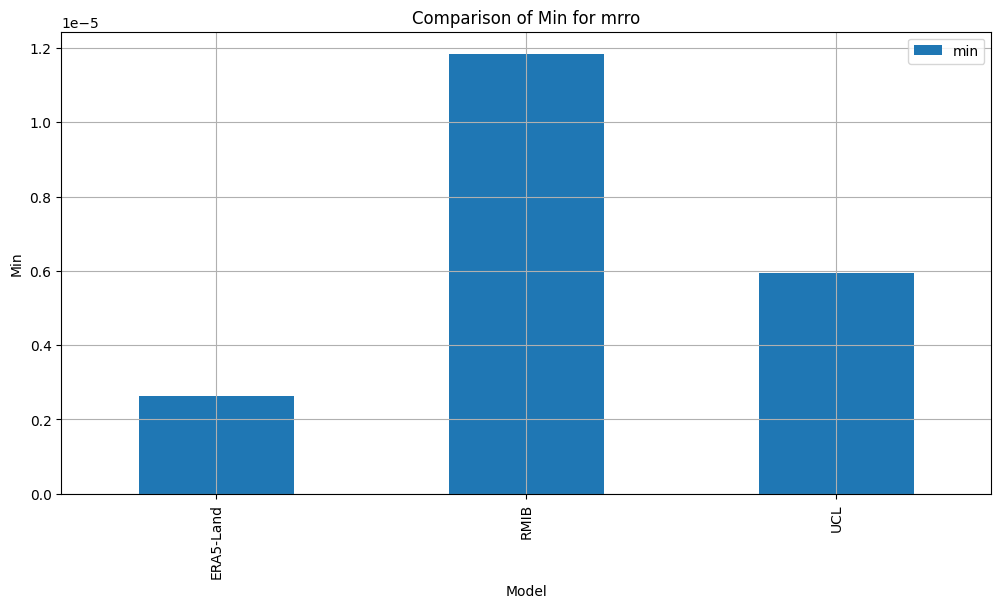

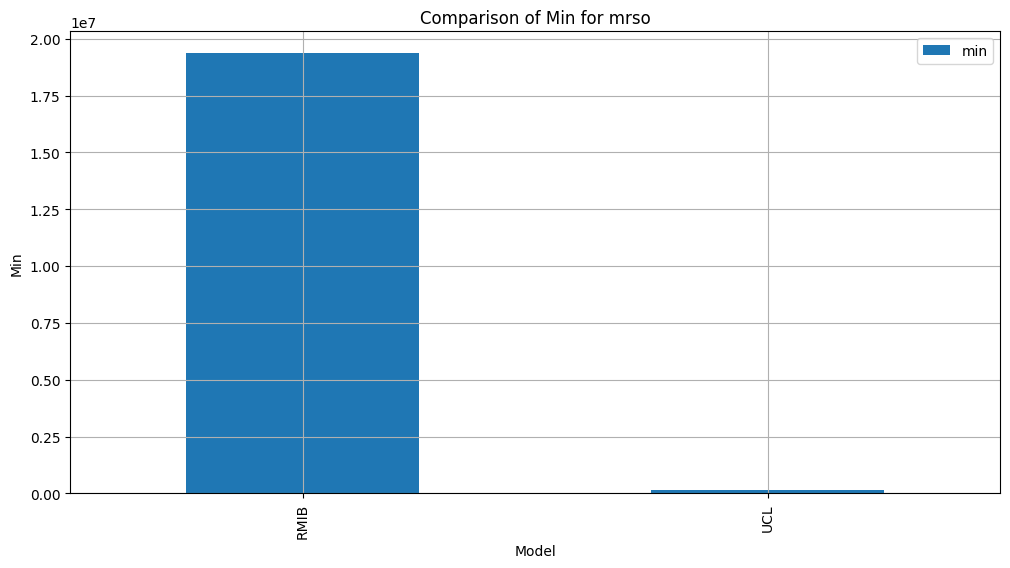

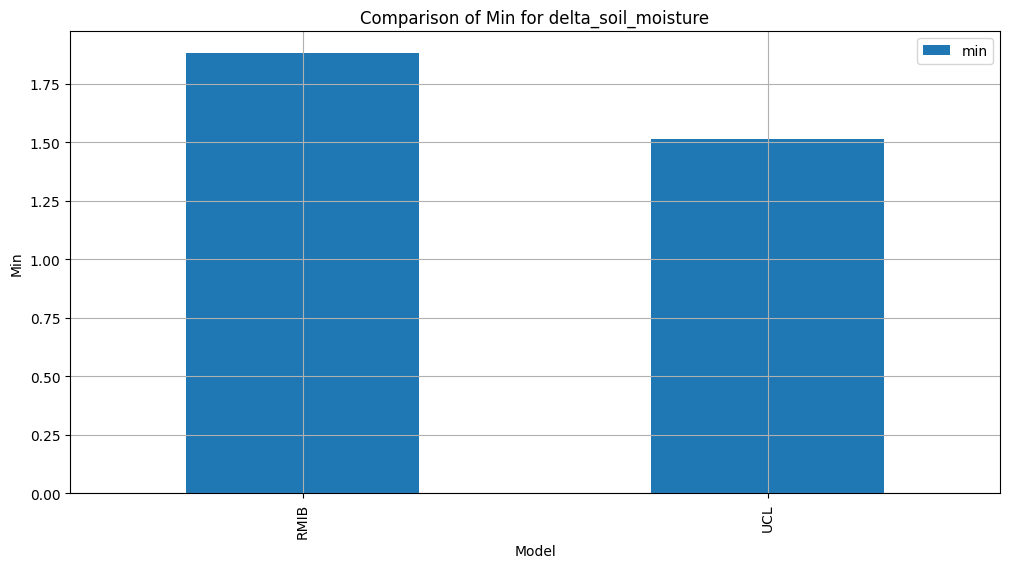

<Figure size 1200x600 with 0 Axes>

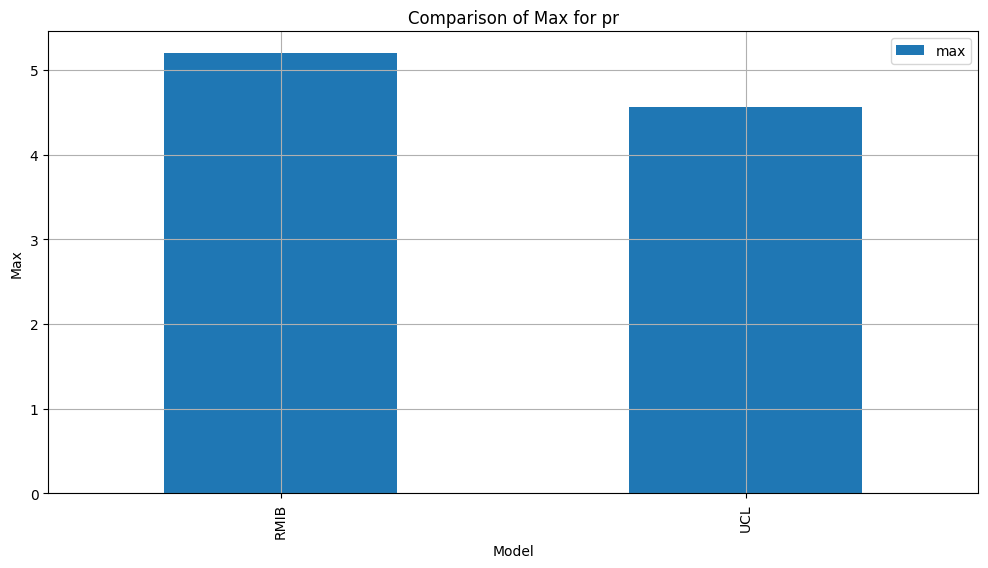

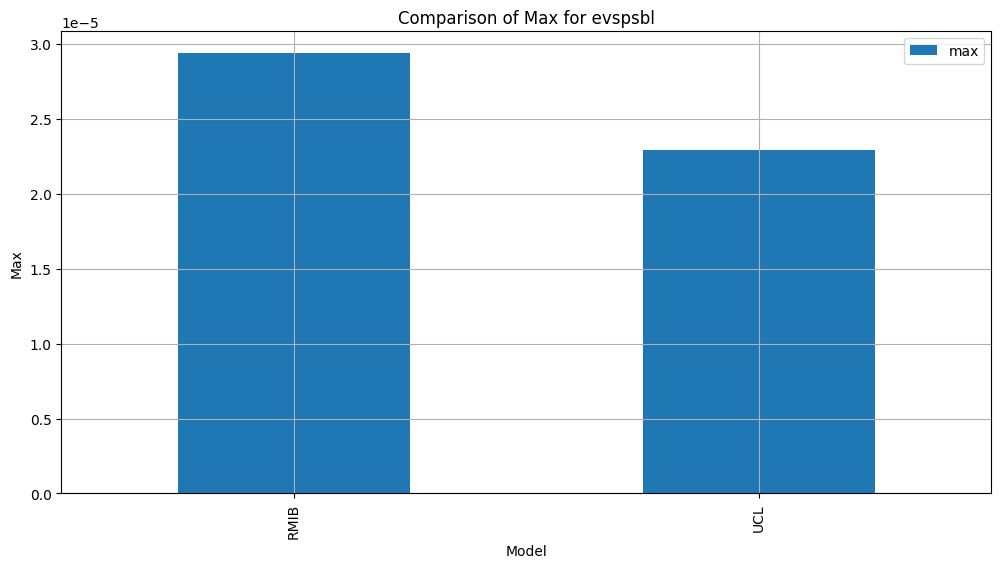

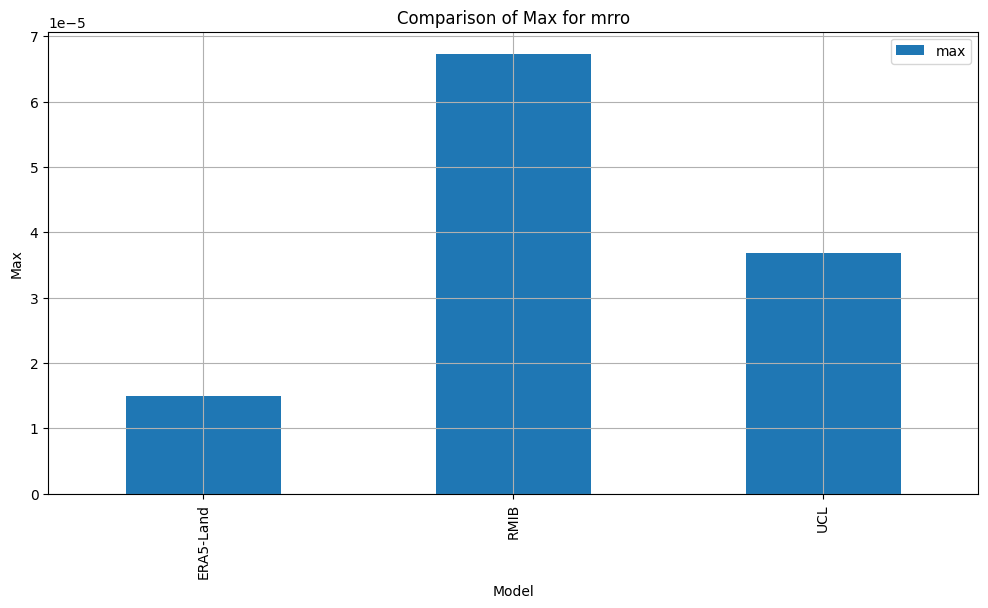

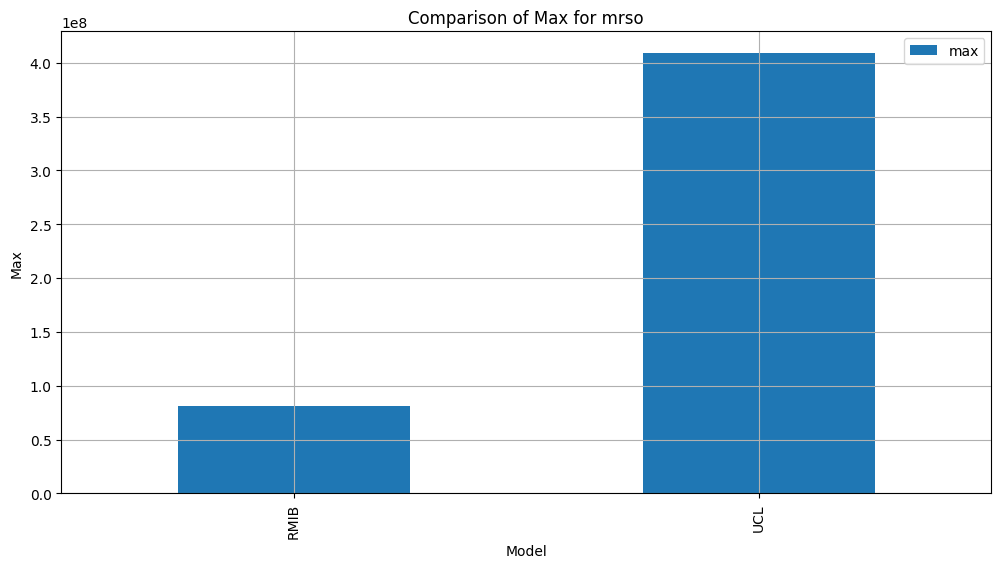

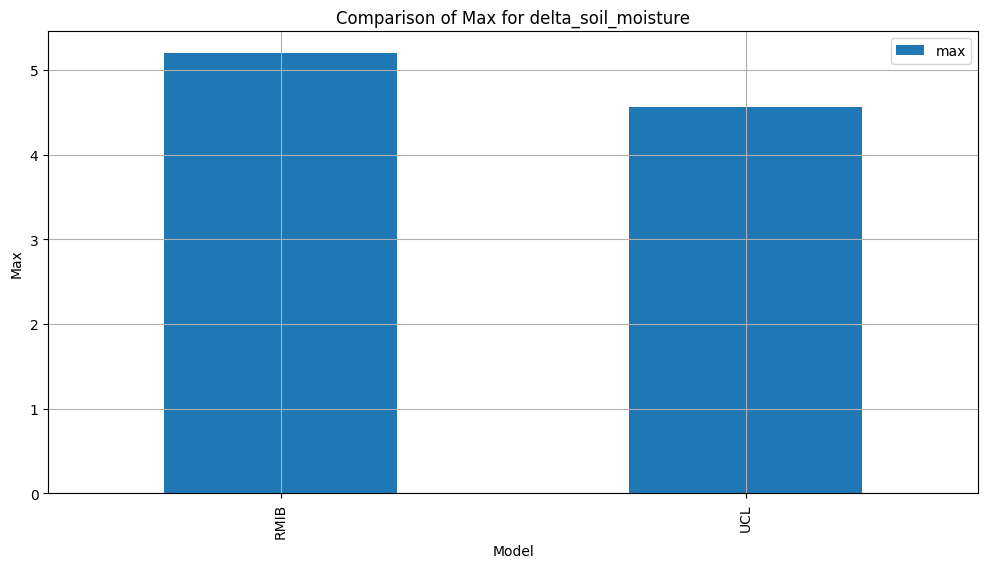

In [95]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compute_statistics(data):
    """
    Compute statistics for a given array of data.
    """
    if data.ndim > 2:
        # Flatten the data if more than 2D (e.g., time dimension present)
        data = data.reshape(-1, data.shape[-2], data.shape[-1])
        data = data.flatten()
    
    # Remove NaNs for statistical calculations
    data = data[~np.isnan(data)]
    
    if len(data) == 0:
        return {}
    
    return {
        'mean': np.mean(data),
        'median': np.median(data),
        'std_dev': np.std(data),
        'min': np.min(data),
        'max': np.max(data)
    }

def compare_model_predictions(datasets, variables):
    """
    Compare statistics for the same variable across different models.
    """
    # Gather which variables are predicted by more than one model
    variable_models = {var: [] for var in variables}
    for ds, label in datasets:
        for variable in variables:
            if variable in ds.variables:
                variable_models[variable].append(label)
    
    # Filter variables predicted by more than one model
    common_variables = [var for var, models in variable_models.items() if len(models) > 1]

    if not common_variables:
        print("No variables are predicted by more than one model.")
        return

    # Create a DataFrame to hold statistics
    stats_df = pd.DataFrame()
    
    for variable in common_variables:
        # Gather statistics for each dataset predicting this variable
        stats = {}
        for ds, label in datasets:
            if variable not in ds.variables:
                continue
            
            data = ds[variable].values
            stats[label] = compute_statistics(data)
        
        # Convert to DataFrame
        stats_df_variable = pd.DataFrame(stats).T
        stats_df_variable['Variable'] = variable
        stats_df_variable.reset_index(inplace=True)
        stats_df_variable.rename(columns={'index': 'Model'}, inplace=True)
        
        # Append to the overall DataFrame
        stats_df = pd.concat([stats_df, stats_df_variable], axis=0)
    
    print(stats_df)

    # Plot comparison for each statistic
    stats_to_plot = ['mean', 'std_dev', 'min', 'max']
    for stat in stats_to_plot:
        plt.figure(figsize=(12, 6))
        for variable in common_variables:
            subset_df = stats_df[stats_df['Variable'] == variable]
            subset_df.plot(x='Model', y=stat, kind='bar', title=f'Comparison of {stat.capitalize()} for {variable}', figsize=(12, 6))
            plt.ylabel(stat.capitalize())
            plt.xlabel('Model')
            plt.grid(True)
            plt.show()

# Define datasets and their labels
datasets = [
    (era5_land_vars, 'ERA5-Land'),
    (rmib_vars, 'RMIB'),
    (ucl_vars, 'UCL')
]

# Define variables to analyze
variables_to_plot = [
    'pr',            # Precipitation
    'evspsbl',       # Evapotranspiration
    'mrro',          # Runoff
    'mrso',          # Soil Moisture
    'delta_soil_moisture'  # Soil Moisture Change
]

# Compare model predictions for common variables
compare_model_predictions(datasets, variables_to_plot)



## 5. Temporal Analysis 

### 5.1 Timeseries compairson per variable

Note that when making this notebook the ERA5 precipitation data is not correct yet.

KeyError in subset_and_convert: 'mrso'


/tmp/ipykernel_1649515/1083084800.py:70: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  combined = pd.concat(dfs, axis=1, keys=labels)
/tmp/ipykernel_1649515/1083084800.py:70: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  combined = pd.concat(dfs, axis=1, keys=labels)
/tmp/ipykernel_1649515/1083084800.py:70: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  combined = pd.concat(dfs, axis=1, keys=labels)
/tmp/ipykernel_1649515/1083084800.py:70: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smalle

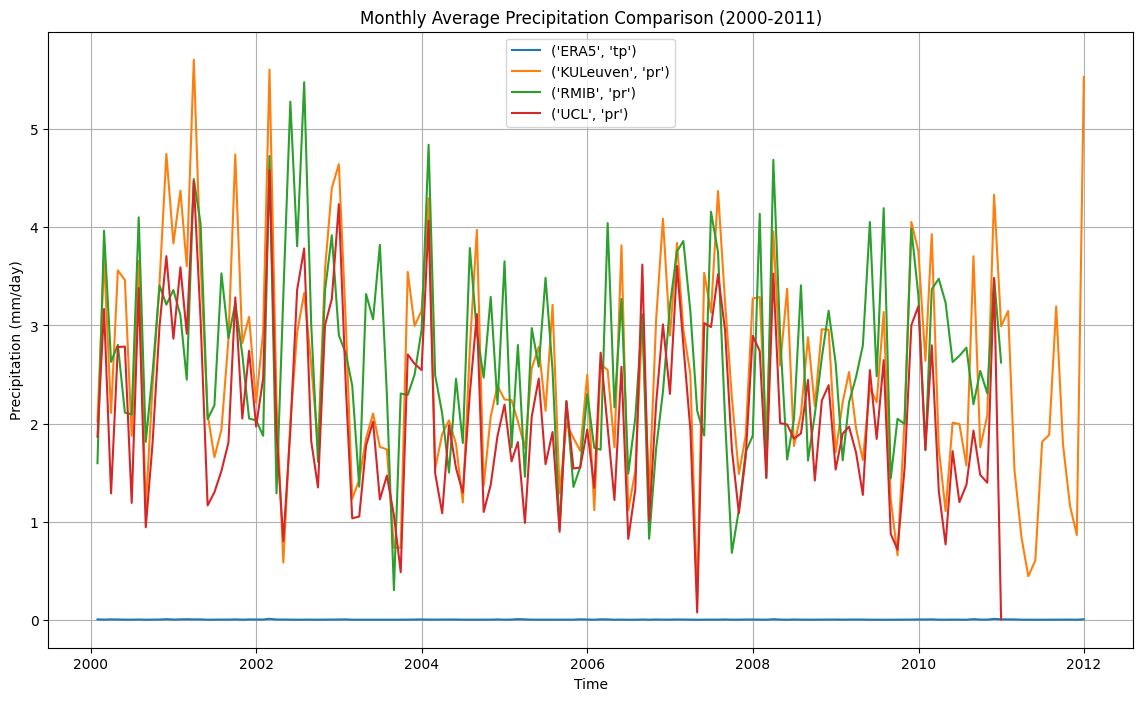

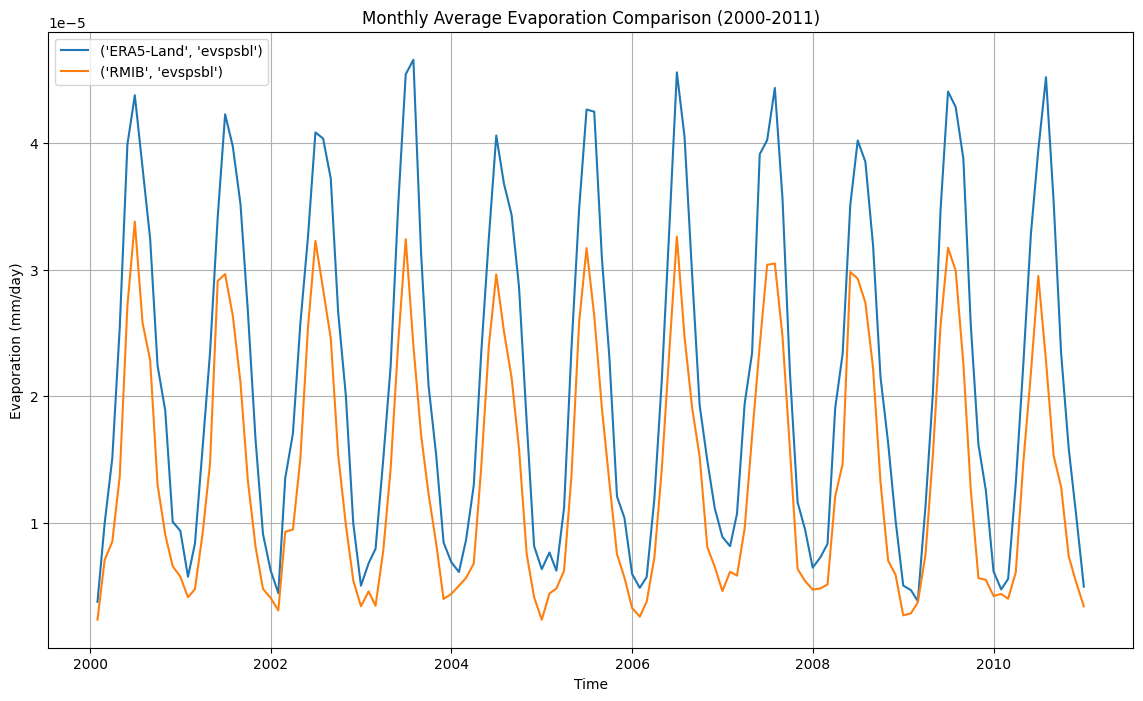

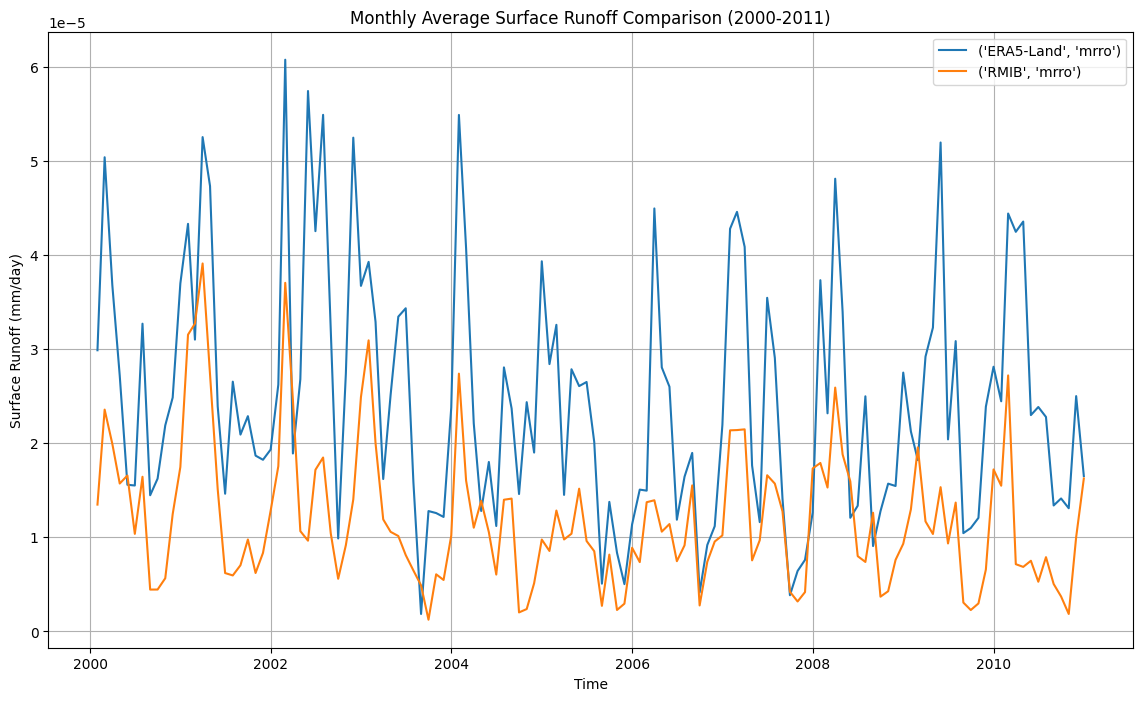

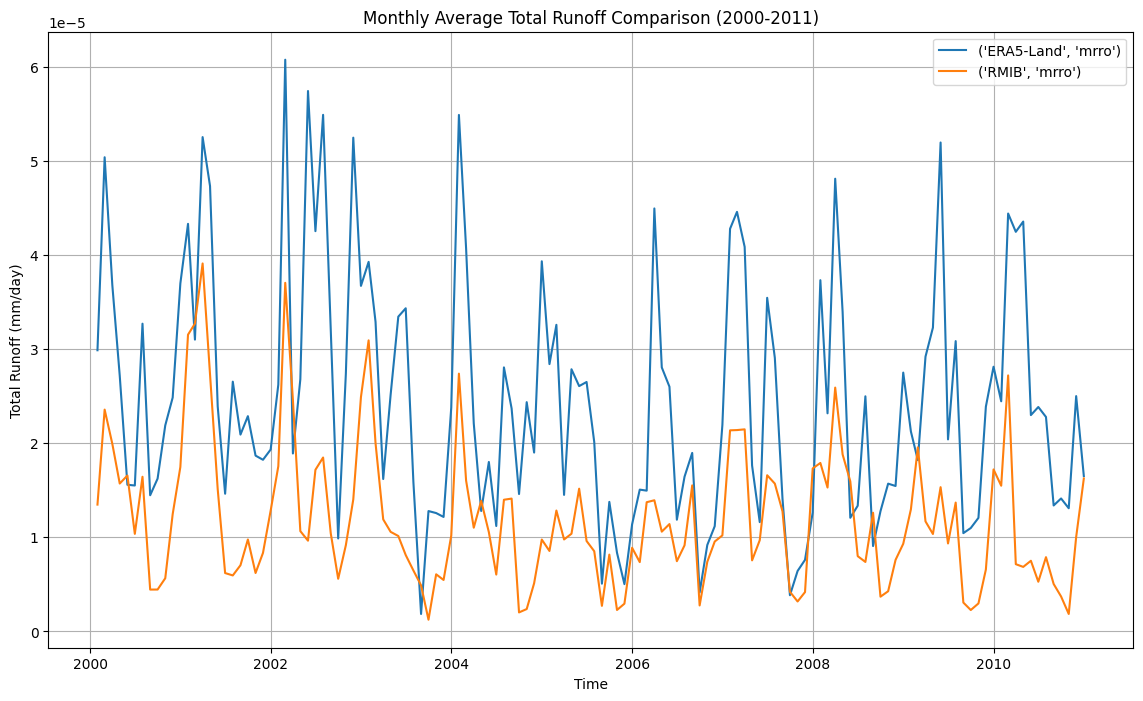

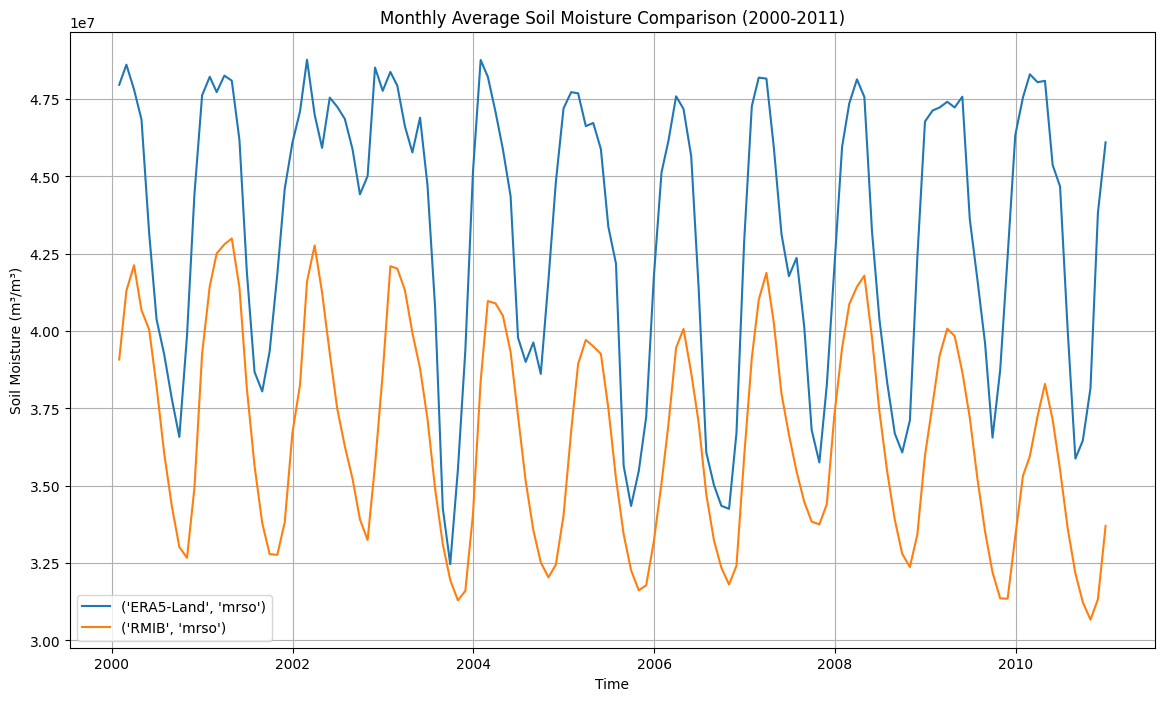

Missing 'mrso' for derivative plot in ERA5-Land Soil Moisture Derivative


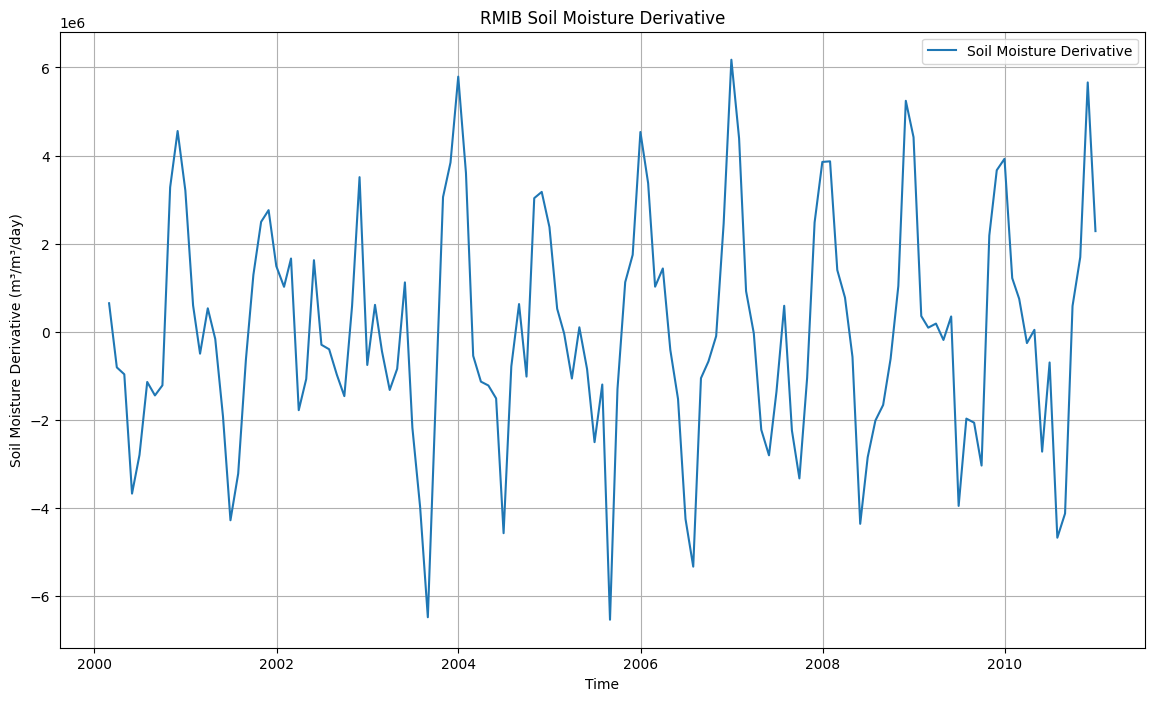

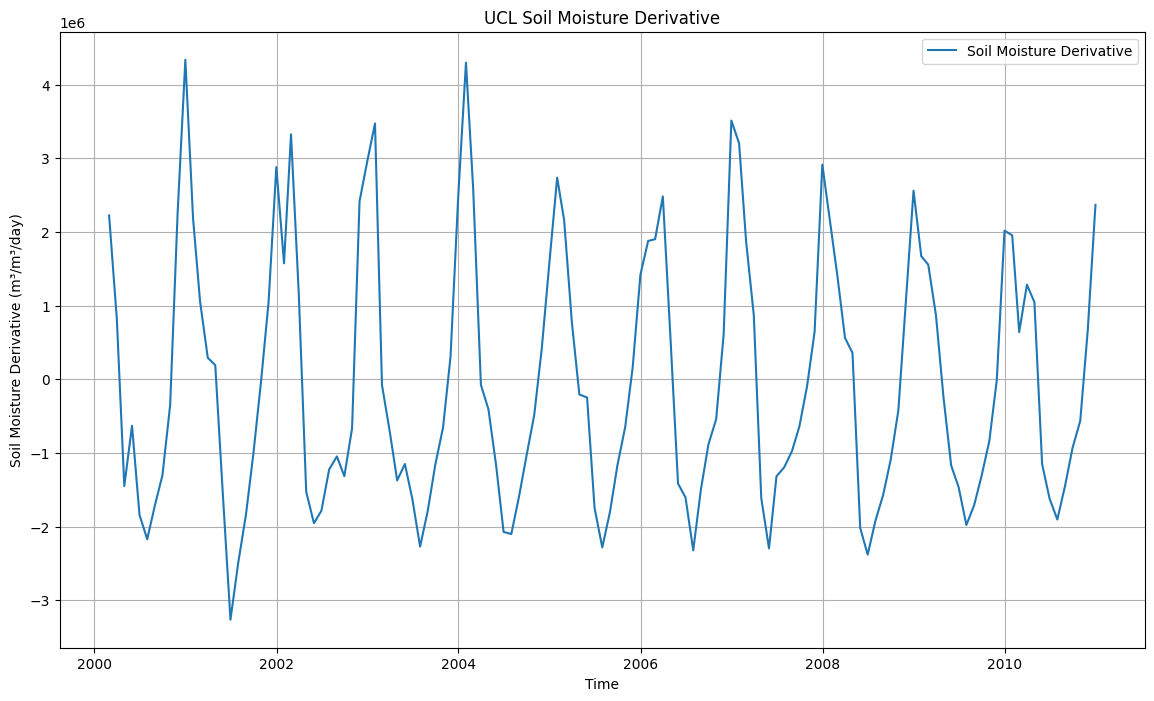

Missing variable(s) for correlation: mrso in df1 or mrso in df2


In [100]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Define the years for analysis
start_year = 2000
end_year = 2011

# Load datasets (assuming they are already loaded)
# era5_ds, era5_land_ds, rmib_ds, kul_ds, ucl_ds

# Extract relevant variables and subset the years of interest
def subset_and_convert(ds, variables, start_year, end_year):
    try:
        ds_subset = ds[variables].sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
        df = ds_subset.to_dataframe().reset_index()
        df.set_index('time', inplace=True)
        df_monthly = df.resample('ME').mean()
        return df_monthly
    except KeyError as e:
        print(f"KeyError in subset_and_convert: {e}")
        return pd.DataFrame()  # Return empty DataFrame if variable is not found

def convert_units(df):
    if df.empty:
        return df
    conversion_factor_precip = 86400
    conversion_factor_tp = 1000
    for var in ['pr', 'evspsblpot', 'prsn', 'mrros', 'mrso']:
        if var in df.columns:
            df[var] = df[var] * conversion_factor_precip
    if 'tp' in df.columns:
        df['tp'] = df['tp'] * conversion_factor_tp
    return df

def calculate_soil_moisture_change(df):
    if df.empty:
        return df
    if 'mrso' in df.columns:
        df['delta_soil_moisture'] = df.get('pr', 0) + df.get('prsn', 0) - df.get('evspsblpot', 0) - df.get('mrros', 0)
        df['cumulative_soil_moisture'] = df['delta_soil_moisture'].cumsum()
    return df

# Load and process datasets
era5_precip = subset_and_convert(era5_ds, ['tp'], start_year, end_year)
era5_land_vars = subset_and_convert(era5_land_ds, ['evspsblpot', 'mrro', 'prsn', 'mrros', 'mrso'], start_year, end_year)
rmib_vars = subset_and_convert(rmib_ds, ['pr', 'evspsbl', 'mrro', 'mrso'], start_year, end_year)
kul_vars = subset_and_convert(kul_ds, ['pr'], start_year, end_year)
ucl_vars = subset_and_convert(ucl_ds, ['pr', 'evspsbl', 'mrro', 'mrso'], start_year, end_year)

# Convert units
era5_precip = convert_units(era5_precip)
era5_land_vars = convert_units(era5_land_vars)
rmib_vars = convert_units(rmib_vars)
kul_vars = convert_units(kul_vars)
ucl_vars = convert_units(ucl_vars)

# Compute soil moisture change
era5_land_vars = calculate_soil_moisture_change(era5_land_vars)
rmib_vars = calculate_soil_moisture_change(rmib_vars)
ucl_vars = calculate_soil_moisture_change(ucl_vars)

# Combine data for comparison
def combine_dataframes(dfs, labels):
    dfs = [df for df in dfs if not df.empty]  # Exclude empty dataframes
    if not dfs:
        return pd.DataFrame()
    combined = pd.concat(dfs, axis=1, keys=labels)
    return combined

# Plot time series
def plot_timeseries(df, title, ylabel):
    if df.empty:
        print(f"No data to plot for {title}")
        return
    plt.figure(figsize=(14, 8))
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare data for comparison
precipitation_combined = combine_dataframes(
    [era5_precip[['tp']],
     kul_vars[['pr']] if 'pr' in kul_vars.columns else pd.DataFrame(),
     rmib_vars[['pr']] if 'pr' in rmib_vars.columns else pd.DataFrame(),
     ucl_vars[['pr']] if 'pr' in ucl_vars.columns else pd.DataFrame()],
    ['ERA5', 'KULeuven', 'RMIB', 'UCL']
)

evaporation_combined = combine_dataframes(
    [era5_land_vars[['evspsblpot']] if 'evspsblpot' in era5_land_vars.columns else pd.DataFrame(),
     rmib_vars[['evspsbl']] if 'evspsbl' in rmib_vars.columns else pd.DataFrame(),
     ucl_vars[['evspsbl']] if 'evspsbl' in ucl_vars.columns else pd.DataFrame()],
    ['ERA5-Land', 'RMIB', 'UCL']
)

surface_runoff_combined = combine_dataframes(
    [era5_land_vars[['mrros']] if 'mrros' in era5_land_vars.columns else pd.DataFrame(),
     rmib_vars[['mrro']] if 'mrro' in rmib_vars.columns else pd.DataFrame(),
     ucl_vars[['mrro']] if 'mrro' in ucl_vars.columns else pd.DataFrame()],
    ['ERA5-Land', 'RMIB', 'UCL']
)

total_runoff_combined = combine_dataframes(
    [era5_land_vars[['mrro']] if 'mrro' in era5_land_vars.columns else pd.DataFrame(),
     rmib_vars[['mrro']] if 'mrro' in rmib_vars.columns else pd.DataFrame(),
     ucl_vars[['mrro']] if 'mrro' in ucl_vars.columns else pd.DataFrame()],
    ['ERA5-Land', 'RMIB', 'UCL']
)

soil_moisture_combined = combine_dataframes(
    [era5_land_vars[['mrso']] if 'mrso' in era5_land_vars.columns else pd.DataFrame(),
     rmib_vars[['mrso']] if 'mrso' in rmib_vars.columns else pd.DataFrame(),
     ucl_vars[['mrso']] if 'mrso' in ucl_vars.columns else pd.DataFrame()],
    ['ERA5-Land', 'RMIB', 'UCL']
)

# Plot time series
plot_timeseries(precipitation_combined, 'Monthly Average Precipitation Comparison (2000-2011)', 'Precipitation (mm/day)')
plot_timeseries(evaporation_combined, 'Monthly Average Evaporation Comparison (2000-2011)', 'Evaporation (mm/day)')
plot_timeseries(surface_runoff_combined, 'Monthly Average Surface Runoff Comparison (2000-2011)', 'Surface Runoff (mm/day)')
plot_timeseries(total_runoff_combined, 'Monthly Average Total Runoff Comparison (2000-2011)', 'Total Runoff (mm/day)')
plot_timeseries(soil_moisture_combined, 'Monthly Average Soil Moisture Comparison (2000-2011)', 'Soil Moisture (m³/m³)')

# Plot time derivatives and correlations for soil moisture
def plot_soil_moisture_derivative(df, title):
    if df.empty or 'mrso' not in df.columns:
        print(f"Missing 'mrso' for derivative plot in {title}")
        return
    df['soil_moisture_derivative'] = df['mrso'].diff()
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['soil_moisture_derivative'], label='Soil Moisture Derivative')
    plt.xlabel('Time')
    plt.ylabel('Soil Moisture Derivative (m³/m³/day)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def check_temporal_correlation(df1, df2, var1, var2):
    if var1 not in df1.columns or var2 not in df2.columns:
        print(f"Missing variable(s) for correlation: {var1} in df1 or {var2} in df2")
        return None
    corr, _ = pearsonr(df1[var1].dropna(), df2[var2].dropna())
    return corr

# Plot soil moisture derivatives
plot_soil_moisture_derivative(era5_land_vars, 'ERA5-Land Soil Moisture Derivative')
plot_soil_moisture_derivative(rmib_vars, 'RMIB Soil Moisture Derivative')
plot_soil_moisture_derivative(ucl_vars, 'UCL Soil Moisture Derivative')

# Check temporal correlation between models (example between ERA5-Land and RMIB)
corr_era5_rmib = check_temporal_correlation(era5_land_vars, rmib_vars, 'mrso', 'mrso')
if corr_era5_rmib is not None:
    print(f'Temporal correlation between ERA5-Land and RMIB soil moisture: {corr_era5_rmib:.2f}')

### 5.2 Predicted vs actual variables using the water balance

Note that the plots below show a large difference in what is prediceted and what is considered actual. This is because there are unresolved issues with some variables in the models. When these issues are resolved, this code can be used properly and the actual should be close to the predicted.

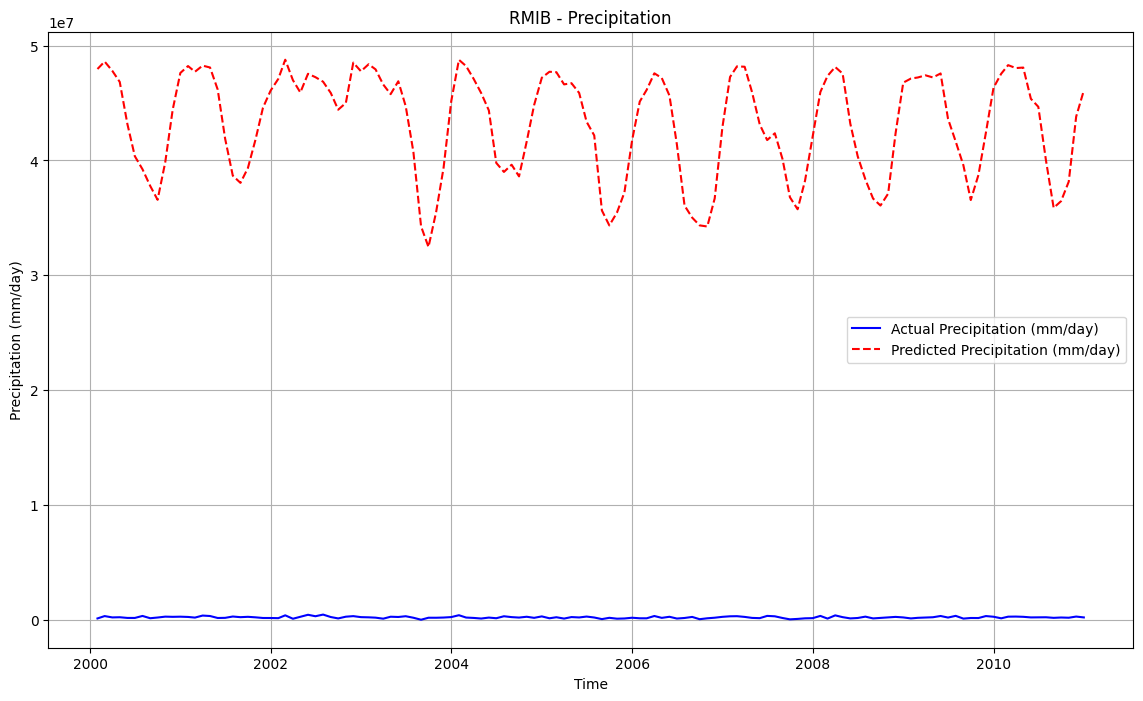

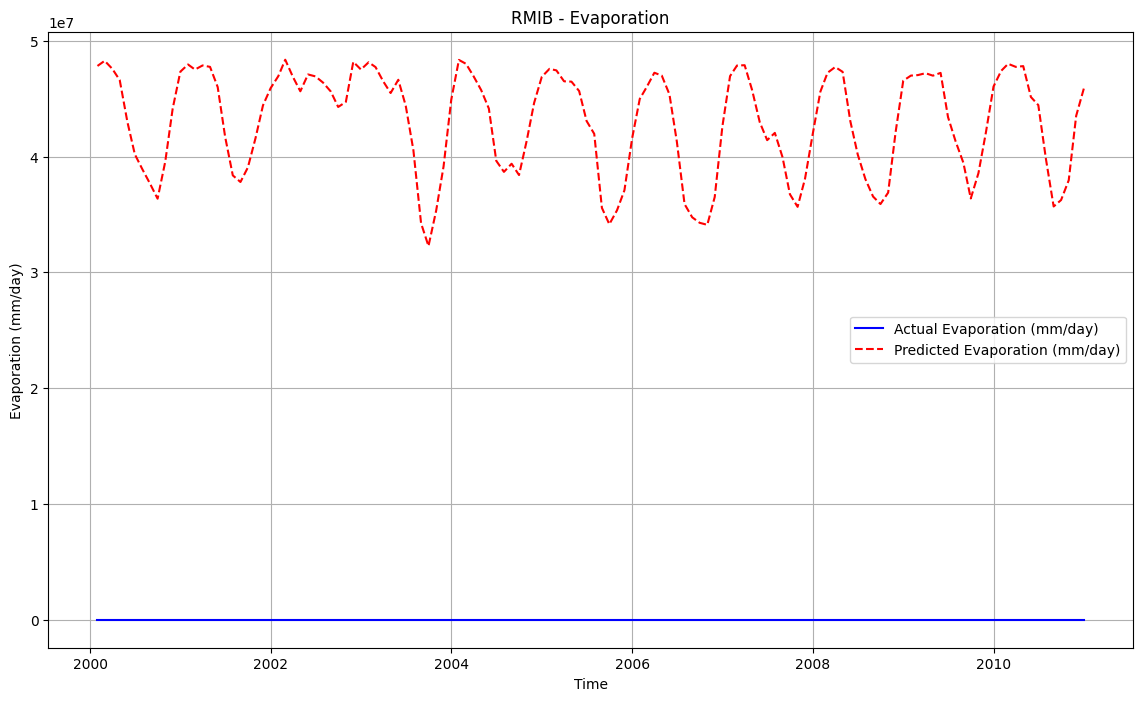

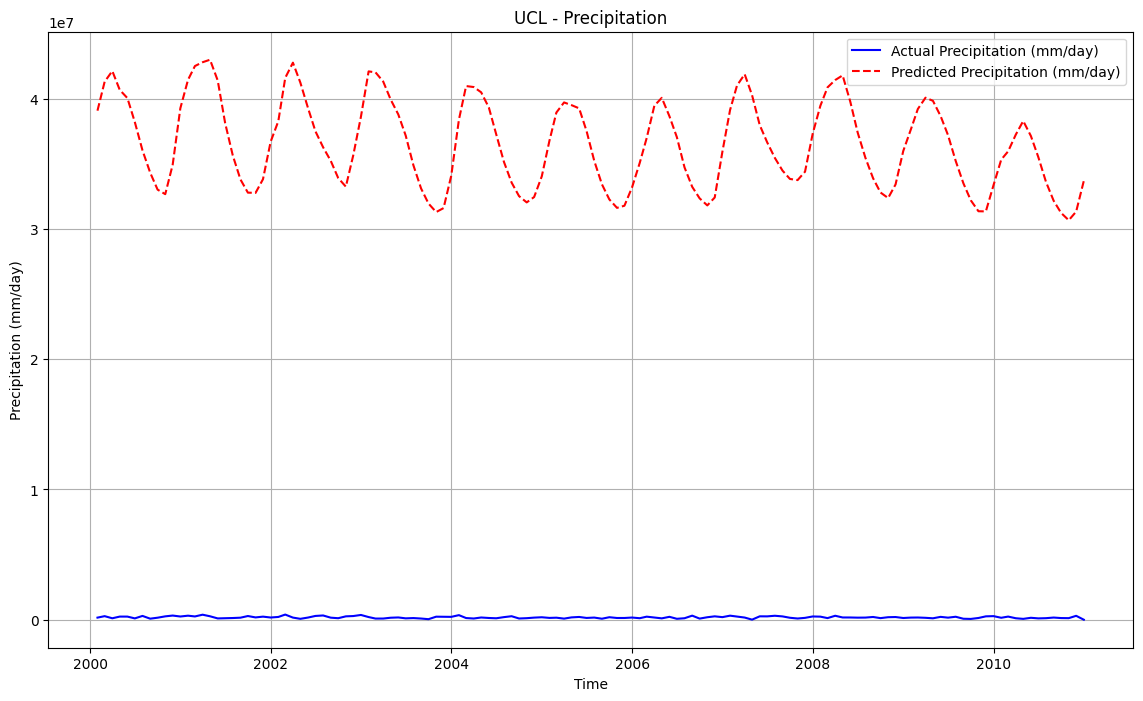

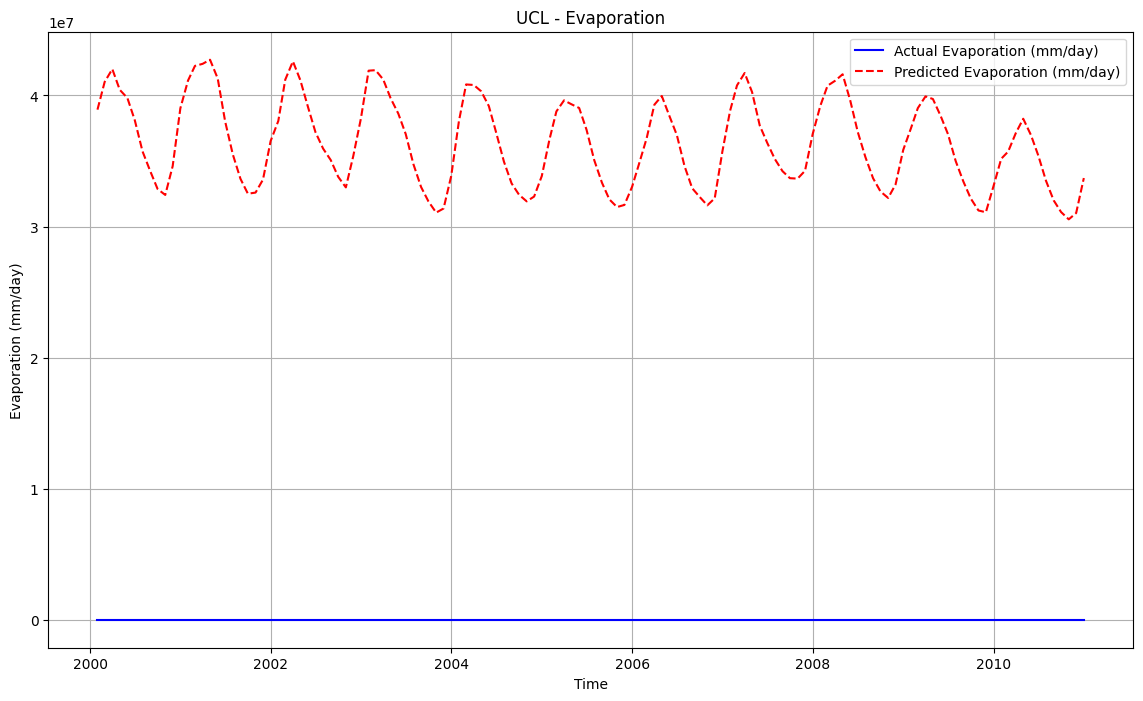

In [17]:
import matplotlib.pyplot as plt

# Helper function to convert units
def convert_units(df, param, current_unit, target_unit):
    if param not in df.columns:
        return df
    if current_unit == 'm' and target_unit == 'mm':
        df[param] *= 1000
    elif current_unit == 'kg m-2 s-1' and target_unit == 'mm/day':
        df[param] *= 86400  # Convert from mm/s to mm/day
    return df

# Define prediction functions for each parameter with unit handling and scaling

def predict_precipitation(df):
    if df.empty:
        return df
    
    prsn = df.get('prsn', 0)  # Snowfall
    mrso = df.get('mrso', 0)  # Soil moisture (in mm)
    evspsblpot = df.get('evspsblpot', 0)  # Potential evaporation (in mm/day)
    mrro = df.get('mrro', 0)  # Runoff (in mm/day)

    df['predicted_pr'] = mrso - prsn + evspsblpot + mrro
    return df

def predict_evaporation(df):
    if df.empty:
        return df
    
    evspsbl = df.get('evspsblpot', df.get('evspsbl', 0))  # Use either evspsblpot or evspsbl
    
    pr = df.get('pr', 0)
    prsn = df.get('prsn', 0)
    mrso = df.get('mrso', 0)
    mrro = df.get('mrro', 0)
    
    df['predicted_evspsblpot'] = mrso - pr + prsn + mrro
    return df

def predict_surface_runoff(df):
    if df.empty:
        return df
    pr = df.get('pr', 0)
    prsn = df.get('prsn', 0)
    mrso = df.get('mrso', 0)
    evspsblpot = df.get('evspsblpot', 0)
    
    df['predicted_mrros'] = mrso - pr + prsn + evspsblpot
    return df

# Define comparison functions for each parameter

def compare_actual_vs_predicted_param(df, actual_col, predicted_col, title, ylabel):
    if df.empty or actual_col not in df.columns or predicted_col not in df.columns:
        print(f"Missing data for comparison in {title}")
        return
    
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df[actual_col], label=f'Actual {ylabel}', color='blue')
    plt.plot(df.index, df[predicted_col], label=f'Predicted {ylabel}', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply predictions to datasets

def process_and_plot(df, title, unit_map):
    # Convert units
    for param, (current_unit, target_unit) in unit_map.items():
        df = convert_units(df, param, current_unit, target_unit)
    
    # Predict and plot precipitation
    df = predict_precipitation(df)
    if 'pr' in df.columns or 'tp' in df.columns:  # Check if 'pr' or 'tp' is present
        actual_pr = df['pr'] if 'pr' in df.columns else df['tp']
        compare_actual_vs_predicted_param(df, actual_pr.name, 'predicted_pr', title + ' - Precipitation', 'Precipitation (mm/day)')
    
    # Predict and plot evaporation
    df = predict_evaporation(df)
    if 'evspsblpot' in df.columns or 'evspsbl' in df.columns:
        actual_evaporation = df['evspsblpot'] if 'evspsblpot' in df.columns else df['evspsbl']
        compare_actual_vs_predicted_param(df, actual_evaporation.name, 'predicted_evspsblpot', title + ' - Evaporation', 'Evaporation (mm/day)')
    
    # Predict and plot surface runoff
    df = predict_surface_runoff(df)
    if 'mrros' in df.columns:
        compare_actual_vs_predicted_param(df, 'mrros', 'predicted_mrros', title + ' - Surface Runoff', 'Surface Runoff (mm/day)')

# Define unit mappings for each dataset
era5_land_unit_map = {
    'tp': ('m', 'mm'),
    'pr': ('kg m-2 s-1', 'mm/day'),
    'prsn': ('kg m-2 s-1', 'mm/day'),
    'evspsblpot': ('kg m-2 s-1', 'mm/day'),
    'mrro': ('kg m-2 s-1', 'mm/day'),
    'mrso': ('kg m-2', 'mm')
}

rmib_ucl_unit_map = {
    'pr': ('kg m-2 s-1', 'mm/day'),
    'prsn': ('kg m-2 s-1', 'mm/day'),
    'evspsblpot': ('kg m-2 s-1', 'mm/day'),
    'mrro': ('kg m-2 s-1', 'mm/day'),
    'mrso': ('kg m-2', 'mm')
}

# Process datasets and plot
process_and_plot(era5_land_vars, 'ERA5-Land', era5_land_unit_map)
process_and_plot(rmib_vars, 'RMIB', rmib_ucl_unit_map)
process_and_plot(ucl_vars, 'UCL', rmib_ucl_unit_map)
